# Notebook - Find best Drug compound for Ebola virus (Ebola +Zaire Ebola)

In this notebook, we demonstrate the use of MACAW embeddings to model binding affinity to a protein receptor of pharmacological interest. MACAW embeddings are then applied to identify promising candidate molecules in a custom virtual library.

In [375]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

In [376]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 
import seaborn as sns
from copy import deepcopy
import pickle

import sys
sys.path.append('../')

import macaw
print(macaw.__version__)
from macaw import *

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['figure.dpi'] = 96
matplotlib.rcParams['savefig.dpi'] = 600

%run "./plotting.py"

1.0.1


In [377]:
%config InlineBackend.figure_format = 'retina'

## 1. Regression Target: pPotency

### 1.1 Data preparation

In [378]:
dataDir = '/mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')

Read data for Ebola virus

In [379]:
allVirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + 'allVirusData_chEMBL_uM_wMACAW.csv')
EbolavirusData_chEMBL_uM = allVirusData_chEMBL_wMACAW[allVirusData_chEMBL_wMACAW['Virus'] == 'Ebola']
EbolavirusData_chEMBL_uM = EbolavirusData_chEMBL_uM.rename(columns={'Virus': 'strain'})
EbolavirusData_chEMBL_uM

Unnamed: 0 molecule_chembl_id  \
13073       41083      CHEMBL3596788   
13074       41086      CHEMBL3753489   
13075       41087      CHEMBL4751715   
13076       41088      CHEMBL4792617   
13077       41089      CHEMBL5085366   
...           ...                ...   
13794       42032      CHEMBL5591747   
13795       42033      CHEMBL5592622   
13796       42034       CHEMBL221722   
13797       42035      CHEMBL5595942   
13798       42036      CHEMBL4541962   

                                                  smiles molecular_formula  \
13073                       COc1nc(N)ncc1-c1cn(COCCO)cn1        C11H15N5O3   
13074       Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O        C12H14N4O3   
13075  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...       C37H42N3O5P   
13076  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...     C38H41F3N3O5P   
13077  CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...       C43H65N6O9P   
...                                                  ...               ...   
13794  CCN1CCN(CCCC(=O)O[C@H]2C(C)(C)[C@H]3CC[C@]2(C)...        C20H36N2O2   
13795  C[C@@H]1[C@H]2C[C@@H](C[C@H]1OC(=O)CN1CCN(C)CC...        C17H30N2O2   
13796                                 NC(=O)c1nc(F)cnc1O         C5H4FN3O2   
13797    CC1(C)[C@H]2CC[C@](C)(C2)[C@H]1OC(=O)CCN1CCOCC1         C17H29NO3   
13798    COc1ccc(-c2cnc3[nH]cc(NC(=O)c4cccnc4)c3c2)cc1OC        C21H18N4O3   

                         inchi_key  \
13073  CVSSXRUFNBCRPB-UHFFFAOYSA-N   
13074  PCJCKCSFBICBNZ-NRZXQICZSA-N   
13075  BCNOLUKYPQLFDY-UHFFFAOYSA-N   
13076  YPONQFDDBHJAOJ-UHFFFAOYSA-N   
13077  VXYCOVDOXKSLFC-NKSQPNMBSA-N   
...                            ...   
13794  NUMKCFVODGNSTL-XKGZKEIXSA-N   
13795  BGOGHLRTERBUFT-LXTVHRRPSA-N   
13796  ZCGNOVWYSGBHAU-UHFFFAOYSA-N   
13797  MBWOXPVSSAKRDX-JLJPHGGASA-N   
13798  ACBZBWFKUGVGRC-UHFFFAOYSA-N   

                                                   inchi  molecular_weight  \
13073  InChI=1S/C11H15N5O3/c1-18-10-8(4-13-11(12)15-1...           265.270   
13074  InChI=1S/C12H14N4O3/c13-12-9-7(1-2-14-12)16(5-...           262.270   
13075  InChI=1S/C37H42N3O5P/c1-3-43-46(41,44-4-2)27-3...           639.730   
13076  InChI=1S/C38H41F3N3O5P/c1-3-47-50(45,48-4-2)26...           707.730   
13077  InChI=1S/C43H65N6O9P/c1-5-8-9-10-11-12-13-14-1...           841.000   
...                                                  ...               ...   
13794  InChI=1S/C20H36N2O2/c1-5-21-11-13-22(14-12-21)...           336.520   
13795  InChI=1S/C17H30N2O2/c1-12-14-9-13(17(14,2)3)10...           294.440   
13796  InChI=1S/C5H4FN3O2/c6-2-1-8-5(11)3(9-2)4(7)10/...           157.100   
13797  InChI=1S/C17H29NO3/c1-16(2)13-4-6-17(3,12-13)1...           295.420   
13798  InChI=1S/C21H18N4O3/c1-27-18-6-5-13(9-19(18)28...           374.400   

                 type  standard_value standard_units  ...   macaw_5  \
13073  Small molecule       1.000e+05             nM  ... 6.125e-03   
13074  Small molecule         320.000             nM  ...     0.020   
13075         Unknown       1.880e+03             nM  ...     0.011   
13076         Unknown       2.490e+03             nM  ...     0.018   
13077         Unknown       5.000e+04             nM  ...    -0.015   
...               ...             ...            ...  ...       ...   
13794             NaN       5.300e+03             nM  ...    -0.017   
13795             NaN       3.400e+04             nM  ...    -0.016   
13796  Small molecule       6.188e+04             nM  ...     0.022   
13797             NaN       3.400e+04             nM  ...    -0.017   
13798         Unknown       4.240e+03             nM  ...     0.049   

         macaw_6    macaw_7    macaw_8    macaw_9   macaw_10  macaw_11  \
13073      0.032 -5.514e-03      0.015     -0.068  2.261e-03     0.028   
13074      0.023  1.273e-03      0.029     -0.015      0.033 7.513e-03   
13075      0.018      0.012 -7.442e-03     -0.023     -0.041    -0.034   
13076      0.016      0.011  1.978e-03     -0.

Read data for Zaire Ebola

In [380]:
EbolavirusAllStrainData_chEMBL_uM = pd.read_csv(modelBuildingDataDir + 'EbolaAllStrainsData_chEMBL_uM.csv')
EbolavirusAllStrainData_chEMBL_uM

Unnamed: 0      strain molecule_chembl_id  \
0              2       Ebola      CHEMBL3596788   
1              5       Ebola      CHEMBL3753489   
2              6       Ebola      CHEMBL4751715   
3              7       Ebola      CHEMBL4792617   
4              8       Ebola      CHEMBL5085366   
...          ...         ...                ...   
1107        1420  ZaireEbola      CHEMBL5398314   
1108        1421  ZaireEbola      CHEMBL5398314   
1109        1422  ZaireEbola      CHEMBL5424177   
1110        1423  ZaireEbola      CHEMBL5424177   
1111        1424  ZaireEbola      CHEMBL4742939   

                                                 smiles molecular_formula  \
0                          COc1nc(N)ncc1-c1cn(COCCO)cn1        C11H15N5O3   
1          Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O        C12H14N4O3   
2     CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...       C37H42N3O5P   
3     CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...     C38H41F3N3O5P   
4     CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...       C43H65N6O9P   
...                                                 ...               ...   
1107  O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21         C29H34N4O   
1108  O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21         C29H34N4O   
1109   O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1         C28H34N4O   
1110   O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1         C28H34N4O   
1111  CC/C(=C(/c1ccc(NC(=O)CN2CCOCC2)cc1)c1ccc(OCCN2...        C34H41N3O3   

                        inchi_key  \
0     CVSSXRUFNBCRPB-UHFFFAOYSA-N   
1     PCJCKCSFBICBNZ-NRZXQICZSA-N   
2     BCNOLUKYPQLFDY-UHFFFAOYSA-N   
3     YPONQFDDBHJAOJ-UHFFFAOYSA-N   
4     VXYCOVDOXKSLFC-NKSQPNMBSA-N   
...                           ...   
1107  IJMIYPOMQDWUPR-UHFFFAOYSA-N   
1108  IJMIYPOMQDWUPR-UHFFFAOYSA-N   
1109  ARYIHVDLZUTPHU-UHFFFAOYSA-N   
1110  ARYIHVDLZUTPHU-UHFFFAOYSA-N   
1111  KMGHTTQZILVLHB-NWBJSICCSA-N   

                                                  inchi  molecular_weight  \
0     InChI=1S/C11H15N5O3/c1-18-10-8(4-13-11(12)15-1...           265.270   
1     InChI=1S/C12H14N4O3/c13-12-9-7(1-2-14-12)16(5-...           262.270   
2     InChI=1S/C37H42N3O5P/c1-3-43-46(41,44-4-2)27-3...           639.730   
3     InChI=1S/C38H41F3N3O5P/c1-3-47-50(45,48-4-2)26...           707.730   
4     InChI=1S/C43H65N6O9P/c1-5-8-9-10-11-12-13-14-1...           841.000   
...                                                 ...               ...   
1107  InChI=1S/C29H34N4O/c34-29(31-33-27-12-6-4-10-2...           454.620   
1108  InChI=1S/C29H34N4O/c34-29(31-33-27-12-6-4-10-2...           454.620   
1109  InChI=1S/C28H34N4O/c33-28(30-32(26-12-6-2-7-13...           442.610   
1110  InChI=1S/C28H34N4O/c33-28(30-32(26-12-6-2-7-13...           442.610   
1111  InChI=1S/C34H41N3O3/c1-2-32(27-8-4-3-5-9-27)34...           539.720   

                type  standard_value  ... qed_weighted heavy_atoms  \
0     Small molecule       1.000e+05  ...        0.700      19.000   
1     Small molecule         320.000  ...        0.560      19.000   
2            Unknown       1.880e+03  ...        0.120      46.000   
3            Unknown       2.490e+03  ...        0.120      50.000   
4            Unknown       5.000e+04  ...        0.040      59.000   
...              ...             ...  ...          ...         ...   
1107             NaN         520.000  ...        0.340      34.000   
1108             NaN         520.000  ...        0.340      34.000   
1109             NaN       1.900e+03  ...        0.350      33.000   
1110             NaN       1.900e+03  ...        0.350      33.000   
1111         Unknown         350.000  ...        0.310      40.000   

     aromatic_rings  ro5_violations  Target ChEMBL ID       Target Name  \
0             2.000       0.000e+00     CHEMBL4434621        Ebolavirus   
1             2.000       0.000e+00     CHEMBL4434621        Ebolavirus   
2             5.000           2.

In [381]:
ZaireEbolavirusData_chEMBL_uM = EbolavirusAllStrainData_chEMBL_uM[EbolavirusAllStrainData_chEMBL_uM['strain'] == 'ZaireEbola']
ZaireEbolavirusData_chEMBL_uM

Unnamed: 0      strain molecule_chembl_id  \
977         1262  ZaireEbola       CHEMBL221722   
978         1263  ZaireEbola       CHEMBL221722   
979         1264  ZaireEbola       CHEMBL221722   
980         1265  ZaireEbola       CHEMBL221722   
981         1266  ZaireEbola      CHEMBL5611967   
...          ...         ...                ...   
1107        1420  ZaireEbola      CHEMBL5398314   
1108        1421  ZaireEbola      CHEMBL5398314   
1109        1422  ZaireEbola      CHEMBL5424177   
1110        1423  ZaireEbola      CHEMBL5424177   
1111        1424  ZaireEbola      CHEMBL4742939   

                                                 smiles molecular_formula  \
977                                  NC(=O)c1nc(F)cnc1O         C5H4FN3O2   
978                                  NC(=O)c1nc(F)cnc1O         C5H4FN3O2   
979                                  NC(=O)c1nc(F)cnc1O         C5H4FN3O2   
980                                  NC(=O)c1nc(F)cnc1O         C5H4FN3O2   
981     O=C(Nc1cccc(Cl)c1)c1ccc(-c2cccc(OC3CCNCC3)c2)s1     C22H21ClN2O2S   
...                                                 ...               ...   
1107  O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21         C29H34N4O   
1108  O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21         C29H34N4O   
1109   O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1         C28H34N4O   
1110   O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1         C28H34N4O   
1111  CC/C(=C(/c1ccc(NC(=O)CN2CCOCC2)cc1)c1ccc(OCCN2...        C34H41N3O3   

                        inchi_key  \
977   ZCGNOVWYSGBHAU-UHFFFAOYSA-N   
978   ZCGNOVWYSGBHAU-UHFFFAOYSA-N   
979   ZCGNOVWYSGBHAU-UHFFFAOYSA-N   
980   ZCGNOVWYSGBHAU-UHFFFAOYSA-N   
981   ADGQEJABTJNTPK-UHFFFAOYSA-N   
...                           ...   
1107  IJMIYPOMQDWUPR-UHFFFAOYSA-N   
1108  IJMIYPOMQDWUPR-UHFFFAOYSA-N   
1109  ARYIHVDLZUTPHU-UHFFFAOYSA-N   
1110  ARYIHVDLZUTPHU-UHFFFAOYSA-N   
1111  KMGHTTQZILVLHB-NWBJSICCSA-N   

                                                  inchi  molecular_weight  \
977   InChI=1S/C5H4FN3O2/c6-2-1-8-5(11)3(9-2)4(7)10/...           157.100   
978   InChI=1S/C5H4FN3O2/c6-2-1-8-5(11)3(9-2)4(7)10/...           157.100   
979   InChI=1S/C5H4FN3O2/c6-2-1-8-5(11)3(9-2)4(7)10/...           157.100   
980   InChI=1S/C5H4FN3O2/c6-2-1-8-5(11)3(9-2)4(7)10/...           157.100   
981   InChI=1S/C22H21ClN2O2S/c23-16-4-2-5-17(14-16)2...           412.940   
...                                                 ...               ...   
1107  InChI=1S/C29H34N4O/c34-29(31-33-27-12-6-4-10-2...           454.620   
1108  InChI=1S/C29H34N4O/c34-29(31-33-27-12-6-4-10-2...           454.620   
1109  InChI=1S/C28H34N4O/c33-28(30-32(26-12-6-2-7-13...           442.610   
1110  InChI=1S/C28H34N4O/c33-28(30-32(26-12-6-2-7-13...           442.610   
1111  InChI=1S/C34H41N3O3/c1-2-32(27-8-4-3-5-9-27)34...           539.720   

                type  standard_value  ... qed_weighted heavy_atoms  \
977   Small molecule       6.700e+04  ...        0.570      11.000   
978   Small molecule       6.700e+04  ...        0.570      11.000   
979   Small molecule       2.400e+04  ...        0.570      11.000   
980   Small molecule       2.400e+04  ...        0.570      11.000   
981              NaN       1.860e+03  ...        0.590      28.000   
...              ...             ...  ...          ...         ...   
1107             NaN         520.000  ...        0.340      34.000   
1108             NaN         520.000  ...        0.340      34.000   
1109             NaN       1.900e+03  ...        0.350      33.000   
1110             NaN       1.900e+03  ...        0.350      33.000   
1111         Unknown         350.000  ...        0.310      40.000   

     aromatic_rings  ro5_violations  Target ChEMBL ID       Target Name  \
977           1.000       0.000e+00     CHEMBL4513181  Zaire ebolavirus   
978           1.000       0.000e+00     CHEMBL4513181  Zaire ebolavirus   
979           1.000       0.000e

### Filter columns and keeping only data for Ebola virus (Ebola + Zaire)

In [382]:
combinedEbolaVirusData_chEMBL = pd.concat([EbolavirusData_chEMBL_uM, ZaireEbolavirusData_chEMBL_uM], axis=0)
combinedEbolaVirusData_chEMBL

Unnamed: 0 molecule_chembl_id  \
13073       41083      CHEMBL3596788   
13074       41086      CHEMBL3753489   
13075       41087      CHEMBL4751715   
13076       41088      CHEMBL4792617   
13077       41089      CHEMBL5085366   
...           ...                ...   
1107         1420      CHEMBL5398314   
1108         1421      CHEMBL5398314   
1109         1422      CHEMBL5424177   
1110         1423      CHEMBL5424177   
1111         1424      CHEMBL4742939   

                                                  smiles molecular_formula  \
13073                       COc1nc(N)ncc1-c1cn(COCCO)cn1        C11H15N5O3   
13074       Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O        C12H14N4O3   
13075  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...       C37H42N3O5P   
13076  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...     C38H41F3N3O5P   
13077  CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...       C43H65N6O9P   
...                                                  ...               ...   
1107   O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21         C29H34N4O   
1108   O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21         C29H34N4O   
1109    O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1         C28H34N4O   
1110    O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1         C28H34N4O   
1111   CC/C(=C(/c1ccc(NC(=O)CN2CCOCC2)cc1)c1ccc(OCCN2...        C34H41N3O3   

                         inchi_key  \
13073  CVSSXRUFNBCRPB-UHFFFAOYSA-N   
13074  PCJCKCSFBICBNZ-NRZXQICZSA-N   
13075  BCNOLUKYPQLFDY-UHFFFAOYSA-N   
13076  YPONQFDDBHJAOJ-UHFFFAOYSA-N   
13077  VXYCOVDOXKSLFC-NKSQPNMBSA-N   
...                            ...   
1107   IJMIYPOMQDWUPR-UHFFFAOYSA-N   
1108   IJMIYPOMQDWUPR-UHFFFAOYSA-N   
1109   ARYIHVDLZUTPHU-UHFFFAOYSA-N   
1110   ARYIHVDLZUTPHU-UHFFFAOYSA-N   
1111   KMGHTTQZILVLHB-NWBJSICCSA-N   

                                                   inchi  molecular_weight  \
13073  InChI=1S/C11H15N5O3/c1-18-10-8(4-13-11(12)15-1...           265.270   
13074  InChI=1S/C12H14N4O3/c13-12-9-7(1-2-14-12)16(5-...           262.270   
13075  InChI=1S/C37H42N3O5P/c1-3-43-46(41,44-4-2)27-3...           639.730   
13076  InChI=1S/C38H41F3N3O5P/c1-3-47-50(45,48-4-2)26...           707.730   
13077  InChI=1S/C43H65N6O9P/c1-5-8-9-10-11-12-13-14-1...           841.000   
...                                                  ...               ...   
1107   InChI=1S/C29H34N4O/c34-29(31-33-27-12-6-4-10-2...           454.620   
1108   InChI=1S/C29H34N4O/c34-29(31-33-27-12-6-4-10-2...           454.620   
1109   InChI=1S/C28H34N4O/c33-28(30-32(26-12-6-2-7-13...           442.610   
1110   InChI=1S/C28H34N4O/c33-28(30-32(26-12-6-2-7-13...           442.610   
1111   InChI=1S/C34H41N3O3/c1-2-32(27-8-4-3-5-9-27)34...           539.720   

                 type  standard_value standard_units  ...   macaw_5 macaw_6  \
13073  Small molecule       1.000e+05             nM  ... 6.125e-03   0.032   
13074  Small molecule         320.000             nM  ...     0.020   0.023   
13075         Unknown       1.880e+03             nM  ...     0.011   0.018   
13076         Unknown       2.490e+03             nM  ...     0.018   0.016   
13077         Unknown       5.000e+04             nM  ...    -0.015   0.018   
...               ...             ...            ...  ...       ...     ...   
1107              NaN         520.000             nM  ...       NaN     NaN   
1108              NaN         520.000             nM  ...       NaN     NaN   
1109              NaN       1.900e+03             nM  ...       NaN     NaN   
1110              NaN       1.900e+03             nM  ...       NaN     NaN   
1111          Unknown         350.000             nM  ...       NaN     NaN   

         macaw_7    macaw_8  macaw_9  macaw_10  macaw_11   macaw_12  macaw_13  \
13073 -5.514e-03      0.015   -0.068 2.261e-03     0.028     -0.038    -0.015   
13074  1.273e-03      0.029   -0.015     0.033 7.513e-03 -9.884e-03 3.394e-03   
130

In [383]:
combinedEbolaVirusData_chEMBL =  combinedEbolaVirusData_chEMBL.filter(
    items=["strain","molecule_chembl_id", "smiles", "pPotencyMid"]
)
combinedEbolaVirusData_chEMBL

strain molecule_chembl_id  \
13073       Ebola      CHEMBL3596788   
13074       Ebola      CHEMBL3753489   
13075       Ebola      CHEMBL4751715   
13076       Ebola      CHEMBL4792617   
13077       Ebola      CHEMBL5085366   
...           ...                ...   
1107   ZaireEbola      CHEMBL5398314   
1108   ZaireEbola      CHEMBL5398314   
1109   ZaireEbola      CHEMBL5424177   
1110   ZaireEbola      CHEMBL5424177   
1111   ZaireEbola      CHEMBL4742939   

                                                  smiles  pPotencyMid  
13073                       COc1nc(N)ncc1-c1cn(COCCO)cn1        4.000  
13074       Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O        6.495  
13075  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...        5.726  
13076  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...        5.604  
13077  CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...        4.301  
...                                                  ...          ...  
1107   O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21        6.284  
1108   O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21        6.284  
1109    O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1        5.721  
1110    O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1        5.721  
1111   CC/C(=C(/c1ccc(NC(=O)CN2CCOCC2)cc1)c1ccc(OCCN2...        6.456  

[861 rows x 4 columns]

### Rename columns

In [384]:
combinedEbolaVirusData_chEMBL = combinedEbolaVirusData_chEMBL.rename(columns={
    "molecule_chembl_id": "compound_id",
    "smiles": "Smiles",
    "strain" : "StrainClassifier",
    "pPotencyMid" : "pPotency"
})

### Compound Distribution Across Viruses

In [385]:
virus_counts = combinedEbolaVirusData_chEMBL['StrainClassifier'].value_counts().sort_values(ascending=False)
total_compounds = len(combinedEbolaVirusData_chEMBL)

print(f"\n{'Strain':<30} {'Count':>10} {'Percentage':>12}")
print("-"*70)

for virus, count in virus_counts.items():
    percentage = (count / total_compounds) * 100
    print(f"{virus:<30} {count:>10} {percentage:>11.2f}%")

print("-"*70)
print(f"{'TOTAL':<30} {total_compounds:>10} {100.0:>11.2f}%")
print(f"\nNumber of unique viruses: {len(virus_counts)}")


Strain                              Count   Percentage
----------------------------------------------------------------------
Ebola                                 726       84.32%
ZaireEbola                            135       15.68%
----------------------------------------------------------------------
TOTAL                                 861      100.00%

Number of unique viruses: 2


### Add `ID` column to left

In [386]:
combinedEbolaVirusData_chEMBL.insert(0, 'ID', range(1, len(combinedEbolaVirusData_chEMBL) + 1))
combinedEbolaVirusData_chEMBL.head()

ID StrainClassifier    compound_id  \
13073   1            Ebola  CHEMBL3596788   
13074   2            Ebola  CHEMBL3753489   
13075   3            Ebola  CHEMBL4751715   
13076   4            Ebola  CHEMBL4792617   
13077   5            Ebola  CHEMBL5085366   

                                                  Smiles  pPotency  
13073                       COc1nc(N)ncc1-c1cn(COCCO)cn1     4.000  
13074       Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O     6.495  
13075  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...     5.726  
13076  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...     5.604  
13077  CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...     4.301

### Add another filer to keep only these four columns: `ID`, `compound_id`,	`Smiles`, `pPotency`, `StrainClassifier`

In [387]:
combinedEbolaVirusData_chEMBL = combinedEbolaVirusData_chEMBL.filter(
    items=["ID", "compound_id", "Smiles", "pPotency", "StrainClassifier"]
)
combinedEbolaVirusData_chEMBL.head()

ID    compound_id                                             Smiles  \
13073   1  CHEMBL3596788                       COc1nc(N)ncc1-c1cn(COCCO)cn1   
13074   2  CHEMBL3753489       Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O   
13075   3  CHEMBL4751715  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...   
13076   4  CHEMBL4792617  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...   
13077   5  CHEMBL5085366  CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...   

       pPotency StrainClassifier  
13073     4.000            Ebola  
13074     6.495            Ebola  
13075     5.726            Ebola  
13076     5.604            Ebola  
13077     4.301            Ebola

In [388]:
# Define bins and labels
bins = [0, 3, 10, 12, float('inf')]
labels = ['0-3', '3-10', '10-12', '> 12']

# Create categories
combinedEbolaVirusData_chEMBL['pPotency_category'] = pd.cut(
    combinedEbolaVirusData_chEMBL['pPotency'], 
    bins=bins, 
    labels=labels, 
    right=False  # right=False means 0 <= x < 3, 3 <= x < 10, etc.
)

# Count values per category
category_counts = combinedEbolaVirusData_chEMBL['pPotency_category'].value_counts().sort_index()
print("pPotency Distribution:")
print(category_counts)
print(f"\nTotal: {category_counts.sum()}")

pPotency Distribution:
pPotency_category
0-3        0
3-10     855
10-12      6
> 12       0
Name: count, dtype: int64

Total: 861


### Remove NaN, -ve and unphysical (>12) values in `pPotency` before cross-validation

| Range (pPotency) | IC₅₀/EC₅₀ (in M)          | Interpretation                                | Action              |
| ---------------- | -------------------- | --------------------------------------------- | ------------------- |
| **0–3**   | > 1×10⁻³ M (millimolar)     | Very weak or inactive compounds               | Drop         |
| **3–10**  | 1×10⁻³ – 1×10⁻¹⁰ M          | Normal drug-like activity range               | **Keep**                |
| **10–12** | 1×10⁻¹⁰ – 1×10⁻¹² M         | Extremely potent but still physically possible | **Keep (with caution)** |
| **>12**   | < 1×10⁻¹² M (picomolar–femto) | Physically unrealistic / likely data error     | Drop                |



In [389]:
print("Original shape:", combinedEbolaVirusData_chEMBL.shape)

combinedEbolaVirusData_chEMBL = combinedEbolaVirusData_chEMBL[combinedEbolaVirusData_chEMBL['pPotency'].notna() 
    & (combinedEbolaVirusData_chEMBL['pPotency'] > 0)  ]

print("Shape after cleaning 'pPotency' value:", combinedEbolaVirusData_chEMBL.shape)

Original shape: (861, 6)
Shape after cleaning 'pPotency' value: (861, 6)


### Remove duplicate compounds using Compute median potency per (Smiles, Virus) pair

In [390]:
duplicates = combinedEbolaVirusData_chEMBL.duplicated(subset=['Smiles', 'StrainClassifier'])
print("Remaining duplicates:", duplicates.sum())

Remaining duplicates: 288


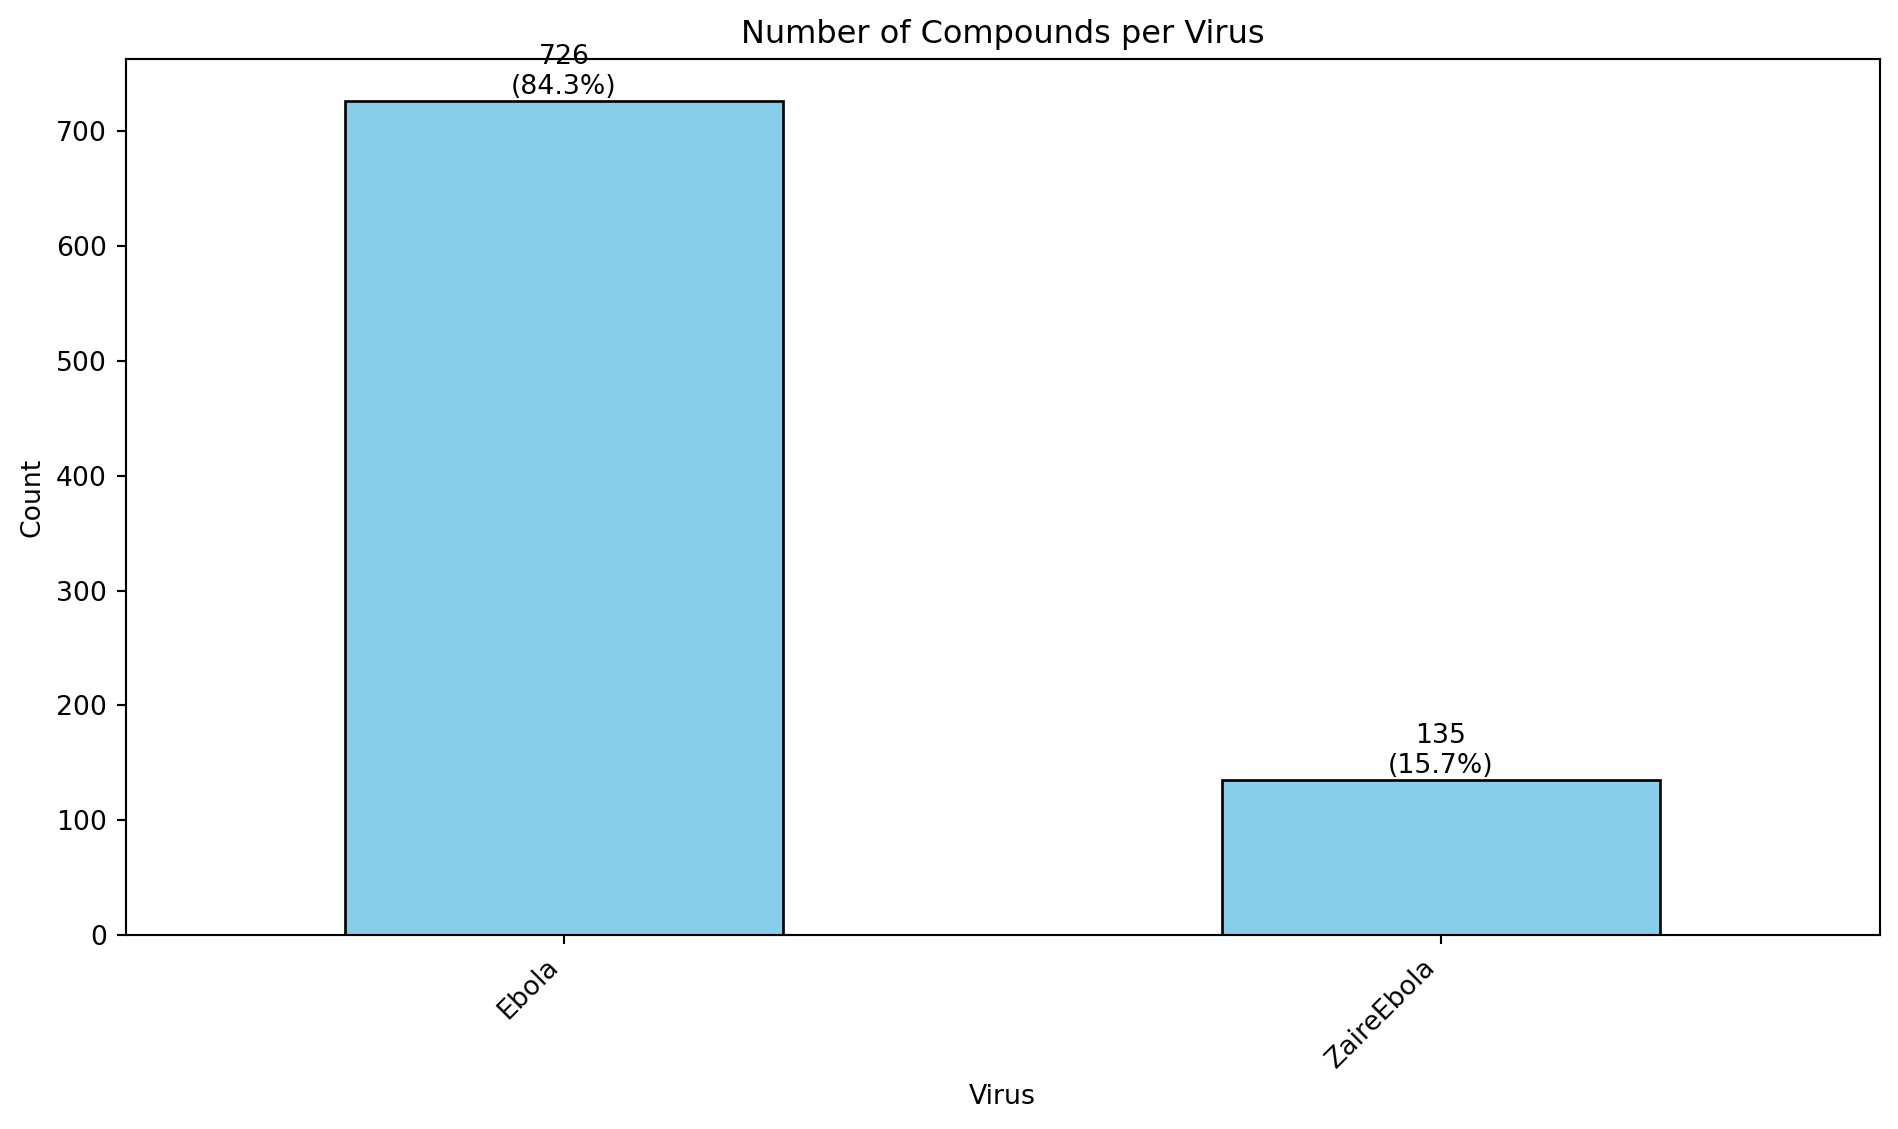

In [391]:
# Get counts and percentages
counts = combinedEbolaVirusData_chEMBL['StrainClassifier'].value_counts()
percentages = counts / counts.sum() * 100

# Create bar plot
plt.figure(figsize=(10, 6))
bars = counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Compounds per Virus')
plt.xlabel('Virus')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with count and %
for i, (count, pct) in enumerate(zip(counts, percentages)):
    plt.text(
        i, count + 1,                 # position (x, y)
        f'{count}\n({pct:.1f}%)',     # label: count + percentage
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

In [392]:
combinedEbolaVirusData_chEMBL.to_csv(os.path.join(modelBuildingDataDir, "combinedEbolaVirusData_chEMBL_MLready.csv"), index=False)

### pPotency value distribution across each Virus

In [393]:
combinedEbolaVirusData_chEMBL_ordered = combinedEbolaVirusData_chEMBL.sort_values(by='StrainClassifier')
combinedEbolaVirusData_chEMBL_ordered.head()

ID    compound_id                                             Smiles  \
13073    1  CHEMBL3596788                       COc1nc(N)ncc1-c1cn(COCCO)cn1   
13553  481  CHEMBL5084473  CCC(CC)COC(=O)[C@@H](C)N[P@](=O)(OC[C@H]1O[C@@...   
13554  482  CHEMBL5290974  COC(=O)[C@H]1C[C@H](OCCN)[C@@H](O[C@H]2O[C@H](...   
13555  483  CHEMBL5287023  CCN(CC)Cc1cc(Nc2c(Oc3ccccc3)cnc3cc(Cl)ccc23)ccc1O   
13556  484      CHEMBL809        CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21   

       pPotency StrainClassifier pPotency_category  
13073     4.000            Ebola              3-10  
13553     6.347            Ebola              3-10  
13554     3.208            Ebola              3-10  
13555     6.137            Ebola              3-10  
13556     5.504            Ebola              3-10

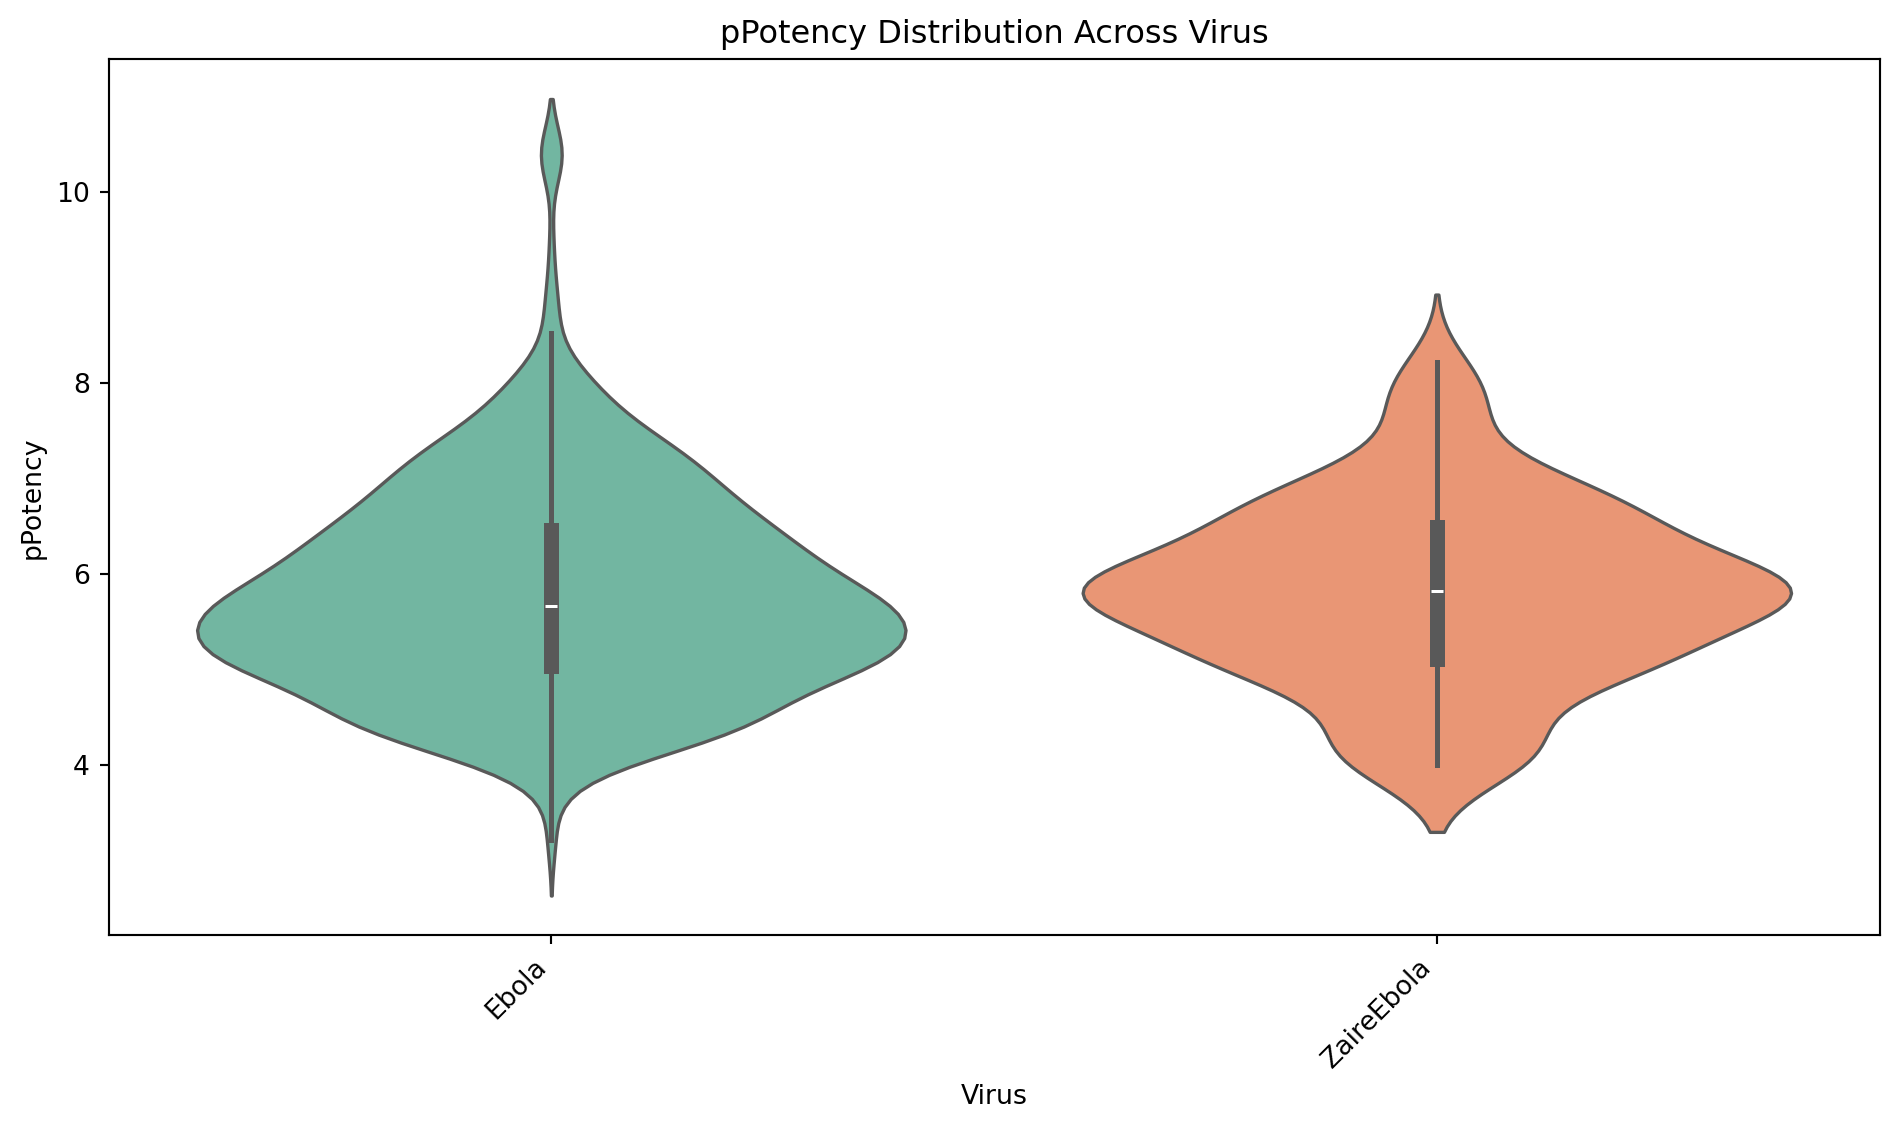

In [394]:
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=combinedEbolaVirusData_chEMBL_ordered,
    x='StrainClassifier',
    y='pPotency',
    palette='Set2',
    inner='box'
)

plt.xticks(rotation=45, ha='right')
plt.title('pPotency Distribution Across Virus')
plt.xlabel('Virus')
plt.ylabel('pPotency')
plt.tight_layout()
plt.show()

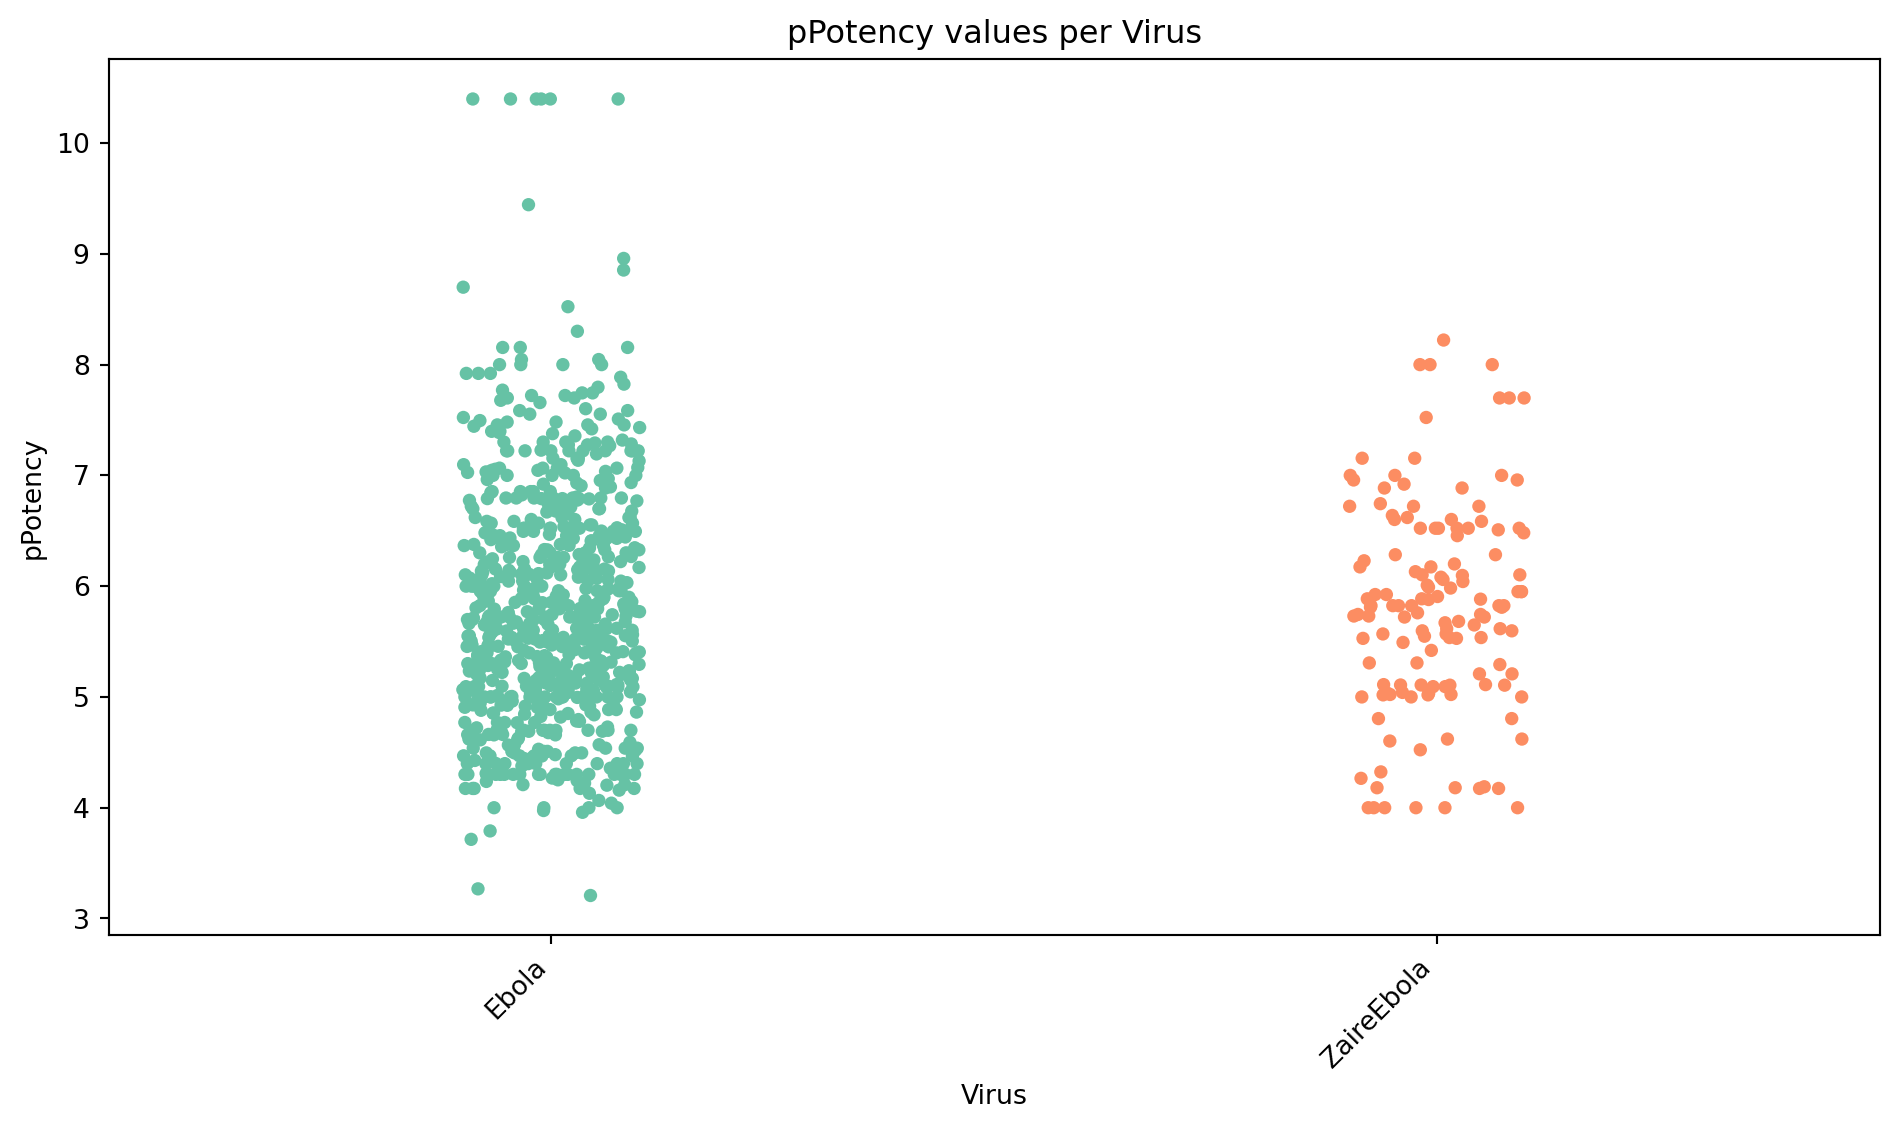

In [395]:
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=combinedEbolaVirusData_chEMBL_ordered,
    x='StrainClassifier',
    y='pPotency',
    jitter=True,          # spreads the dots to avoid overlap
    palette='Set2',
    alpha=1
)
plt.xticks(rotation=45, ha='right')
plt.title('pPotency values per Virus')
plt.xlabel('Virus')
plt.ylabel('pPotency')
plt.tight_layout()
plt.show()

### Create MACAW embeedings to run ART

In [401]:
# ---------------------------
# 1. FIT MACAW AND GENERATE EMBEDDINGS
# ---------------------------
# Initialize MACAW
mcw = MACAW(
    type_fp='atompairs', 
    metric='sokal', 
    n_components=15, 
    n_landmarks=100, 
    random_state=42
)

# Fit MACAW on SMILES and pPotency
mcw.fit(combinedEbolaVirusData_chEMBL['Smiles'], combinedEbolaVirusData_chEMBL['pPotency'])

# Save MACAW transformer
macaw_save_path = os.path.join(modelBuildingDataDir, "combinedEbolaVirusData_chEMBL_MACAW_transformer.pkl")
with open(macaw_save_path, 'wb') as f:
    pickle.dump(mcw, f)
print(f"MACAW transformer saved to: {macaw_save_path}")

# Transform SMILES to get embeddings
macaw_embeddings = mcw.transform(combinedEbolaVirusData_chEMBL['Smiles'])

print(f"MACAW embeddings shape: {macaw_embeddings.shape}")

# ---------------------------
# 2. CREATE DATAFRAME WITH EMBEDDINGS
# ---------------------------
# Convert embeddings to DataFrame with column names
embedding_columns = [f'MACAW_{i+1}' for i in range(macaw_embeddings.shape[1])]
macaw_df = pd.DataFrame(macaw_embeddings, columns=embedding_columns, index=combinedEbolaVirusData_chEMBL.index)

# ---------------------------
# 3. CONCATENATE WITH ORIGINAL DATAFRAME
# ---------------------------
combinedEbolaVirusData_chEMBL_wMACAW = pd.concat([combinedEbolaVirusData_chEMBL, macaw_df], axis=1)

print(f"\nOriginal dataframe shape: {combinedEbolaVirusData_chEMBL.shape}")
print(f"New dataframe shape: {combinedEbolaVirusData_chEMBL_wMACAW.shape}")
print(f"\nNew columns added: {list(macaw_df.columns)}")

# Display first few rows
combinedEbolaVirusData_chEMBL_wMACAW.head()

MACAW transformer saved to: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/modelBuildingData/combinedEbolaVirusData_chEMBL_MACAW_transformer.joblib
MACAW embeddings shape: (861, 15)

Original dataframe shape: (861, 6)
New dataframe shape: (861, 21)

New columns added: ['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


ID    compound_id                                             Smiles  \
13073   1  CHEMBL3596788                       COc1nc(N)ncc1-c1cn(COCCO)cn1   
13074   2  CHEMBL3753489       Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O   
13075   3  CHEMBL4751715  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...   
13076   4  CHEMBL4792617  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...   
13077   5  CHEMBL5085366  CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...   

       pPotency StrainClassifier pPotency_category  MACAW_1  MACAW_2  MACAW_3  \
13073     4.000            Ebola              3-10   -0.105    0.035    0.145   
13074     6.495            Ebola              3-10   -0.069    0.035    0.170   
13075     5.726            Ebola              3-10    0.097   -0.038   -0.027   
13076     5.604            Ebola              3-10    0.115   -0.016   -0.044   
13077     4.301            Ebola              3-10    0.289    0.094   -0.068   

       MACAW_4  ...    MACAW_6   MACAW_7    MACAW_8  MACAW_9  MACAW_10  \
13073   -0.024  ...      0.024 1.088e-05 -2.192e-03    0.037    -0.086   
13074    0.057  ...      0.054    -0.057      0.037    0.027    -0.345   
13075   -0.063  ... -2.715e-03     0.175      0.150    0.160     0.019   
13076   -0.065  ...      0.013     0.199      0.159    0.148 7.526e-03   
13077   -0.029  ...      0.027     0.168      0.172    0.047    -0.017   

       MACAW_11   MACAW_12  MACAW_13   MACAW_14  MACAW_15  
13073    -0.013      0.109     0.017 -4.804e-03     0.028  
13074     0.068      0.179     0.042     -0.210    -0.025  
13075    -0.026  3.961e-03     0.082      0.013    -0.104  
13076    -0.055 -1.373e-03     0.063  7.560e-03    -0.116  
13077 6.151e-03      0.012    -0.086 -8.689e-03    -0.125  

[5 rows x 21 columns]

In [236]:
combinedEbolaVirusData_chEMBL_wMACAW.to_csv(os.path.join(modelBuildingDataDir, "combinedEbolaVirusData_chEMBL_wMACAW.csv"), index=False)

### Clip first 1000 rows from the data set for fast testing

### Train ML Model

In [237]:
# df = combinedEbolaVirusData_chEMBL
Y = combinedEbolaVirusData_chEMBL.pPotency
smiles = combinedEbolaVirusData_chEMBL.Smiles

In [238]:
print(len(smiles))

861


### Normalize the potency data
$$
\begin{align}
\text{value (M)} &= \text{value}_{\mu M} \times 10^{-6} \\
p\text{Potency} &= -\log_{10}(\text{value (M)}) \\
&= 6 - \log_{10}(\text{value}_{\mu M})
\end{align}
$$

so, $$ p\text{Potency} = 6 - \log_{10}(\text{value}_{\mu M}) $$

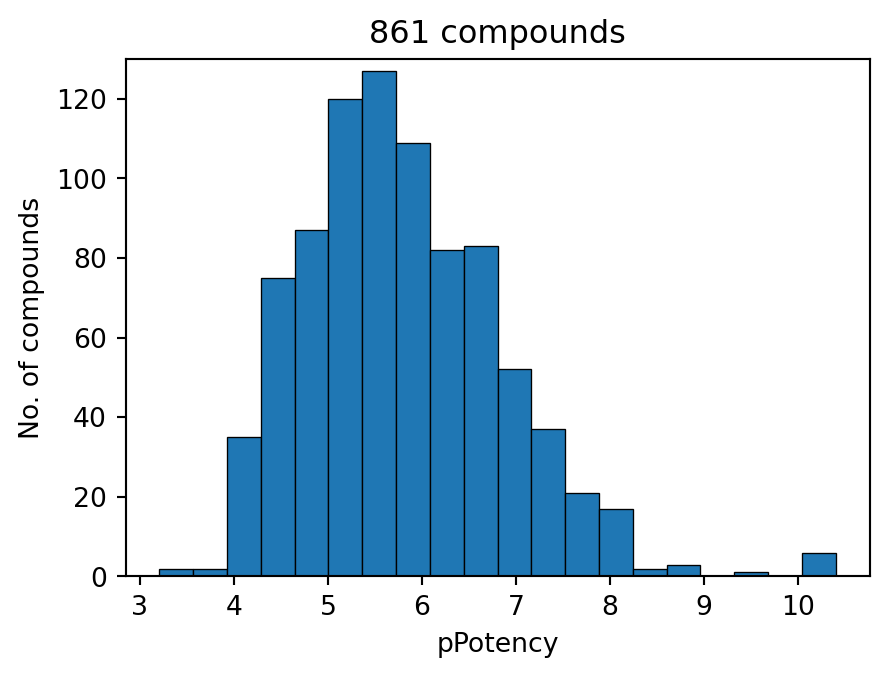

In [239]:
plot_histogram(Y, xlabel="pPotency")

Define the partitions for cross-validation.

In [240]:
num_of_partitions = 10
kf = KFold(n_splits=num_of_partitions, shuffle=True, random_state=42)

Define hyperparameters for SVR:

In [241]:
param_grid = {
    'C': [1, 5, 7, 10, 30, 50, 100, 300, 500], 
    'epsilon': [0.1, 0.3, 1, 3, 5, 10, 20],
    'kernel': ['rbf']
}

Define MACAW embedding:

In [242]:
mcw = MACAW(
    type_fp='atompairs', 
    metric='sokal', 
    n_components=15, 
    n_landmarks=200, 
    random_state=39
)


After cleaning NaN values, reset the indices

In [243]:
valid_mask = Y.notna()
smiles = smiles[valid_mask].reset_index(drop=True)  
Y = Y[valid_mask].reset_index(drop=True)            

print(f"Cleaned data has: {len(smiles)} samples")
print(f"Y index: {Y.index[:10].tolist()}")  

Cleaned data has: 861 samples
Y index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Create directory to save plot

In [244]:
save_path = resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_CV_testOnly.svg'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

### ML predictions with Train + Test results

In [245]:
%%time
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import Parallel, delayed
from copy import deepcopy

def process_fold(fold_id, train_index, test_index, smiles, Y, mcw, param_grid, num_partitions):
    """Process a single CV fold"""
    print(f"Partition {fold_id}/{num_partitions}")
    
    # Split data
    smi_train = smiles.iloc[train_index]
    smi_test = smiles.iloc[test_index]
    y_train = Y[train_index]
    y_test = Y[test_index]
    
    # Compute MACAW embeddings (clone to avoid conflicts)
    mcw_fold = deepcopy(mcw)
    mcw_fold.fit(smi_train, y_train)
    
    X_train = mcw_fold.transform(smi_train)
    X_test = mcw_fold.transform(smi_test)
    
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    
    best_params = grid.best_params_
    
    # Predict on both train and test
    y_cv_pred_train = grid.predict(X_train)
    y_cv_pred_test = grid.predict(X_test)
    
    # Calculate fold metrics
    train_mae = mean_absolute_error(y_train, y_cv_pred_train)
    test_mae = mean_absolute_error(y_test, y_cv_pred_test)
    print(f"  Fold {fold_id} - Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    
    # Return all predictions and parameters
    return {
        'train_pred': y_cv_pred_train,
        'train_obs': y_train,
        'test_pred': y_cv_pred_test,
        'test_obs': y_test,
        'best_params': best_params
    }

# Parallel execution
results = Parallel(n_jobs=4, verbose=10)(
    delayed(process_fold)(
        fold_id=i+1,
        train_index=train_idx,
        test_index=test_idx,
        smiles=smiles,
        Y=Y,
        mcw=mcw,
        param_grid=param_grid,
        num_partitions=num_of_partitions
    )
    for i, (train_idx, test_idx) in enumerate(kf.split(smiles))
)

# Combine results
Y_cv_pred_train = []
Y_obs_train = []
Y_cv_pred_test = []
Y_obs_test = []
best_params_per_fold = []

for fold_result in results:
    Y_cv_pred_train.extend(fold_result['train_pred'])
    Y_obs_train.extend(fold_result['train_obs'])
    Y_cv_pred_test.extend(fold_result['test_pred'])
    Y_obs_test.extend(fold_result['test_obs'])
    best_params_per_fold.append(fold_result['best_params'])

# Convert to numpy arrays
Y_cv_pred_train = np.array(Y_cv_pred_train)
Y_obs_train = np.array(Y_obs_train)
Y_cv_pred_test = np.array(Y_cv_pred_test)
Y_obs_test = np.array(Y_obs_test)

# ===== OVERALL METRICS =====
print("\n" + "-"*40)
print("Cross Validation Metrics")
print("-"*40)

# Train metrics
train_mae = mean_absolute_error(Y_obs_train, Y_cv_pred_train)
train_rmse = np.sqrt(mean_squared_error(Y_obs_train, Y_cv_pred_train))
train_r2 = r2_score(Y_obs_train, Y_cv_pred_train)

print(f"Train Set:")
print(f"  MAE:  {train_mae:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  R²:   {train_r2:.2f}")

# Test metrics
test_mae = mean_absolute_error(Y_obs_test, Y_cv_pred_test)
test_rmse = np.sqrt(mean_squared_error(Y_obs_test, Y_cv_pred_test))
test_r2 = r2_score(Y_obs_test, Y_cv_pred_test)

print(f"Test Set:")
print(f"  MAE:  {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R²:   {test_r2:.2f}")

print(f"\nBest params (sample): {best_params_per_fold[:3]}")


----------------------------------------
Cross Validation Metrics
----------------------------------------
Train Set:
  MAE:  0.41
  RMSE: 0.56
  R²:   0.72
Test Set:
  MAE:  0.49
  RMSE: 0.66
  R²:   0.62

Best params (sample): [{'C': 7, 'epsilon': 0.3, 'kernel': 'rbf'}, {'C': 5, 'epsilon': 0.3, 'kernel': 'rbf'}, {'C': 1, 'epsilon': 0.3, 'kernel': 'rbf'}]
CPU times: user 252 ms, sys: 129 ms, total: 381 ms
Wall time: 15.8 s


Saved: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_CV_TrTs.svg
Saved: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_CV_TrTs.png


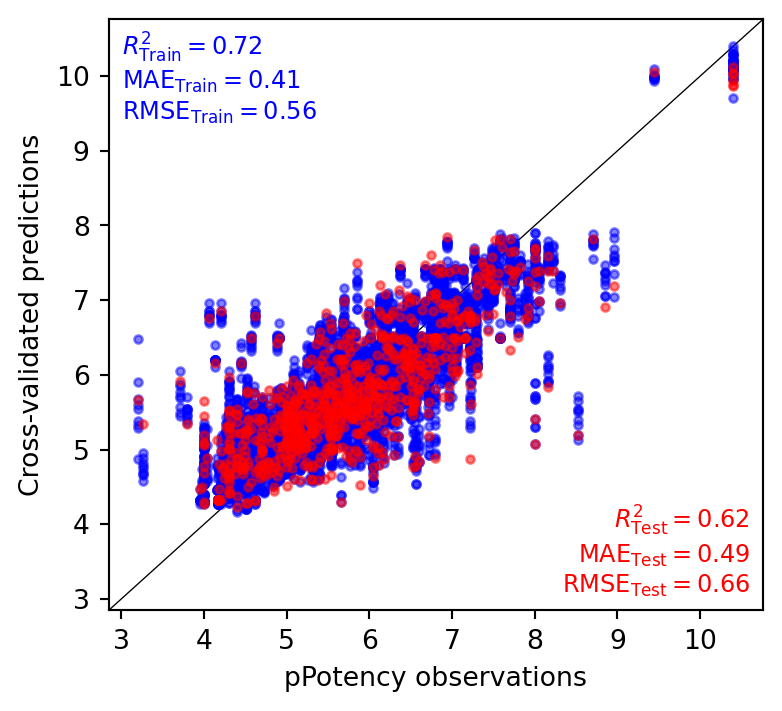

In [246]:
parity_plot(x=Y_obs_train, 
            y=Y_cv_pred_train, 
            x_test=Y_obs_test, 
            y_test=Y_cv_pred_test, 
            xlabel="pPotency observations", 
            ylabel="Cross-validated predictions",
            savetitle=resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_CV_TrTs.svg',
            save_formats=['svg', 'png'])

Generate a model trained on the whole data set, to be used for prediction tasks

In [247]:
mcw = MACAW(
    type_fp='atompairs', 
    metric='sokal', 
    n_components=15, 
    n_landmarks=200, 
    random_state=39
)
mcw.fit(smiles, Y)

In [248]:
X_all = mcw.transform(smiles)
X_all.shape

(861, 15)

Training samples: 688
Test samples: 173
Feature dimensions: 15

Running GridSearchCV with 4 parallel jobs...

------------------------------------------------------------
Best Hyperparameters:
------------------------------------------------------------
  C: 10
  epsilon: 0.1
  kernel: rbf

Best CV MAE (on training folds): 0.49

------------------------------------------------------------
PERFORMANCE COMPARISON:
------------------------------------------------------------
Metric     Training        Test            Difference     
------------------------------------------------------------
R²         0.77            0.42            0.35           
MAE        0.35            0.48            0.13           
RMSE       0.53            0.71            0.18           
------------------------------------------------------------


Saved: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_fullData_TrTs.svg
Saved: /mnt/data.ese/nfs/u

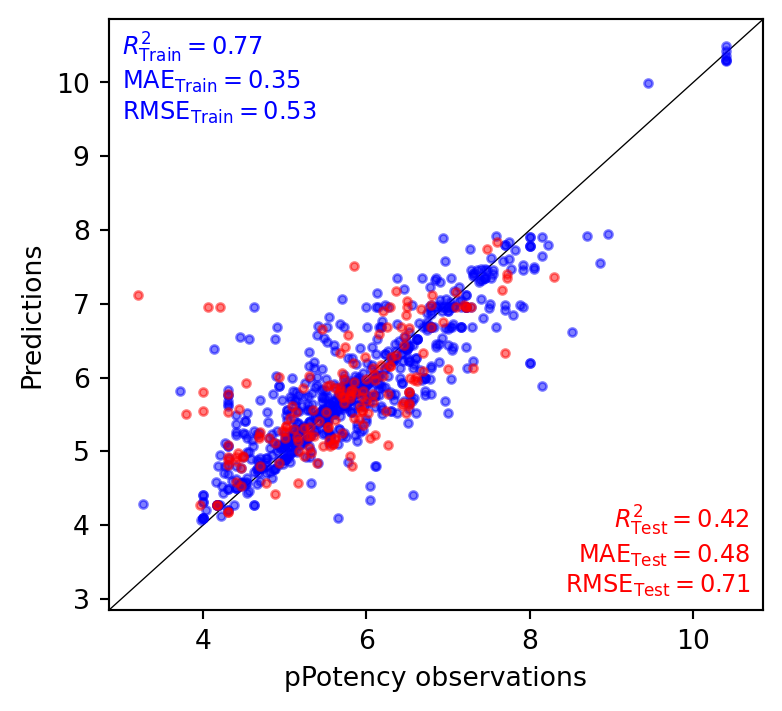

CPU times: user 1.24 s, sys: 35.8 ms, total: 1.27 s
Wall time: 2.49 s


In [249]:
%%time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ---------------------------
# 1. TRAIN-TEST SPLIT
# ---------------------------
# Since you're working with only one virus group, use regular train_test_split
X_train_smi, X_test_smi, Y_train, Y_test = train_test_split(
    smiles, Y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"Training samples: {len(X_train_smi)}")
print(f"Test samples: {len(X_test_smi)}")

# ---------------------------
# 2. FIT MACAW ON TRAINING DATA ONLY
# ---------------------------
mcw = MACAW(
    type_fp='atompairs', 
    metric='sokal', 
    n_components=15, 
    n_landmarks=200, 
    random_state=39
)
mcw.fit(X_train_smi, Y_train)

# Transform both train and test
X_train = mcw.transform(X_train_smi)
X_test = mcw.transform(X_test_smi)

print(f"Feature dimensions: {X_train.shape[1]}")

# ---------------------------
# 3. GRID SEARCH ON TRAINING DATA ONLY
# ---------------------------
n_jobs = 4

regr_pred = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=5,
    refit=True,
    n_jobs=n_jobs,
    verbose=0,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    pre_dispatch='2*n_jobs'
)

print(f"\nRunning GridSearchCV with {n_jobs} parallel jobs...")
regr_pred.fit(X_train, Y_train)

# ---------------------------
# 4. DISPLAY BEST HYPERPARAMETERS
# ---------------------------
print("\n" + "-"*60)
print("Best Hyperparameters:")
print("-"*60)
for param, value in regr_pred.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV MAE (on training folds): {-regr_pred.best_score_:.2f}")

# ---------------------------
# 5. PREDICTIONS AND METRICS
# ---------------------------
# Training predictions (in-sample)
y_train_pred = regr_pred.predict(X_train)

# Test predictions (held-out)
y_test_pred = regr_pred.predict(X_test)

# Calculate metrics for TRAIN
train_r2 = r2_score(Y_train, y_train_pred)
train_mae = mean_absolute_error(Y_train, y_train_pred)
train_rmse = np.sqrt(np.mean((Y_train - y_train_pred)**2))

# Calculate metrics for TEST
test_r2 = r2_score(Y_test, y_test_pred)
test_mae = mean_absolute_error(Y_test, y_test_pred)
test_rmse = np.sqrt(np.mean((Y_test - y_test_pred)**2))

# ---------------------------
# 6. DISPLAY RESULTS
# ---------------------------
print("\n" + "-"*60)
print("PERFORMANCE COMPARISON:")
print("-"*60)
print(f"{'Metric':<10} {'Training':<15} {'Test':<15} {'Difference':<15}")
print("-"*60)
print(f"{'R²':<10} {train_r2:<15.2f} {test_r2:<15.2f} {abs(train_r2-test_r2):<15.2f}")
print(f"{'MAE':<10} {train_mae:<15.2f} {test_mae:<15.2f} {abs(train_mae-test_mae):<15.2f}")
print(f"{'RMSE':<10} {train_rmse:<15.2f} {test_rmse:<15.2f} {abs(train_rmse-test_rmse):<15.2f}")
print("-"*60)

# Check for overfitting
overfit_gap = train_r2 - test_r2
if overfit_gap > 0.1:
    print("\n  WARNING: Possible overfitting detected (R² gap > 0.1)")
elif test_r2 >= 0.7:
    print("\n Good generalization performance!")

print("\n" + "="*60)

# ---------------------------
# 7. GENERATE PARITY PLOT
# ---------------------------
parity_plot(
    x=Y_train,                      # observed train
    y=y_train_pred,                 # predicted train (in-sample)
    x_test=Y_test,                  # observed test
    y_test=y_test_pred,             # predicted test (held-out)
    xlabel="pPotency observations",
    ylabel="Predictions",
    savetitle=resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_fullData_TrTs.svg',
    save_formats=['svg', 'png']
)

### Compare performance of different ML model

- SVR
- Random Forest
- XGBoost
- LightGBM
- CatBoost
- Neural Network

Import all necessary libraries

## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [250]:
EnamineAntiviralsData = pd.read_csv(dataDir + "Enamine/Enamine_Antiviral_Library_plated_3200cmpds_20251019.csv",
                                    sep=",", comment=None, skipinitialspace=True, engine="python", encoding="utf-8",          
                                    skiprows=1, skip_blank_lines=True)
print(f"Original Enamine data shape: {EnamineAntiviralsData.shape}")

smiles_train = combinedEbolaVirusData_chEMBL.Smiles

# Function to canonicalize SMILES using RDKit
def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            return Chem.MolToSmiles(mol, canonical=True)
        else:
            return None
    except:
        return None

# Canonicalize training SMILES and create a set for fast lookup
canonical_train = set()
for smi in smiles_train:
    canonical_smi = canonicalize_smiles(smi)
    if canonical_smi is not None:
        canonical_train.add(canonical_smi)

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to Enamine data
EnamineAntiviralsData['Canonical_SMILES'] = EnamineAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~EnamineAntiviralsData['Canonical_SMILES'].isin(canonical_train)
EnamineAntiviralsData_filtered = EnamineAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
EnamineAntiviralsData = EnamineAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered Enamine data shape for validation: {EnamineAntiviralsData.shape}")
print(f"Removed {EnamineAntiviralsData.shape[0] - EnamineAntiviralsData_filtered.shape[0]} duplicate compounds from Enamine data set")

# Now use the filtered data
smi_lib = EnamineAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
EnamineAntiviralsData.head()

Original Enamine data shape: (3200, 11)
Number of unique SMILES in training set: 540
Filtered Enamine data shape for validation: (3200, 11)
Removed 0 duplicate compounds from Enamine data set
Total compounds to screen: 3200


SMILES  Catalog ID      MW  MW (desalted)  \
0        COCC(C)NC(=O)NC1=NN=C(S1)C2CC2  Z410227912 256.326        256.326   
1       CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O  Z383167688 237.256        237.256   
2    CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2  Z235579208 306.404        306.404   
3     CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2  Z403694008 279.379        279.379   
4  CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2  Z384461492 307.389        307.389   

   ClogP   logS  HBD  HBA   TPSA  RotBonds  \
0  1.231 -2.190    2    4 76.140         5   
1 -0.042 -0.692    1    3 69.720         5   
2  1.583 -2.082    1    5 57.700         7   
3  1.156 -0.660    1    3 58.370         7   
4  1.084 -1.180    1    4 61.880         7   

                                     AnalogsFromREAL  
0  https://real.enamine.net/public-enum-files/Z41...  
1  https://real.enamine.net/public-enum-files/Z38...  
2                                                NaN  
3  https://real.enamine.net/public-enum-files/Z40...  
4  https://real.enamine.net/public-enum-files/Z38...

Generate predictions for the H1 receptor:

In [251]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [252]:
EnamineAntiviralsData_predicted = EnamineAntiviralsData.copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
EnamineAntiviralsData_predicted['pPotency(M)_prediction'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_prediction'])

EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction",  "pPotency(M)_prediction"]
)
EnamineAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_EnamineDatasets_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_EnamineDatasets_predicted_all_SMILES.csv"), index=False)
EnamineAntiviralsData_predicted

SMILES  pPotency_prediction  \
0               COCC(C)NC(=O)NC1=NN=C(S1)C2CC2                5.547   
1              CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O                5.876   
2           CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2                5.297   
3            CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2                5.435   
4         CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2                6.019   
...                                        ...                  ...   
3195        CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23                5.581   
3196   CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C                5.810   
3197        CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O                5.519   
3198   CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C                5.388   
3199  CCC1(C)CN(CCO1)C(=O)NCC(C)(C)C=2C=CN=CC2                5.869   

      pPotency(M)_prediction  
0                  2.835e-06  
1                  1.331e-06  
2                  5.043e-06  
3                  3.670e-06  
4                  9.583e-07  
...                      ...  
3195               2.624e-06  
3196               1.548e-06  
3197               3.027e-06  
3198               4.089e-06  
3199               1.351e-06  

[3200 rows x 3 columns]

Let us represent the predictions of both models:

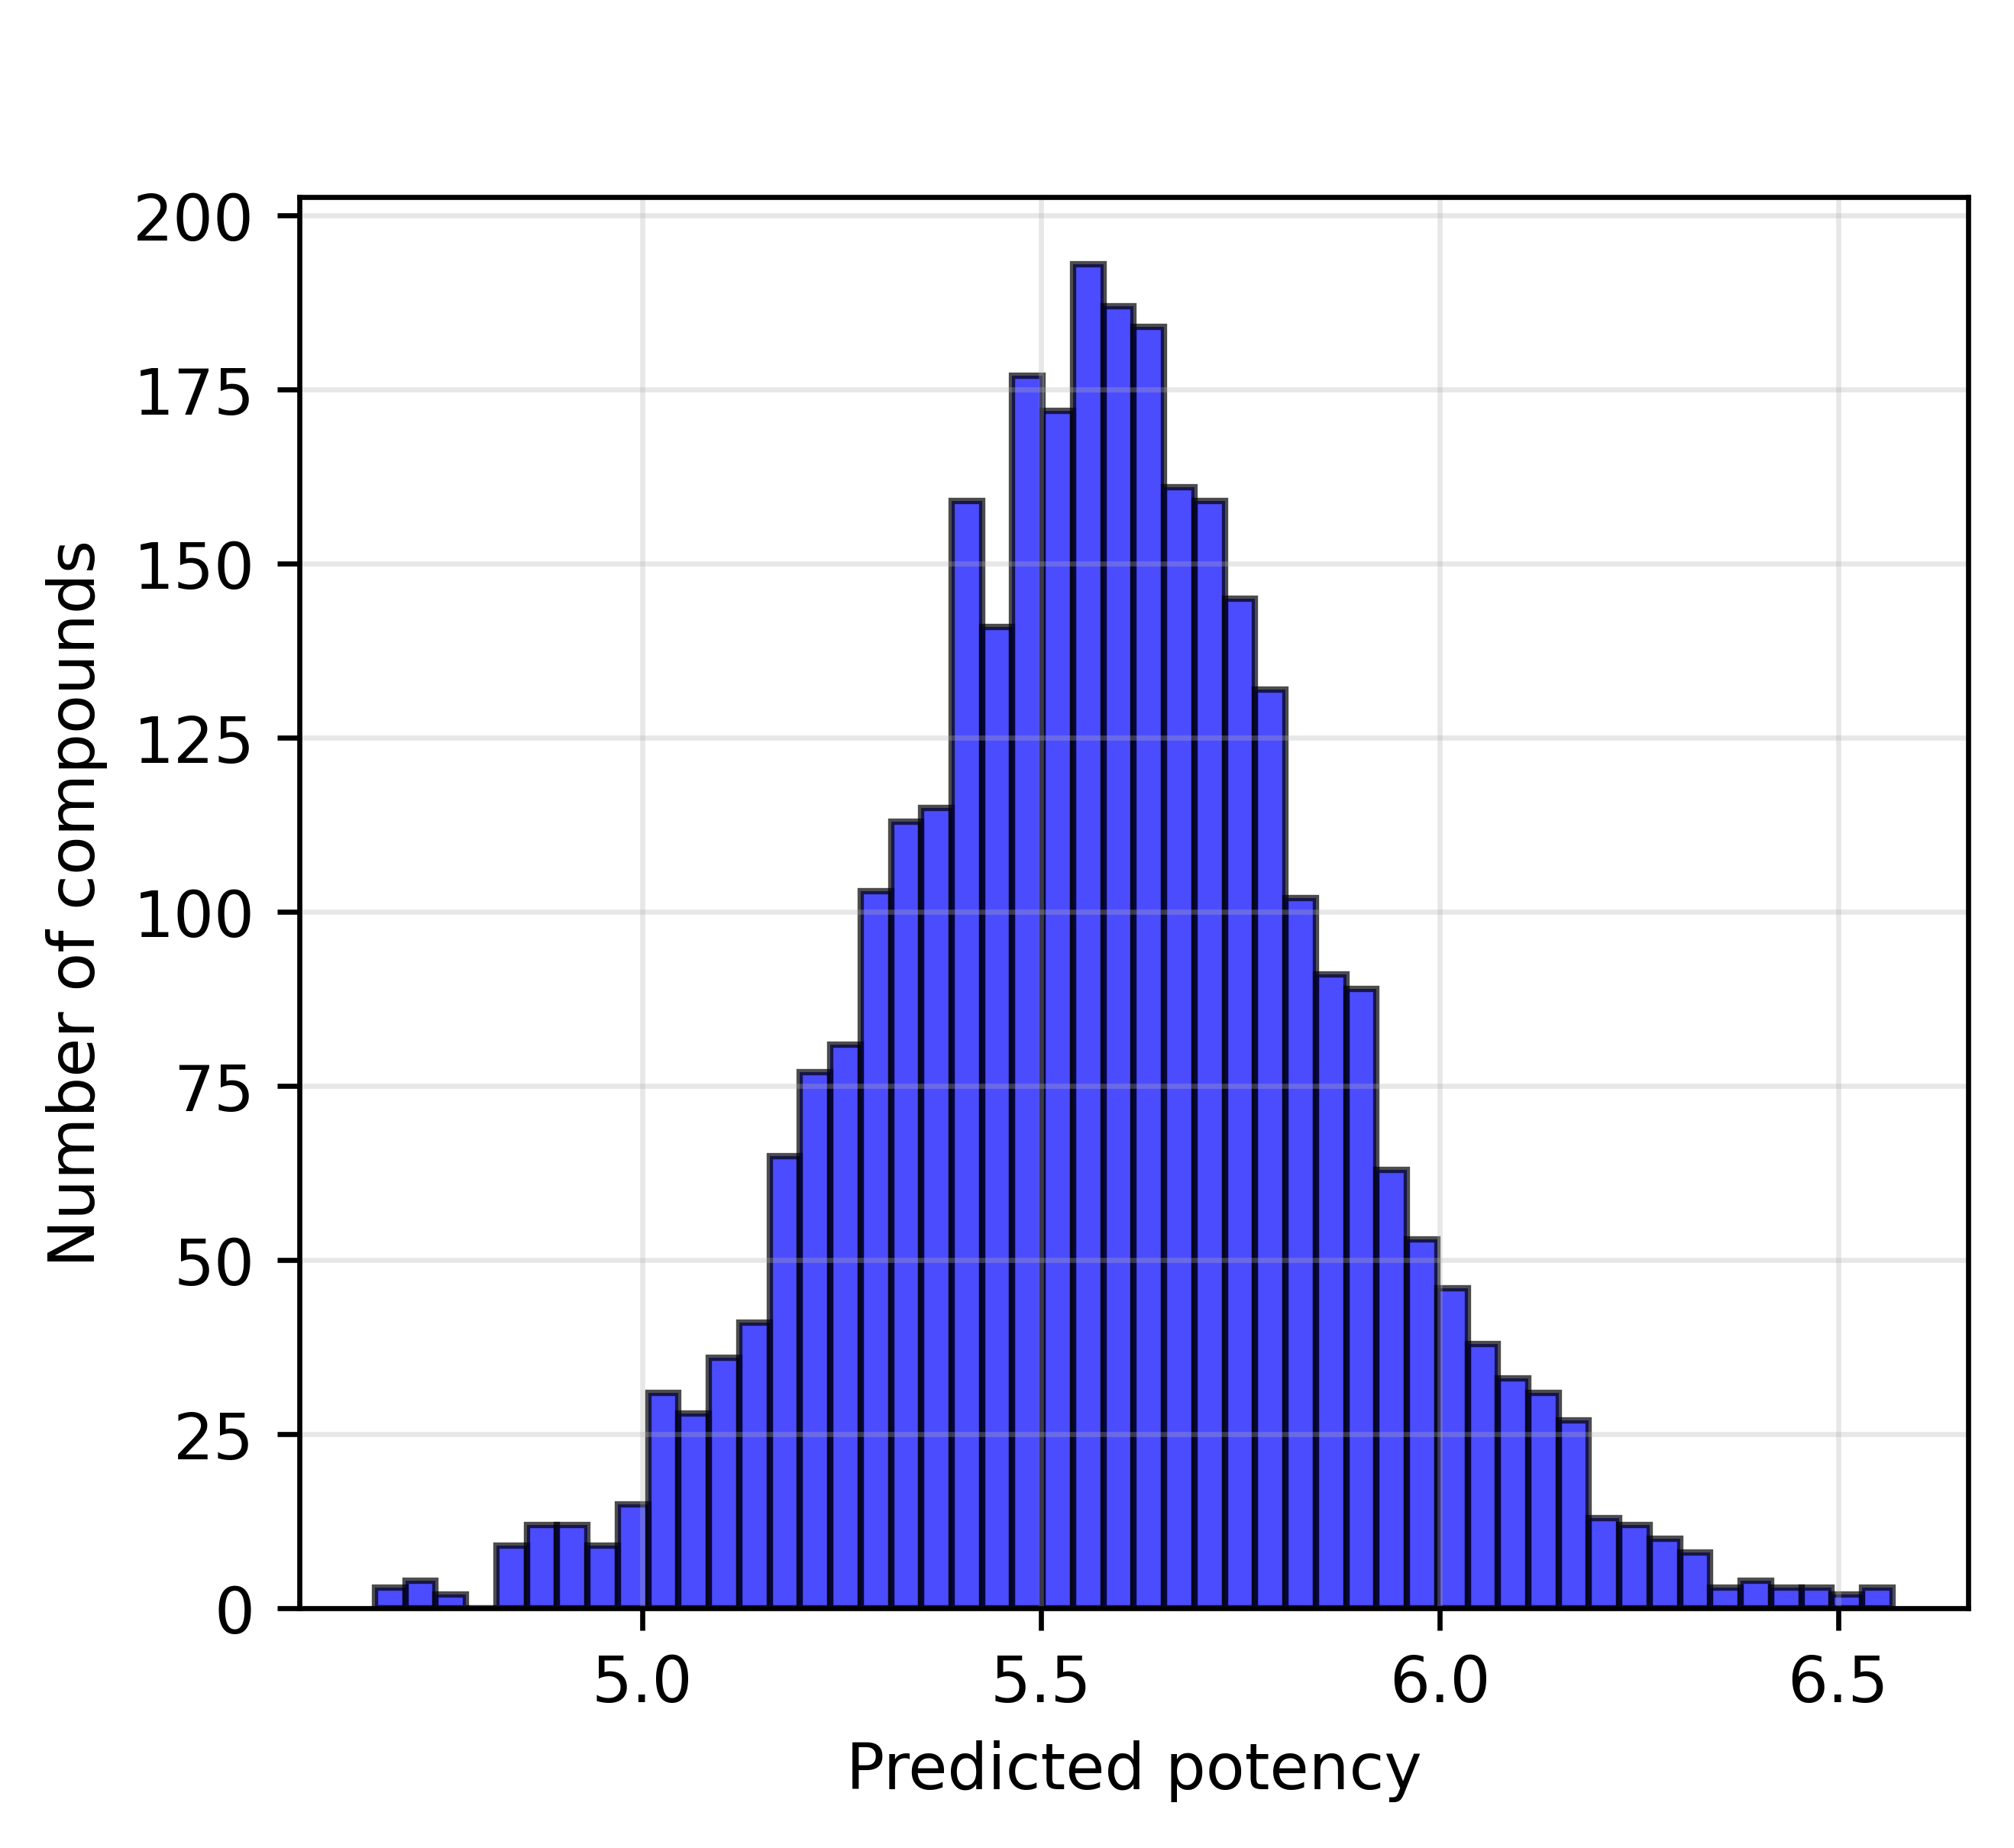

In [253]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_validation.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_validation.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [254]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 0 compounds
Medium priority (6 ≤ pPotency < 7.0): 234 compounds
Low priority (5 ≤ pPotency < 6): 2906 compounds


In [255]:
EnamineAntiviralsData_final = EnamineAntiviralsData.iloc[idx].copy()
EnamineAntiviralsData_final['pPotency_prediction'] = Y1_lib_pred[idx]

EnamineAntiviralsData_final

Empty DataFrame
Columns: [SMILES, Catalog ID, MW, MW (desalted), ClogP, logS, HBD, HBA, TPSA, RotBonds, AnalogsFromREAL, pPotency_prediction]
Index: []

### Top 20 compounds with higher PpPotency

In [256]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

Top 20 compounds cutoff pPotency: 6.32
Highest predicted pPotency: 6.57
Range of top 20: 6.32 - 6.57


In [257]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
EnamineAntiviralsData_top20 = EnamineAntiviralsData.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
EnamineAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
EnamineAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
EnamineAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
EnamineAntiviralsData_top20 = EnamineAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
EnamineAntiviralsData_top20

----------------------------------------------------------------------
Top 20 Compounds with Highest Predicted pPotency
----------------------------------------------------------------------

Cutoff Values (20th ranked compound):
  pPotency:    6.323
  IC50:        4.749e-07 M  (474.87 nM)

Best Values (1st ranked compound):
  pPotency:    6.568
  IC50:        2.704e-07 M  (270.41 nM)
Range for Top 20 Compounds:
pPotency Range:  6.323 - 6.568

IC50 Range (M):  4.749e-07 - 2.704e-07


Rank                                             SMILES  \
1900     1          CC=1C=CN(CC(=O)NCC2CN(CC(C)C)CCO2)C(=O)C1   
545      2         CC(C)CN1CCOC(CNC(=O)CN2C=CC(=O)N(C)C2=O)C1   
779      3       CC(NC(=O)CN1C=C(C=CC1=O)C(F)(F)F)C2CC3CCC2C3   
2369     4        CC(C#N)(NC(=O)CN1C=C(C=CC1=O)C(F)(F)F)C2CC2   
2420     5  CC1(C)C2CCC1(C)C(C2)NC(=O)CN3C=C(C=CC3=O)[N+](...   
593      6            CC1=CC=CN(CC(=O)NCC2CN(CC(C)C)CCO2)C1=O   
567      7         CC1(C)C2CCC1(C)C(C2)NC(=O)CN3C=CC(=O)NC3=O   
178      8      CC1CCC(CC1)NC(=O)CN2C(=O)C(C#N)=CN(C2=O)C3CC3   
575      9      CNC(=O)C=1C=CC(=O)N(C1)CC(=O)NC(C)C2CC3CCC2C3   
2937    10          CC(C)CN1CCC(CC1)NC(=O)CN2C=CC(=O)N(C)C2=O   
110     11         CC(C)C(CNC(=O)CN1C=CC(=O)N(C)C1=O)N2CCOCC2   
1004    12   CC(NC(=O)CN1C=CC=C(C(=O)N(C)C(C)C2CC2)C1=O)C3CC3   
873     13           CC(NC(=O)CN1C=C(C=CC1=O)C(F)(F)F)C2CCCO2   
1859    14          CC=1C=CN(CC(=O)NC(C)(C#N)C2CC2)C(=O)C1C#N   
1886    15           O=C(CN1C=C(C=CC1=O)C(F)(F)F)NCC2CCC(O)C2   
814     16          CC1(C)CN(CCC1C(F)(F)F)C(=O)NCCC2=CC=CN=C2   
220     17          CC=1C=CC(=CN1)CCNC(=O)NC2CCCC(C2)C(F)(F)F   
549     18         CC(CNC(=O)CN1C=C(C=CC1=O)C(F)(F)F)N2CCOCC2   
1589    19   CC(NC(=O)CN1C=C(C=CC1=O)[N+]([O-])=O)C2CC3CCC2C3   
1705    20    CCC(NC(=O)CN1C=CC(=O)NC1=O)C23CC4CC(CC(C4)C3)C2   

      pPotency_prediction  IC50 (M)  
1900                6.568 2.704e-07  
545                 6.561 2.750e-07  
779                 6.543 2.862e-07  
2369                6.509 3.100e-07  
2420                6.500 3.165e-07  
593                 6.465 3.425e-07  
567                 6.462 3.451e-07  
178                 6.455 3.508e-07  
575                 6.446 3.580e-07  
2937                6.440 3.627e-07  
110                 6.431 3.706e-07  
1004                6.407 3.919e-07  
873                 6.396 4.017e-07  
1859                6.391 4.060e-07  
1886                6.391 4.065e-07  
814                 6.361 4.355e-07  
220                 6.360 4.361e-07  
549                 6.349 4.477e-07  
1589                6.335 4.626e-07  
1705                6.323 4.749e-07

In [258]:
EnamineAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_EnamineAntiviralsData_top20.csv"), index=False)
EnamineAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_EnamineAntiviralsData_top20_SMILES.csv"), index=False)

 Saved PNG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_enamine_predictedCompounds.png
 Saved SVG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_enamine_predictedCompounds.svg


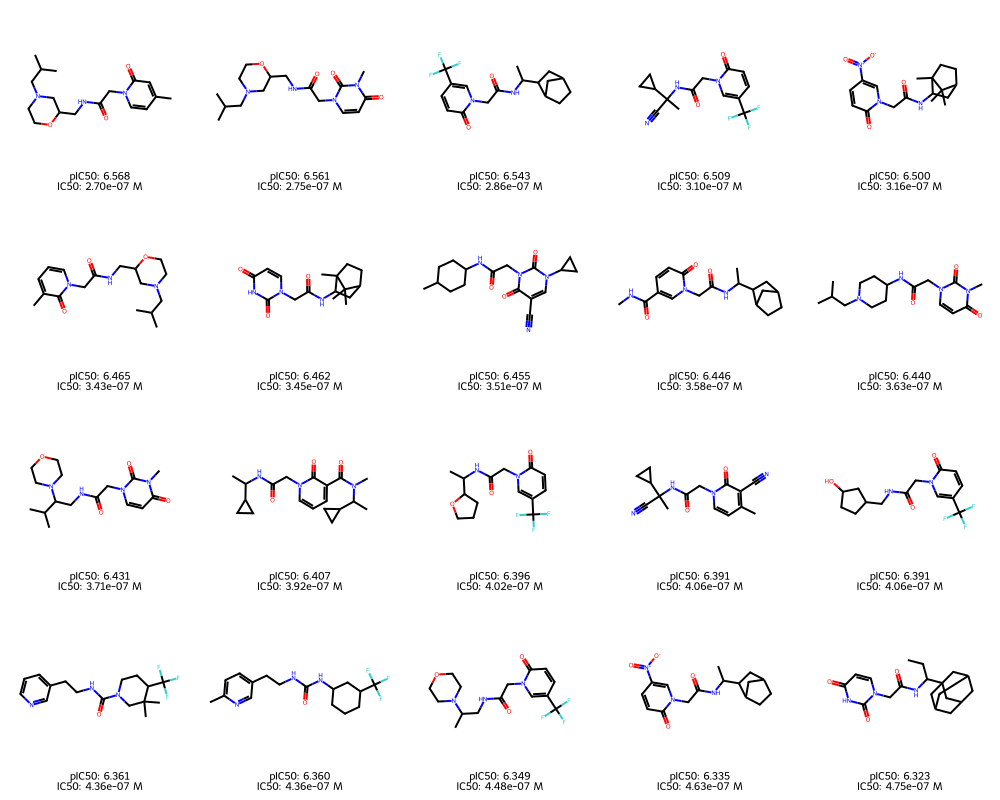

In [259]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image

# Setup paths
output_dir = resultsDir + 'combinedEbolaVirus/'
os.makedirs(output_dir, exist_ok=True)

# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in EnamineAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in EnamineAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = output_dir + 'combinedEbolaVirus_enamine_predictedCompounds.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = output_dir + 'combinedEbolaVirus_enamine_predictedCompounds.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

## 2.2 Discovery of new hits specific to all viruses (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [260]:
# Read all molecules from SDF
supplier = Chem.SDMolSupplier(dataDir + "LifeChemicals/LC_Merged_Antiviral_Screening_Superset.sdf")
mols = [mol for mol in supplier if mol is not None]

# Extract properties into DataFrame
records = []
for mol in mols:
    props = mol.GetPropsAsDict()
    props["SMILES"] = Chem.MolToSmiles(mol)
    records.append(props)

LCAntiviralsData_superset = pd.DataFrame(records)
print(f"Original LifeChemicals data shape: {LCAntiviralsData_superset.shape}")

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to LifeChemicals data (reusing canonical_train from code-1)
LCAntiviralsData_superset['Canonical_SMILES'] = LCAntiviralsData_superset['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~LCAntiviralsData_superset['Canonical_SMILES'].isin(canonical_train)
LCAntiviralsData_superset_filtered = LCAntiviralsData_superset[mask].copy()

# Remove the helper column if you don't need it
LCAntiviralsData_superset = LCAntiviralsData_superset_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered LifeChemicals data shape for validation: {LCAntiviralsData_superset.shape}")
print(f"Removed {LCAntiviralsData_superset_filtered.shape[0] - LCAntiviralsData_superset.shape[0]} duplicate compounds from LifeChemicals data set")

# Now use the filtered data
smi_lib = LCAntiviralsData_superset.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
LCAntiviralsData_superset.head()

Original LifeChemicals data shape: (45573, 17)
Number of unique SMILES in training set: 540
Filtered LifeChemicals data shape for validation: (45573, 17)
Removed 0 duplicate compounds from LifeChemicals data set
Total compounds to screen: 45573


IDNUMBER                                      Chemical_Name  \
0  F6544-0534  11-(oxan-4-yl)-7,11-diazatricyclo[7.3.1.0²,⁷]t...   
1  F6559-5304  6-[4-(trifluoromethyl)pyrimidin-2-yl]-6-azaspi...   
2  F6610-6619    1-methyl-4-[(pyridin-4-yl)methyl]-1,4-diazepane   
3  F6559-5274  6-(4,6-dimethylpyrimidin-2-yl)-6-azaspiro[3.4]...   
4  F1912-1536  N-cyclopropyl-N-(piperidin-4-yl)pyrimidin-4-amine   

            CAS  PriceCoeff      MW Description  FSP3  clogP   TPSA Acceptor  \
0  2034607-75-3       1.500 274.360       solid 0.690 -0.120 32.780        2   
1  2034225-11-9       1.500 301.260       solid 0.620  2.030 66.320        4   
2  2320860-02-2       1.000 205.300         oil 0.580  0.890 19.370        3   
3  2034225-08-4       1.500 261.320         oil 0.640  2.090 66.320        4   
4  1781768-10-2       1.500 218.290       solid 0.670  0.790 41.050        2   

  Donor  RotBonds    HAC Collection  \
0     1         1 20.000   Advanced   
1     1         2 21.000   Advanced   
2     3         2 15.000    General   
3     1         2 19.000   Advanced   
4     2         3 16.000   Advanced   

                                             Library PPDS  \
0              Anti-Hepatitis_A_B_ Screening_Library        
1           2019-nCoV_Main_Protease_Targeted_Library    +   
2                           Anti-HIV_Focused_Library        
3  Antiviral_Screening_Compound_Library_2D_Simila...        
4  Antiviral_Screening_Compound_Library_2D_Simila...        

                                   SMILES  
0      Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1  
1  O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2  
2                   CN1CCCN(Cc2ccncc2)CC1  
3    Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1  
4              c1cc(N(C2CCNCC2)C2CC2)ncn1

Generate predictions for the H1 receptor:

In [261]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [262]:
LCAntiviralsData_predicted = LCAntiviralsData_superset.copy()
LCAntiviralsData_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
LCAntiviralsData_predicted['pPotency(M)_prediction'] = 10 ** (-LCAntiviralsData_predicted['pPotency_prediction'])

LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction",  "pPotency(M)_prediction"]
)
LCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_LCDatasets_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_LCDatasets_predicted_all_SMILES.csv"), index=False)
LCAntiviralsData_predicted

SMILES  pPotency_prediction  \
0                     Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1                5.407   
1                 O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2                5.493   
2                                  CN1CCCN(Cc2ccncc2)CC1                4.970   
3                   Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1                5.196   
4                             c1cc(N(C2CCNCC2)C2CC2)ncn1                5.337   
...                                                  ...                  ...   
45568  CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...                5.327   
45569  CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....                5.252   
45570    COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl                5.631   
45571  CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...                5.916   
45572  CCN1/C(=C/C2=CC3=C/C(=C/c4sc5ccc(SC)cc5[n+]4CC...                6.030   

       pPotency(M)_prediction  
0                   3.913e-06  
1                   3.215e-06  
2                   1.072e-05  
3                   6.368e-06  
4                   4.605e-06  
...                       ...  
45568               4.713e-06  
45569               5.599e-06  
45570               2.341e-06  
45571               1.214e-06  
45572               9.339e-07  

[45573 rows x 3 columns]

Let us represent the predictions of both models:

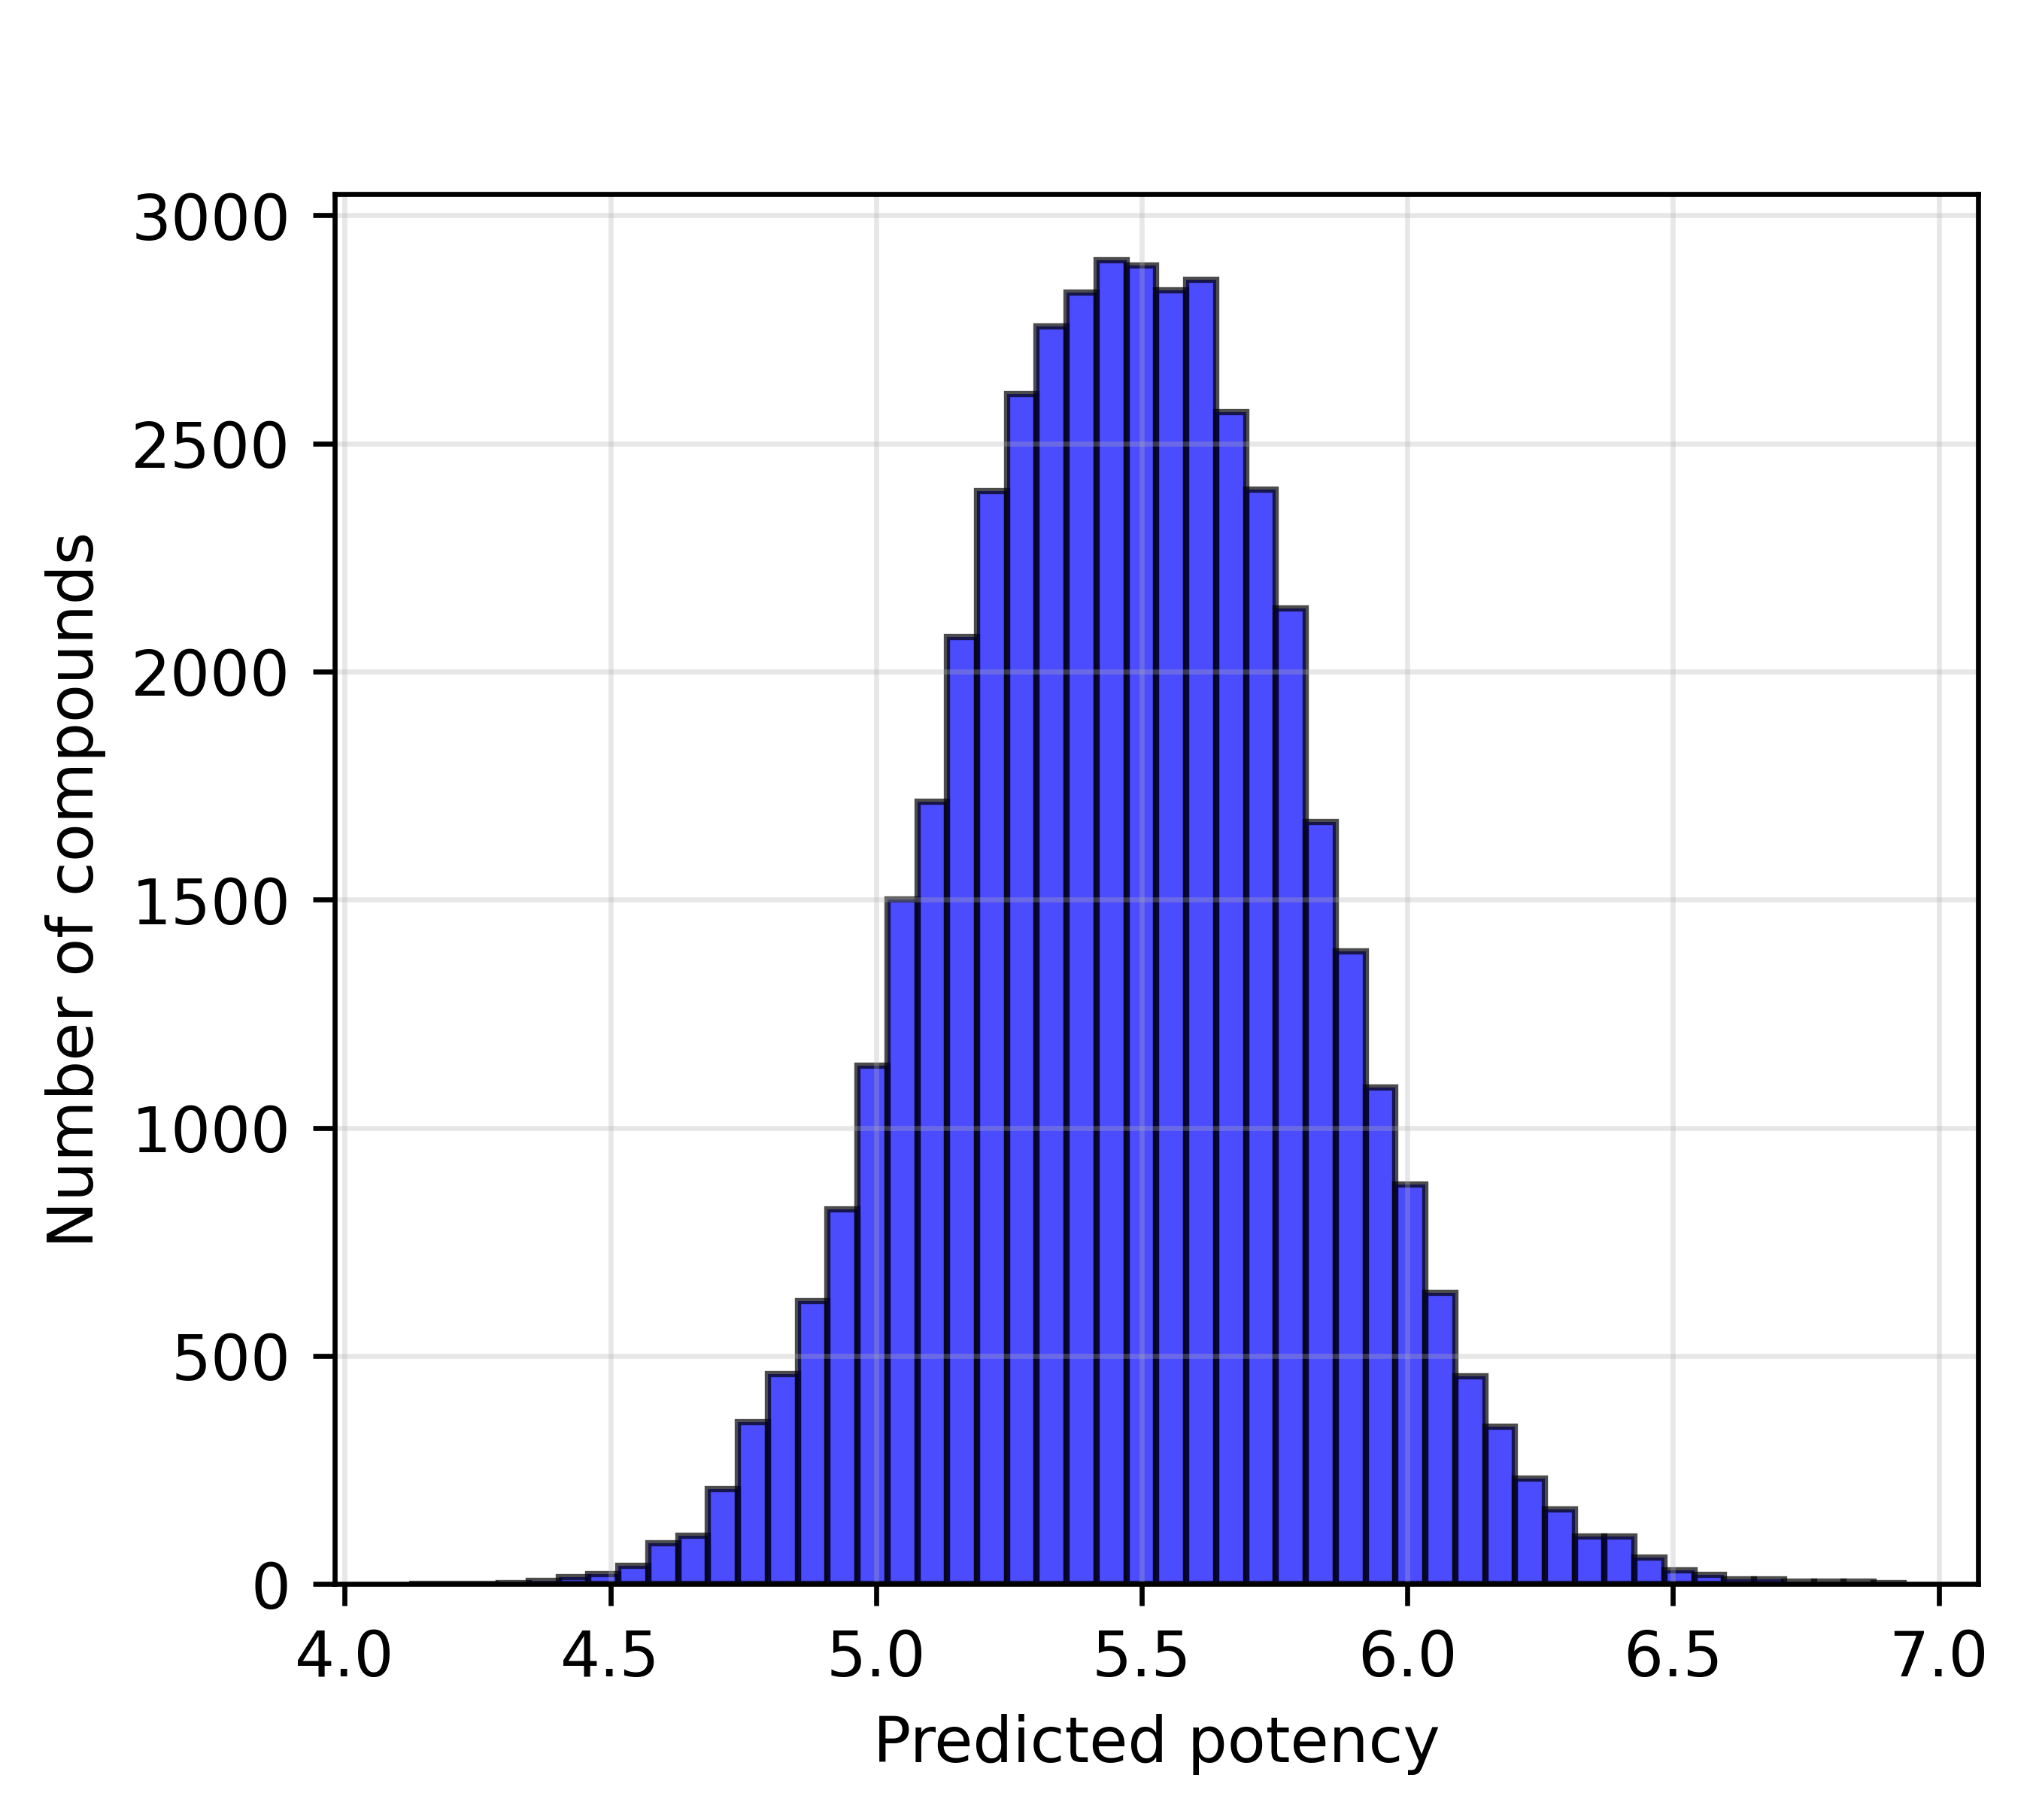

In [263]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_validation_LCDatasets.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_validation_LCDatasets.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [264]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 0 compounds
Medium priority (6 ≤ pPotency < 7.0): 2701 compounds
Low priority (5 ≤ pPotency < 6): 39417 compounds


In [265]:
LCAntiviralsData_superset_final = LCAntiviralsData_superset.iloc[idx].copy()
LCAntiviralsData_superset_final['pPotency_prediction'] = Y1_lib_pred[idx]
LCAntiviralsData_superset_final = LCAntiviralsData_superset_final.filter(
    items=["SMILES", "pPotency_prediction", "clogP"]
)
LCAntiviralsData_superset_final

Empty DataFrame
Columns: [SMILES, pPotency_prediction, clogP]
Index: []

### Top 20 compounds with higher PpPotency

In [266]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

Top 20 compounds cutoff pPotency: 6.69
Highest predicted pPotency: 6.93
Range of top 20: 6.69 - 6.93


In [267]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
LCAntiviralsData_top20 = LCAntiviralsData_superset.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
LCAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
LCAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
LCAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
LCAntiviralsData_top20 = LCAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
LCAntiviralsData_top20

----------------------------------------------------------------------
Top 20 Compounds with Highest Predicted pPotency
----------------------------------------------------------------------

Cutoff Values (20th ranked compound):
  pPotency:    6.693
  IC50:        2.027e-07 M  (202.67 nM)

Best Values (1st ranked compound):
  pPotency:    6.934
  IC50:        1.165e-07 M  (116.47 nM)
Range for Top 20 Compounds:
pPotency Range:  6.693 - 6.934

IC50 Range (M):  2.027e-07 - 1.165e-07


Rank                                             SMILES  \
43899     1  Cc1ccc(S(=O)(=O)NCCCN(CCN(CCCNS(=O)(=O)c2ccc(C...   
37884     2  NS(=O)(=O)c1ccc(CCNC(=O)C(=O)NCC2CCCN2S(=O)(=O...   
42274     3  CC12CCC(OC(=O)c3ccccc3)CC1=CCC1C2CCC2(C)C(OC(=...   
37947     4  COc1ccccc1CCNC(=O)C(=O)NCCC1CCCCN1S(=O)(=O)c1c...   
33021     5  CC(=O)OC1CCC2(C)C(=CCC3C2CCC2(C)C(OC(=O)c4cccc...   
37223     6  COc1ccccc1CNC(=O)C(=O)NCCC1CCCCN1S(=O)(=O)c1cc...   
37952     7  COc1ccc(CCNC(=O)C(=O)NCCC2CCCCN2S(=O)(=O)c2ccc...   
33022     8  CC(=O)OC1CCC2C3CC=C4CC(OC(=O)c5ccccc5)CCC4(C)C...   
40359     9  CC(=O)OCC1OC(OC2(CO)OC(CO)C(OC(C)=O)C2OC(C)=O)...   
32102    10  COc1ccc(/C=C2\CC3C4CCC5CCCCC5(C)C4CCC3(C)C2=O)cc1   
36969    11  O=C(NCCc1ccccc1)C(=O)NCCC1CCCCN1S(=O)(=O)c1ccccc1   
31421    12  CC12CCC3C(CC=C4CC(OC(=O)/C=C\c5ccccc5)CCC43C)C...   
36810    13  NS(=O)(=O)c1ccc(CCNC(=O)CSC2=Nc3ccccc3C3=NC(CC...   
36724    14  Cc1ccc(C)c(S(=O)(=O)N2CCCCC2CCNC(=O)C(=O)NCc2c...   
37792    15  Cc1ccc(S(=O)(=O)N2CCCCC2CCNC(=O)C(=O)NCCc2cccc...   
42146    16  Cc1ccc(NC(=O)Cn2c(=O)n(CCC(=O)NC3CCN(Cc4ccccc4...   
27857    17  Cc1ccc(CNC(=O)C(=O)NCCC2CCCCN2S(=O)(=O)c2ccccc...   
37230    18  COc1ccc(CNC(=O)C(=O)NCCC2CCCCN2S(=O)(=O)c2cccc...   
44863    19  COc1ccccc1CCNC(=O)C(=O)NCC1CCCN1S(=O)(=O)c1ccccc1   
38765    20  COc1ccc(CCNC(=O)C(=O)NCCC2CCCCN2S(=O)(=O)c2ccc...   

       pPotency_prediction  IC50 (M)  
43899                6.934 1.165e-07  
37884                6.908 1.235e-07  
42274                6.857 1.390e-07  
37947                6.851 1.410e-07  
33021                6.831 1.476e-07  
37223                6.828 1.484e-07  
37952                6.823 1.502e-07  
33022                6.804 1.570e-07  
40359                6.804 1.572e-07  
32102                6.799 1.590e-07  
36969                6.786 1.635e-07  
31421                6.778 1.667e-07  
36810                6.765 1.716e-07  
36724                6.756 1.756e-07  
37792                6.749 1.782e-07  
42146                6.728 1.870e-07  
27857                6.723 1.892e-07  
37230                6.719 1.912e-07  
44863                6.709 1.957e-07  
38765                6.693 2.027e-07

In [268]:
LCAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_LCAntiviralsData_top20.csv"), index=False)
LCAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_LCAntiviralsData_top20_SMILES.csv"), index=False)

 Saved PNG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_predictedCompounds_LCDataset.png
 Saved SVG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_predictedCompounds_LCDataset.svg


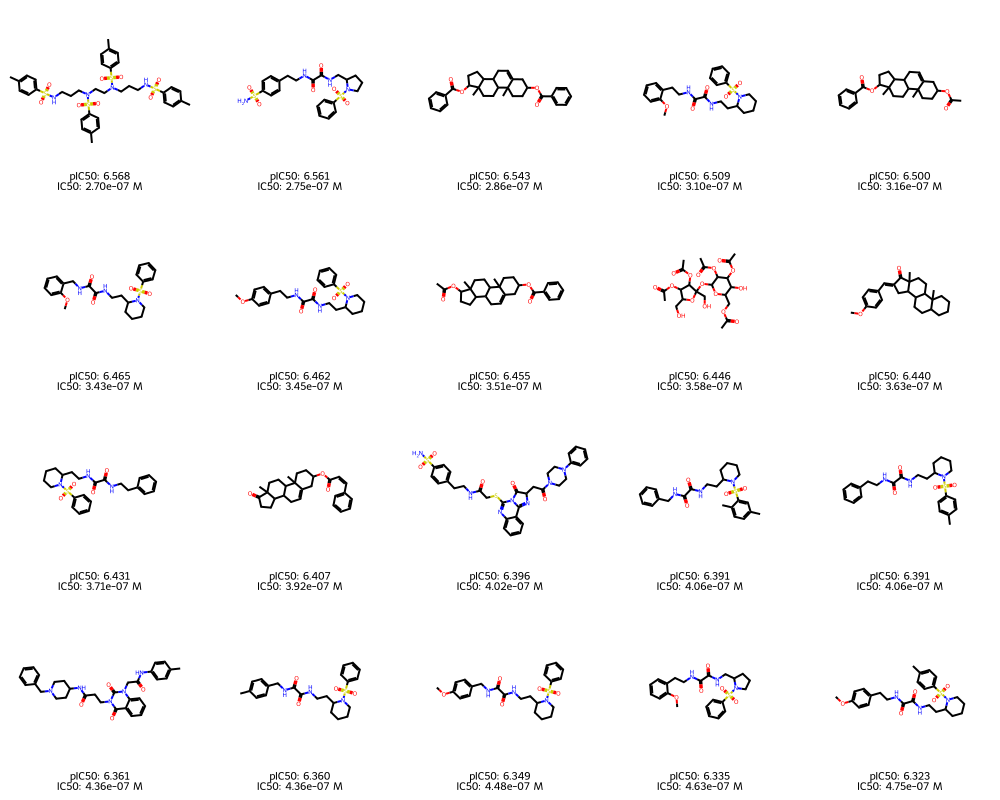

In [269]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image

# Setup paths
output_dir = resultsDir + 'combinedEbolaVirus/'
os.makedirs(output_dir, exist_ok=True)

# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in LCAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in EnamineAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = output_dir + 'combinedEbolaVirus_predictedCompounds_LCDataset.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = output_dir + 'combinedEbolaVirus_predictedCompounds_LCDataset.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

# 2.3 Discovery of new hits specific to all viruses (data source chemDiv data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [270]:
# Read all molecules from SDF
supplier = Chem.SDMolSupplier(dataDir + "ChemDiv/ChemDiv_Antiviral-Library-64958.sdf")
mols = [mol for mol in supplier if mol is not None]

# Extract properties into DataFrame
records = []
for mol in mols:
    props = mol.GetPropsAsDict()
    props["SMILES"] = Chem.MolToSmiles(mol)
    records.append(props)

ChemDivAntiviralsData = pd.DataFrame(records)
print(f"Original ChemDiv data shape: {ChemDivAntiviralsData.shape}")

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to ChemDiv data (reusing canonical_train from previous code)
ChemDivAntiviralsData['Canonical_SMILES'] = ChemDivAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~ChemDivAntiviralsData['Canonical_SMILES'].isin(canonical_train)
ChemDivAntiviralsData_filtered = ChemDivAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
ChemDivAntiviralsData = ChemDivAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered ChemDiv data shape for validation: {ChemDivAntiviralsData.shape}")
print(f"Removed {ChemDivAntiviralsData_filtered.shape[0] - ChemDivAntiviralsData.shape[0]} duplicate compounds from ChemDiv data set")

# Now use the filtered data
smi_lib = ChemDivAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
ChemDivAntiviralsData

Original ChemDiv data shape: (64958, 28)
Number of unique SMILES in training set: 540
Filtered ChemDiv data shape for validation: (64957, 28)
Removed 0 duplicate compounds from ChemDiv data set
Total compounds to screen: 64957


IDNUMBER  available  H_acceptor  H_donor  B_rotN   N_O  logP  logD  \
0      E676-1193         55           6        0      10 6.000 4.584 3.825   
1      E676-4289          2           8        0       9 7.000 2.084 1.279   
2      E676-2516         15           7        0       7 7.000 4.274 3.444   
3      F735-0482         21           7        2       9 7.000 3.231 3.225   
4      G211-0195        304           5        1       5 5.000 5.054 5.054   
...          ...        ...         ...      ...     ...   ...   ...   ...   
64953  8010-2606         54           8        1       9 8.000 6.685 3.100   
64954  2774-1508          1           7        1       8 7.000 6.551 3.884   
64955  K061-0539        124           7        1       7 7.000 6.014 2.429   
64956  K061-0894        165           6        1       7 7.000 6.905 6.387   
64957  K061-0799         89          10        1       9 9.000 5.628 3.159   

       logSw    PSA  ...                    InChI Key  PERCENTSP3  \
0     -4.736 44.193  ...  CADSCKHSUSMLDE-UHFFFAOYSA-N      33.300   
1     -2.867 59.381  ...  GBCBRISSOXAFMF-UHFFFAOYSA-N      47.400   
2     -4.355 53.078  ...  LSLRIDUYGBBIBR-SFHVURJKSA-N      36.400   
3     -3.423 79.491  ...  NBFDETMKPOQYSJ-UHFFFAOYSA-N      22.200   
4     -5.469 49.877  ...  DRPXIGZHBISZAU-UHFFFAOYSA-N      32.000   
...      ...    ...  ...                          ...         ...   
64953 -6.678 70.818  ...  ZQXAXHNEVALOJP-UHFFFAOYSA-N      30.800   
64954 -5.738 62.323  ...  KDXCUTJRVPCZKK-UHFFFAOYSA-N      25.000   
64955 -5.464 64.713  ...  XEIANUQFWJNADZ-UHFFFAOYSA-N      27.300   
64956 -6.761 57.369  ...  IBXAKUXFQPUZBE-UHFFFAOYSA-N      13.600   
64957 -5.617 83.631  ...  BNXSKLFCGOGJLZ-UHFFFAOYSA-N      17.400   

                                                    Link CLNUMBER Saltdata  \
0      https://www.chemdiv.com/catalog/screening-comp...  CL4971B      HCl   
1      https://www.chemdiv.com/catalog/screening-comp...  CL4971B      HCl   
2      https://www.chemdiv.com/catalog/screening-comp...  CL4971B      HCl   
3      https://www.chemdiv.com/catalog/screening-comp...   CL8286      NaN   
4      https://www.chemdiv.com/catalog/screening-comp...   CL6036      NaN   
...                                                  ...      ...      ...   
64953  https://www.chemdiv.com/catalog/screening-comp...   CL1650      NaN   
64954  https://www.chemdiv.com/catalog/screening-comp...   CL1652      NaN   
64955  https://www.chemdiv.com/catalog/screening-comp...   CL1647      NaN   
64956  https://www.chemdiv.com/catalog/screening-comp...   CL1650      NaN   
64957  https://www.chemdiv.com/catalog/screening-comp...   CL1652      NaN   

      Saltdata_MW           STEREO  State  \
0          36.461          ACHIRAL  Solid   
1          36.461          ACHIRAL  Solid   
2          36.461  RACEMIC MIXTURE  Solid   
3             NaN          ACHIRAL  Solid   
4             NaN          ACHIRAL  Solid   
...           ...              ...    ...   
64953         NaN          ACHIRAL  Solid   
64954         NaN          ACHIRAL  Solid   
64955         NaN          ACHIRAL  Solid   
64956         NaN          ACHIRAL  Solid   
64957         NaN          ACHIRAL  Solid   

                                                  SMILES  CAS  
0        CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12  NaN  
1       CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1  NaN  
2      COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12  NaN  
3             CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1  NaN  
4      O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...  NaN  
...                                                  ...  ...  
64953  CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...  NaN  
64954  CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...  NaN  
64955  COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...  NaN  
64956  COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...  NaN  
64957  COC(=O)c1sc(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...  Na

In [271]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

50000


In [272]:
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData.copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
ChemDivAntiviralsData_predicted['pPotency(M)_prediction'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_prediction'])

ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction",  "pPotency(M)_prediction"]
)
ChemDivAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_ChemDivDatasets_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_ChemDivDatasets_predicted_all_SMILES.csv"), index=False)
ChemDivAntiviralsData_predicted

SMILES  pPotency_prediction  \
0        CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12                5.698   
1       CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1                6.166   
2      COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12                5.751   
3             CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1                5.051   
4      O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...                5.798   
...                                                  ...                  ...   
64953  CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...                6.000   
64954  CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...                5.876   
64955  COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...                5.790   
64956  COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...                6.141   
64957  COC(=O)c1sc(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...                5.863   

       pPotency(M)_prediction  
0                   2.004e-06  
1                   6.827e-07  
2                   1.774e-06  
3                   8.895e-06  
4                   1.593e-06  
...                       ...  
64953               9.990e-07  
64954               1.331e-06  
64955               1.621e-06  
64956               7.233e-07  
64957               1.372e-06  

[64957 rows x 3 columns]

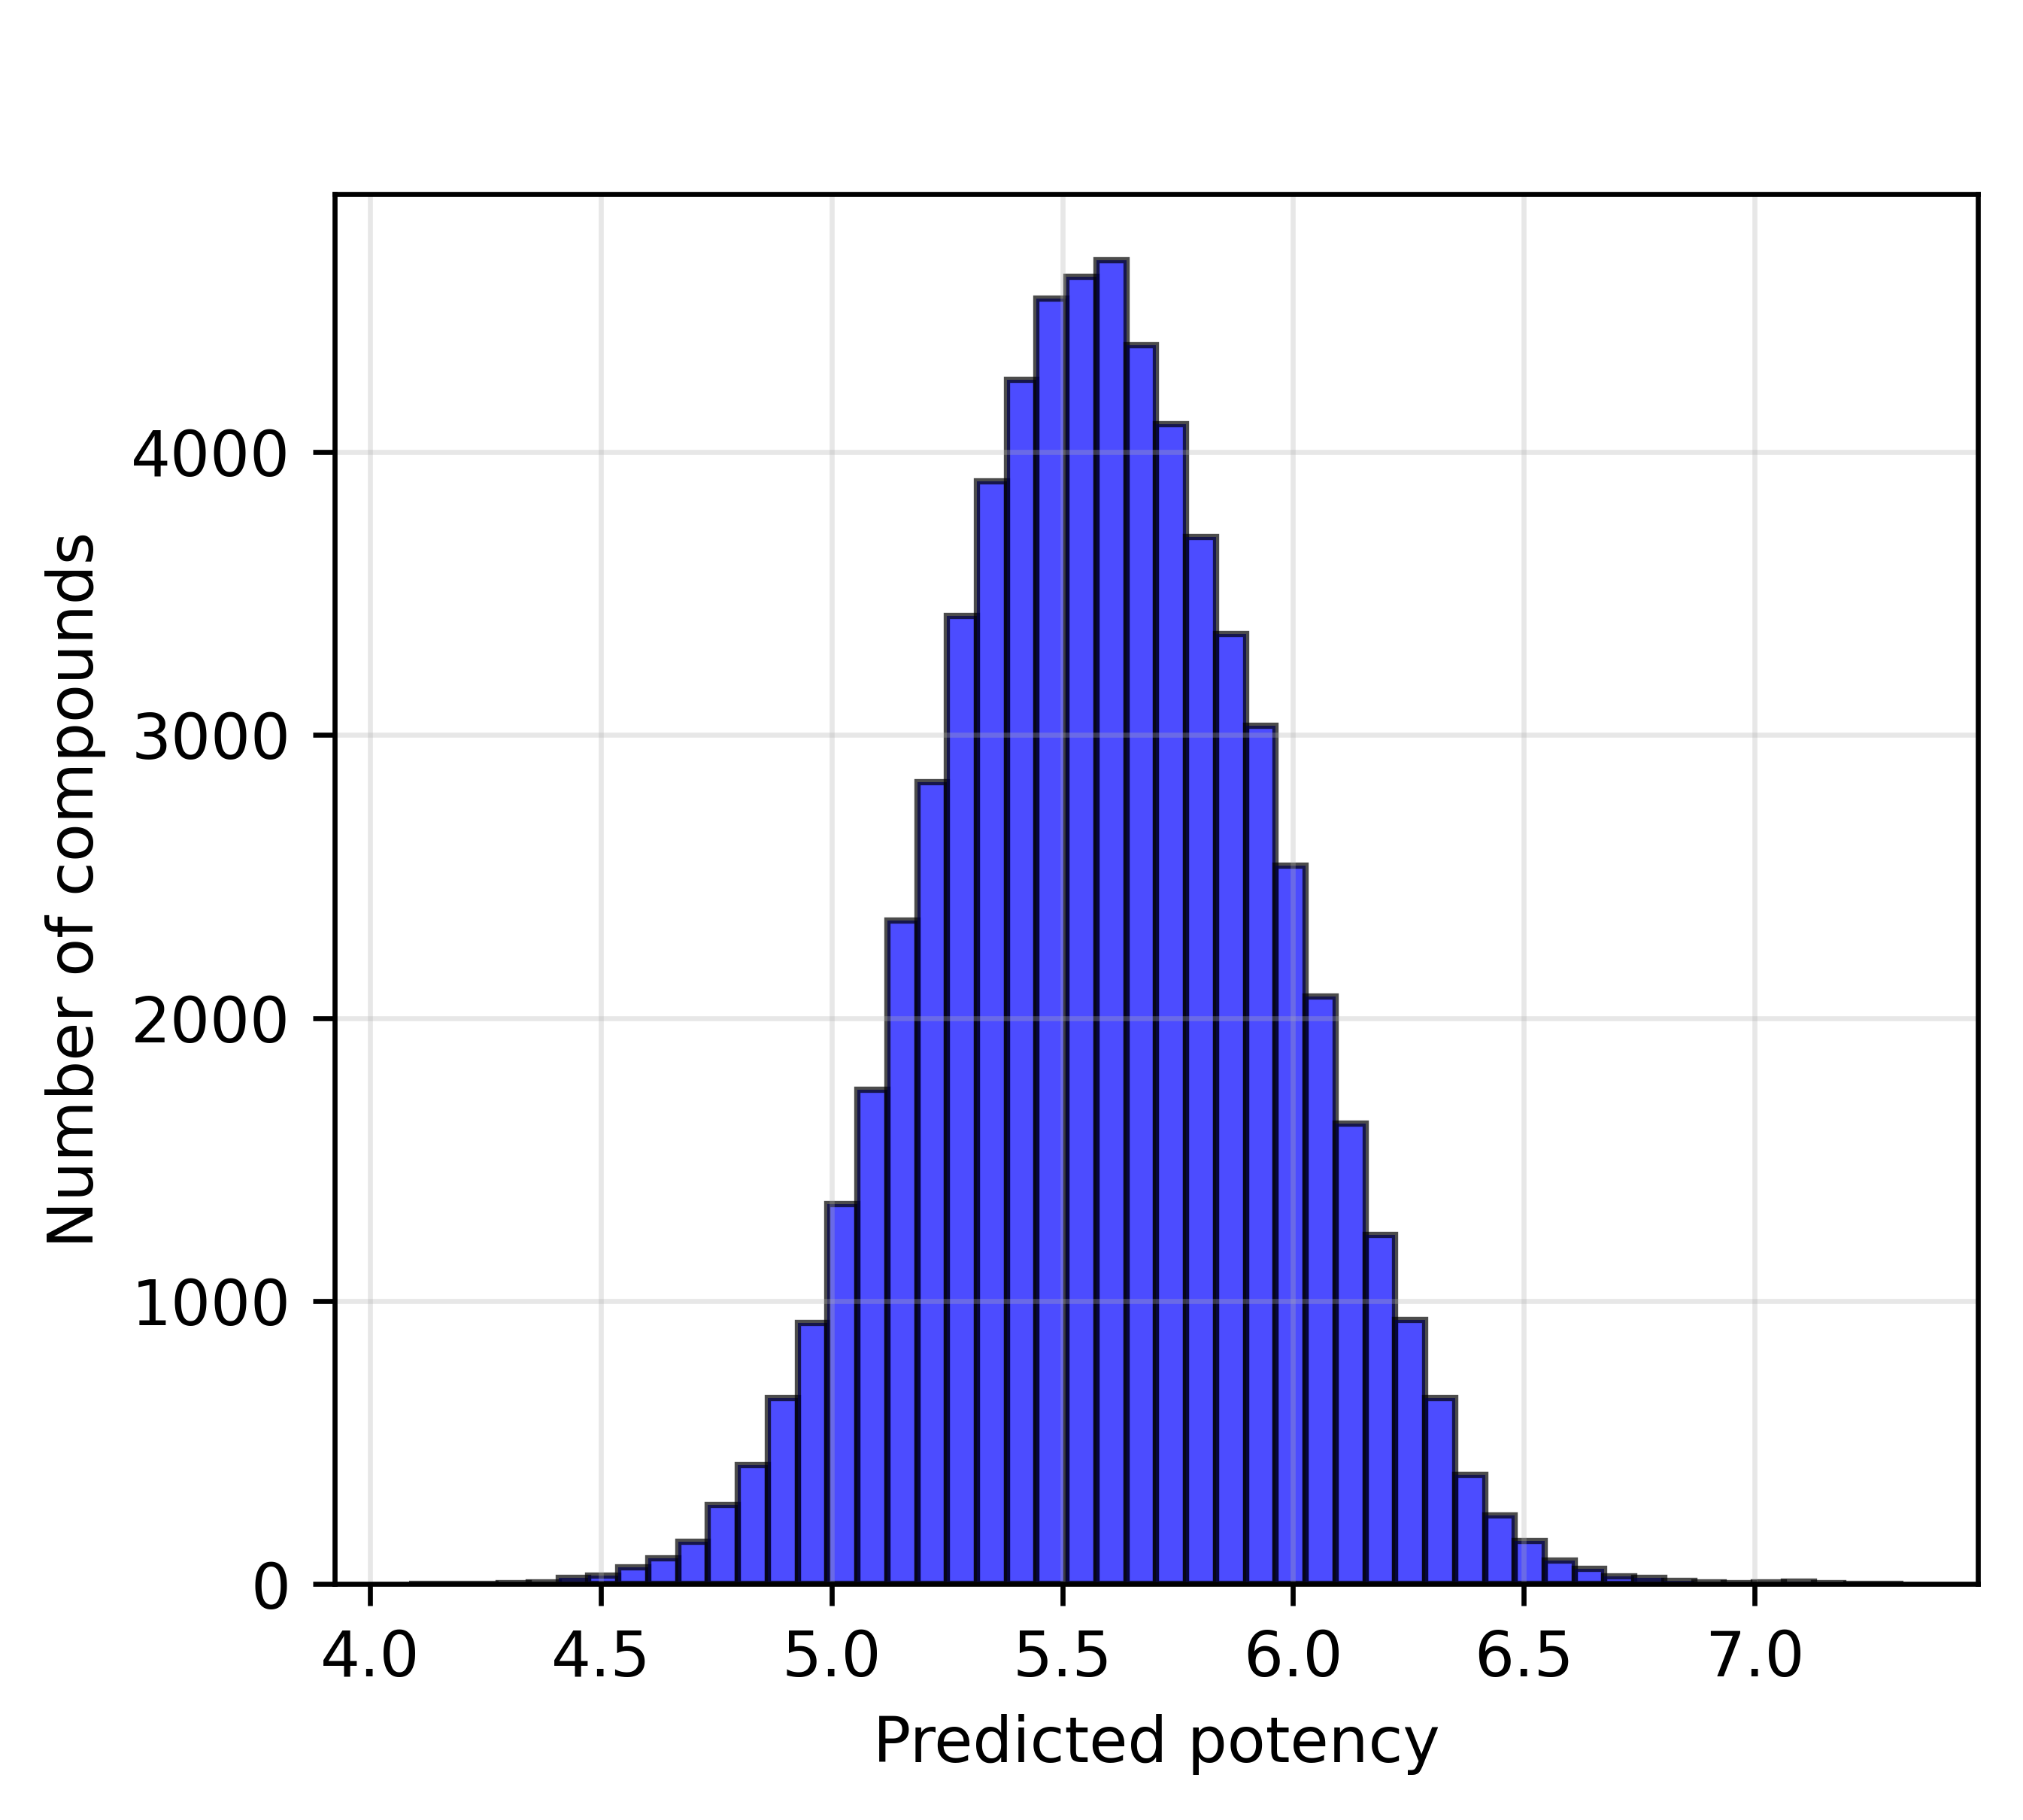

In [273]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_ChemDivDatasets.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_ChemDivDatasets.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [274]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 21 compounds
Medium priority (6 ≤ pPotency < 7.0): 8531 compounds
Low priority (5 ≤ pPotency < 6): 53594 compounds


In [275]:
ChemDivAntiviralsData_final = ChemDivAntiviralsData.iloc[idx].copy()
ChemDivAntiviralsData_final['pPotency_prediction'] = Y1_lib_pred[idx]
ChemDivAntiviralsData_final = ChemDivAntiviralsData_final.filter(
    items=["SMILES", "pPotency_prediction", "clogP"]
)
ChemDivAntiviralsData_final

SMILES  pPotency_prediction
25     COc1cccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC...                7.118
26     CN(CCCN1C(=O)[C@H]2C(C(=O)Nc3cccc(Cl)c3)[C@H]3...                7.169
7386   O=C(N[C@@H]1CCCC[C@H]1NC(=O)[C@@H]1CCCN1S(=O)(...                7.322
7410   O=C(N[C@H]1CC[C@H](NC(=O)[C@@H]2CCCN2S(=O)(=O)...                7.090
10244  CCCCN(C)CCCN1C(=O)[C@H]2C(C(=O)Nc3cccc(Cl)c3)[...                7.017
11017  CC(C)c1ccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC...                7.136
35031  C=CCN1C(=O)NC(c2ccc(C)cc2)C2=C1CN(C(Cc1ccccc1)...                7.009
41340  CSc1cccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3C...                7.097
41341  CN(CCCN1C(=O)[C@H]2C(C(=O)Nc3ccc(Cl)cc3)[C@H]3...                7.207
41342  Cc1ccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC3C...                7.084
45587  Cc1ccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3CCC...                7.288
45588  COc1cccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3C...                7.032
47686  O=C(N[C@H]1CC[C@H](NC(=O)[C@@H]2CCCN2S(=O)(=O)...                7.170
49972  Cc1ccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC3C...                7.019
49976  COc1ccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC3...                7.126
49977  CN(CCN1C(=O)[C@H]2C(C(=O)Nc3cccc(Cl)c3)[C@H]3C...                7.147
56621  CC(C)c1ccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)...                7.065
56626  Cc1cccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3CC...                7.035
61120  CCCCN(C)CCCN1C(=O)[C@H]2C(C(=O)Nc3ccc(Cl)cc3)[...                7.034
61123  CN(CCN1C(=O)[C@@H]2C(C(=O)Nc3ccc(Cl)cc3)[C@@H]...                7.108
63240  Cc1ccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3CCC...                7.087

### Top 20 compounds with higher pPotency

In [276]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

Top 20 compounds cutoff pPotency: 7.02
Highest predicted pPotency: 7.32
Range of top 20: 7.02 - 7.32


In [277]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
ChemDivAntiviralsData_top20 = ChemDivAntiviralsData.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
ChemDivAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
ChemDivAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
ChemDivAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
ChemDivAntiviralsData_top20 = ChemDivAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
ChemDivAntiviralsData_top20

----------------------------------------------------------------------
Top 20 Compounds with Highest Predicted pPotency
----------------------------------------------------------------------

Cutoff Values (20th ranked compound):
  pPotency:    7.017
  IC50:        9.609e-08 M  (96.09 nM)

Best Values (1st ranked compound):
  pPotency:    7.322
  IC50:        4.762e-08 M  (47.62 nM)
Range for Top 20 Compounds:
pPotency Range:  7.017 - 7.322

IC50 Range (M):  9.609e-08 - 4.762e-08


Rank                                             SMILES  \
7386      1  O=C(N[C@@H]1CCCC[C@H]1NC(=O)[C@@H]1CCCN1S(=O)(...   
45587     2  Cc1ccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3CCC...   
41341     3  CN(CCCN1C(=O)[C@H]2C(C(=O)Nc3ccc(Cl)cc3)[C@H]3...   
47686     4  O=C(N[C@H]1CC[C@H](NC(=O)[C@@H]2CCCN2S(=O)(=O)...   
26        5  CN(CCCN1C(=O)[C@H]2C(C(=O)Nc3cccc(Cl)c3)[C@H]3...   
49977     6  CN(CCN1C(=O)[C@H]2C(C(=O)Nc3cccc(Cl)c3)[C@H]3C...   
11017     7  CC(C)c1ccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC...   
49976     8  COc1ccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC3...   
25        9  COc1cccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC...   
61123    10  CN(CCN1C(=O)[C@@H]2C(C(=O)Nc3ccc(Cl)cc3)[C@@H]...   
41340    11  CSc1cccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3C...   
7410     12  O=C(N[C@H]1CC[C@H](NC(=O)[C@@H]2CCCN2S(=O)(=O)...   
63240    13  Cc1ccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3CCC...   
41342    14  Cc1ccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC3C...   
56621    15  CC(C)c1ccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)...   
56626    16  Cc1cccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3CC...   
61120    17  CCCCN(C)CCCN1C(=O)[C@H]2C(C(=O)Nc3ccc(Cl)cc3)[...   
45588    18  COc1cccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3C...   
49972    19  Cc1ccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC3C...   
10244    20  CCCCN(C)CCCN1C(=O)[C@H]2C(C(=O)Nc3cccc(Cl)c3)[...   

       pPotency_prediction  IC50 (M)  
7386                 7.322 4.762e-08  
45587                7.288 5.149e-08  
41341                7.207 6.202e-08  
47686                7.170 6.768e-08  
26                   7.169 6.784e-08  
49977                7.147 7.128e-08  
11017                7.136 7.317e-08  
49976                7.126 7.477e-08  
25                   7.118 7.616e-08  
61123                7.108 7.802e-08  
41340                7.097 8.005e-08  
7410                 7.090 8.132e-08  
63240                7.087 8.193e-08  
41342                7.084 8.248e-08  
56621                7.065 8.611e-08  
56626                7.035 9.216e-08  
61120                7.034 9.255e-08  
45588                7.032 9.287e-08  
49972                7.019 9.573e-08  
10244                7.017 9.609e-08

In [278]:
ChemDivAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_ChemDivAntiviralsData_top20.csv"), index=False)
ChemDivAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_ChemDivAntiviralsData_top20_SMILES.csv"), index=False)

 Saved PNG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_predictedCompounds_ChemDivDataset.png
 Saved SVG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_predictedCompounds_ChemDivDataset.svg


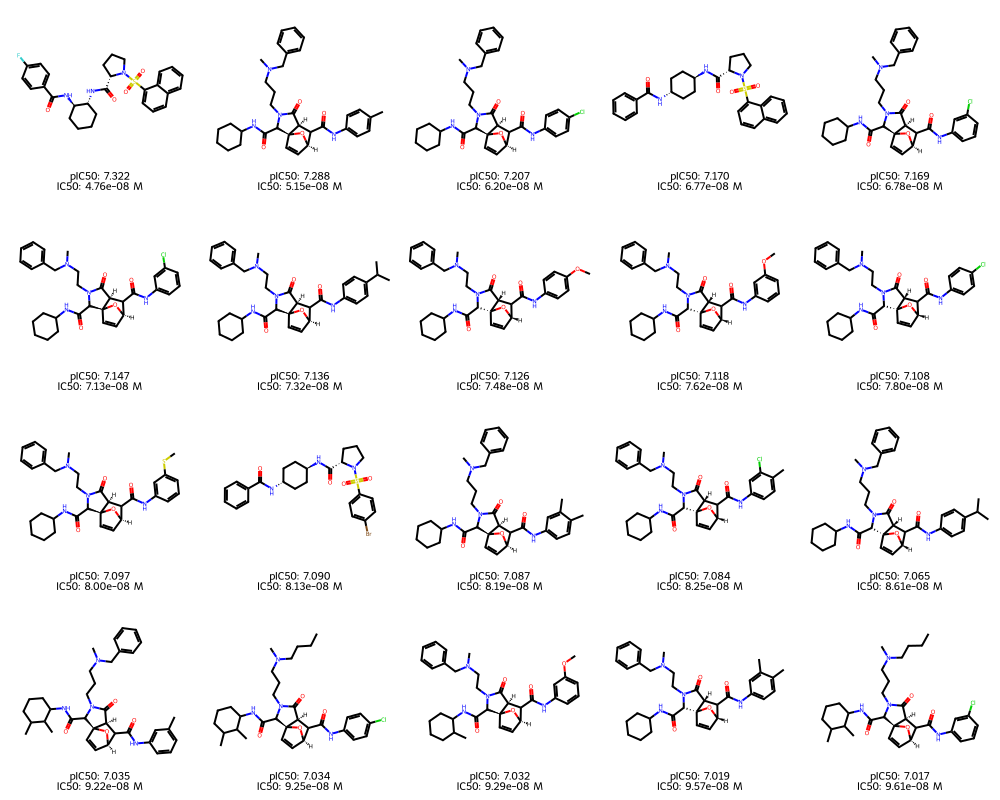

In [279]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image

# Setup paths
output_dir = resultsDir + 'combinedEbolaVirus/'
os.makedirs(output_dir, exist_ok=True)

# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in ChemDivAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in ChemDivAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = output_dir + 'combinedEbolaVirus_predictedCompounds_ChemDivDataset.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = output_dir + 'combinedEbolaVirus_predictedCompounds_ChemDivDataset.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

### 2.4 Discovery of new hits specific to all viruses (data source SMACC Antivirals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. In particular, we are interested in molecules with high predicted pPotency.

In [280]:
SMACCAntiviralsData = pd.read_csv(modelBuildingDataDir + "SMACCAntiviralsData_clean.csv")

# Check for duplicates
dup_check = SMACCAntiviralsData.groupby('SMILES')['pIC50'].agg(['count', 'median', 'std'])
duplicates = dup_check[dup_check['count'] > 1]
print(f"Original SMACC data shape: {SMACCAntiviralsData.shape}, with Duplicate SMILES: {len(duplicates)}")

# Take median pIC50 for duplicates
SMACCAntiviralsData = SMACCAntiviralsData.groupby('SMILES').agg({
    'Molecule ChEMBL ID': 'first',
    'pIC50': 'median',  # Use median instead of mean
    'Virus': 'first'
}).reset_index()

print(f"After removing internal duplicates: {SMACCAntiviralsData.shape}")

print(f"Number of unique SMILES in training set: {len(canonical_train)}")
# Add canonical SMILES column to SMACC data (reusing canonical_train from previous code)
SMACCAntiviralsData['Canonical_SMILES'] = SMACCAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~SMACCAntiviralsData['Canonical_SMILES'].isin(canonical_train)
SMACCAntiviralsData_filtered = SMACCAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
SMACCAntiviralsData = SMACCAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered SMACC data shape for validation: {SMACCAntiviralsData.shape}")
print(f"Removed {SMACCAntiviralsData_filtered.shape[0] - SMACCAntiviralsData.shape[0]} duplicate compounds from SMACC data set")
SMACCAntiviralsData = SMACCAntiviralsData.rename(columns={'pIC50': 'pIC50_experimental'})

smi_lib = SMACCAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
SMACCAntiviralsData.head()

Original SMACC data shape: (1923, 5), with Duplicate SMILES: 197
After removing internal duplicates: (1612, 4)
Number of unique SMILES in training set: 540
Filtered SMACC data shape for validation: (1612, 4)
Removed 0 duplicate compounds from SMACC data set
Total compounds to screen: 1612


SMILES Molecule ChEMBL ID  \
0                  Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1       CHEMBL243652   
1  Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...      CHEMBL4284511   
2  Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...      CHEMBL1402117   
3                          Brc1ccc2C(=O)C(=O)C=Cc2c1      CHEMBL4303595   
4  Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...      CHEMBL1361582   

   pIC50_experimental       Virus  
0               5.690  SARS-CoV-2  
1               5.328      Dengue  
2               4.132      Dengue  
3               7.097  SARS-CoV-2  
4               4.627      Dengue

Generate predictions

In [281]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [282]:
SMACCAntiviralsData_predicted = SMACCAntiviralsData.copy()
SMACCAntiviralsData_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
SMACCAntiviralsData_predicted['IC50(M)_experimental'] = 10 ** (-SMACCAntiviralsData_predicted['pIC50_experimental'])
SMACCAntiviralsData_predicted['pPotency(M)_prediction'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_prediction'])

SMACCAntiviralsData_predicted = SMACCAntiviralsData_predicted.filter(
    items=["SMILES", "Virus", "pIC50_experimental", "pPotency_prediction",  "IC50(M)_experimental", "pPotency(M)_prediction"]
)
SMACCAntiviralsData_predicted

SMILES       Virus  \
0                     Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1  SARS-CoV-2   
1     Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...      Dengue   
2     Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...      Dengue   
3                             Brc1ccc2C(=O)C(=O)C=Cc2c1  SARS-CoV-2   
4     Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...      Dengue   
...                                                 ...         ...   
1607                              S=C1NN=C(Nc2ccccc2)S1  SARS-CoV-2   
1608                                    S=C1Nc2ccccc2S1  SARS-CoV-2   
1609                                      SC(=S)N1CCCC1  SARS-CoV-2   
1610                   c1coc(c1)-c1nc2ccccc2nc1-c1ccco1      Dengue   
1611              c1coc(c1)-c1nc2nc3ccccc3n2nc1-c1ccco1      Dengue   

      pIC50_experimental  pPotency_prediction  IC50(M)_experimental  \
0                  5.690                5.467             2.040e-06   
1                  5.328                4.993             4.700e-06   
2                  4.132                5.277             7.371e-05   
3                  7.097                5.715             8.000e-08   
4                  4.627                5.623             2.359e-05   
...                  ...                  ...                   ...   
1607               6.409                5.356             3.900e-07   
1608               5.759                5.434             1.740e-06   
1609               6.678                5.423             2.100e-07   
1610               4.000                5.297             1.000e-04   
1611               4.003                5.301             9.930e-05   

      pPotency(M)_prediction  
0                  3.411e-06  
1                  1.017e-05  
2                  5.281e-06  
3                  1.925e-06  
4                  2.385e-06  
...                      ...  
1607               4.408e-06  
1608               3.684e-06  
1609               3.776e-06  
1610               5.045e-06  
1611               4.995e-06  

[1612 rows x 6 columns]

In [283]:
SMACCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_SMACCAntiviralsData_predicted_all.csv"), index=False)
SMACCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_SMACCAntiviralsData_predicted_all_SMILES.csv"), index=False)

### Plot the error between `experimental_pPotency` and `predicted_pPotency`

Mean Residual: 0.813
Std Dev of Residuals: 1.068
Min Residual: -4.107
Max Residual: 3.728


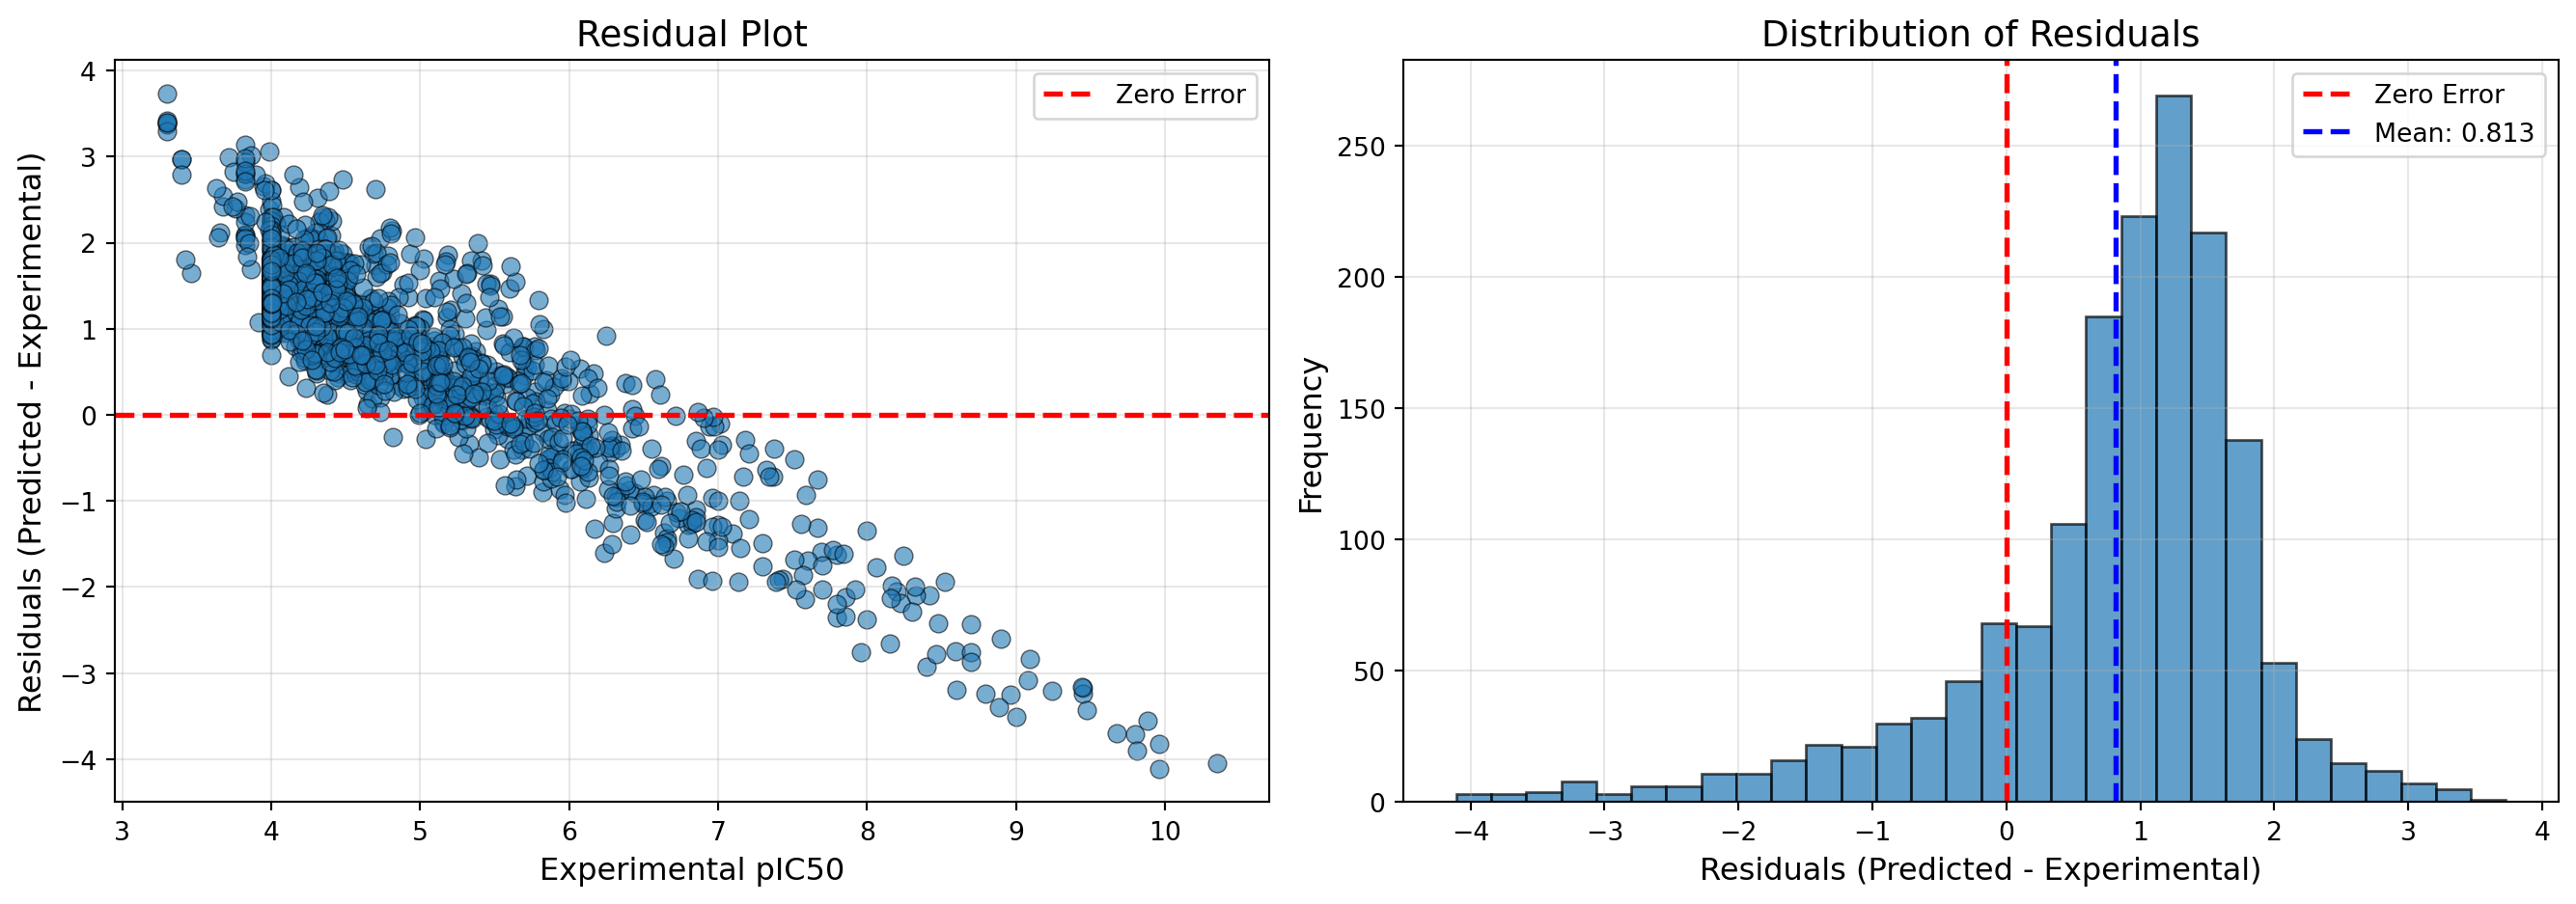

In [284]:
# Calculate residuals (difference)
SMACCAntiviralsData_predicted['residuals'] = (
    SMACCAntiviralsData_predicted['pPotency_prediction'] - 
    SMACCAntiviralsData_predicted['pIC50_experimental']
)

# Print statistics
print(f"Mean Residual: {SMACCAntiviralsData_predicted['residuals'].mean():.3f}")
print(f"Std Dev of Residuals: {SMACCAntiviralsData_predicted['residuals'].std():.3f}")
print(f"Min Residual: {SMACCAntiviralsData_predicted['residuals'].min():.3f}")
print(f"Max Residual: {SMACCAntiviralsData_predicted['residuals'].max():.3f}")

# Create residual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Residuals vs Experimental values
axes[0].scatter(SMACCAntiviralsData_predicted['pIC50_experimental'], 
                SMACCAntiviralsData_predicted['residuals'], 
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Experimental pIC50', fontsize=12)
axes[0].set_ylabel('Residuals (Predicted - Experimental)', fontsize=12)
axes[0].set_title('Residual Plot', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of residuals
axes[1].hist(SMACCAntiviralsData_predicted['residuals'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].axvline(x=SMACCAntiviralsData_predicted['residuals'].mean(), 
                color='blue', linestyle='--', linewidth=2, 
                label=f'Mean: {SMACCAntiviralsData_predicted["residuals"].mean():.3f}')
axes[1].set_xlabel('Residuals (Predicted - Experimental)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Residual Plot Analysis

In [285]:
print(f"Mean residual: {SMACCAntiviralsData_predicted['residuals'].mean():.3f} (Close to 0 indicates no systematic bias)")
print(f"Std deviation: {SMACCAntiviralsData_predicted['residuals'].std():.3f} (typical prediction error)")
print(f"95% of predictions are within ±{1.96 * SMACCAntiviralsData_predicted['residuals'].std():.3f} pIC50 units")

Mean residual: 0.813 (Close to 0 indicates no systematic bias)
Std deviation: 1.068 (typical prediction error)
95% of predictions are within ±2.094 pIC50 units


Let us have a look at the compounds:

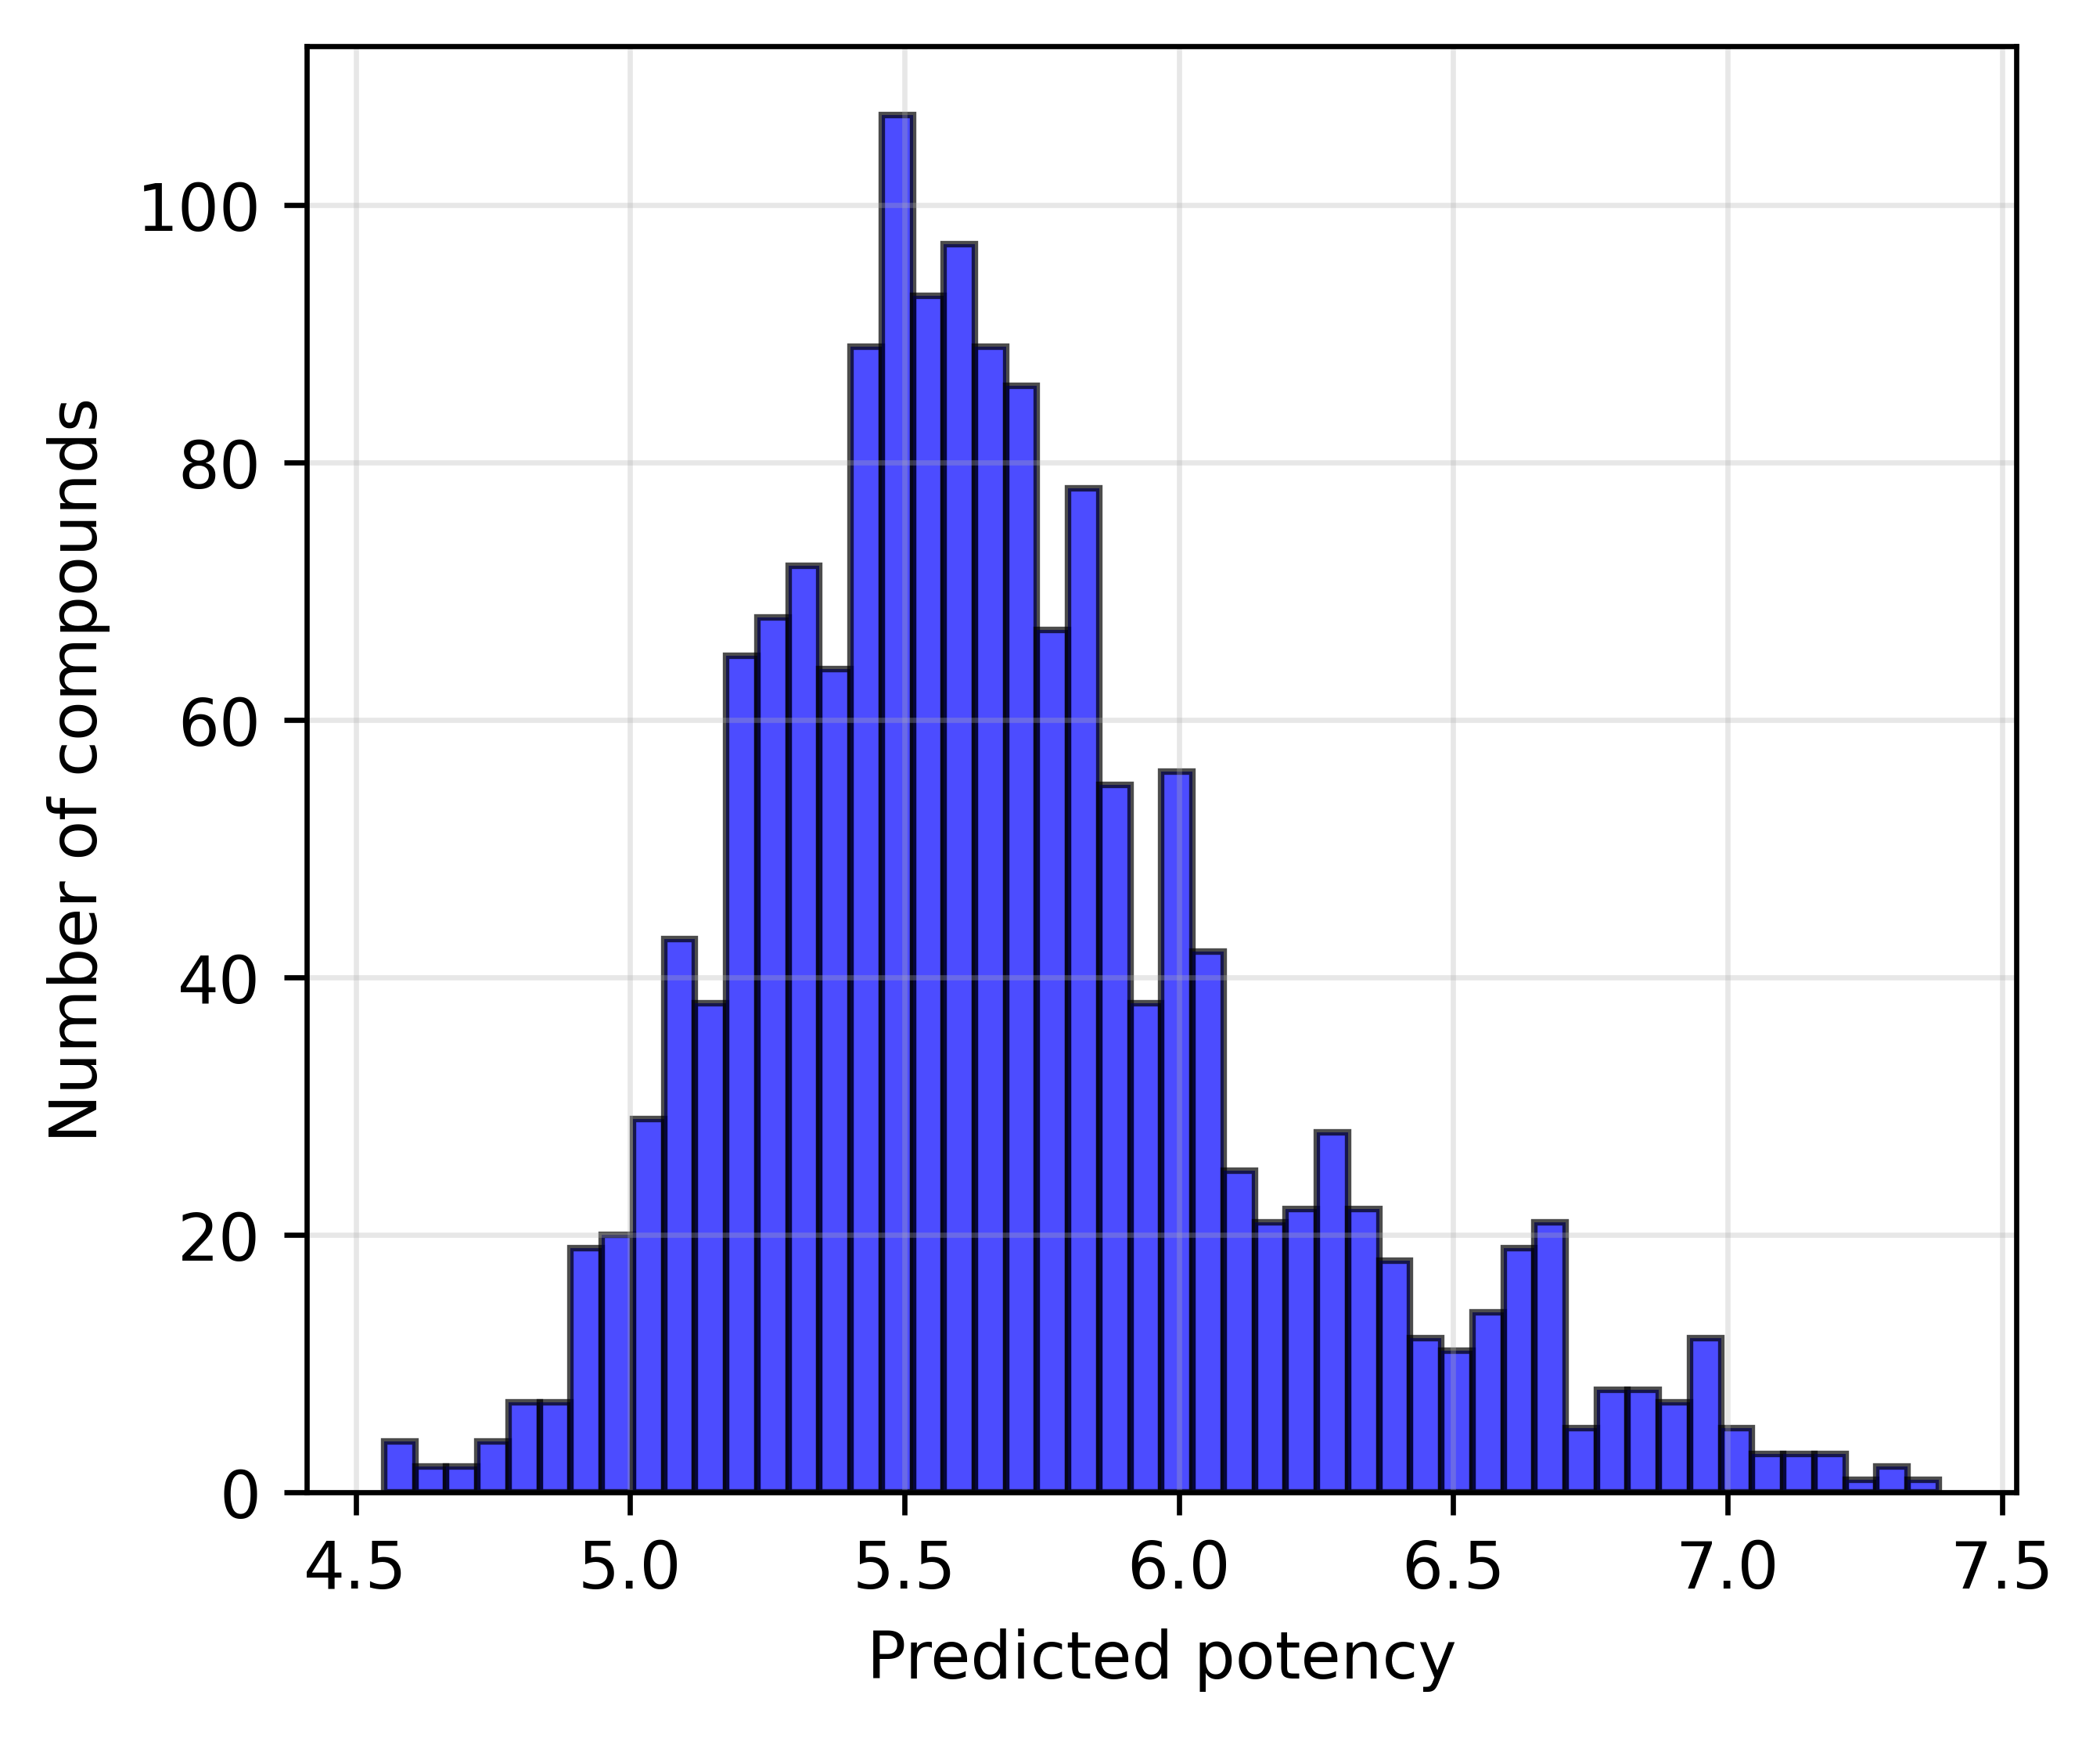

In [286]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.title(f"Virtual screening of custom library ({len(smi_lib)} molecules)", pad=35)
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_validation_noDuplicates_SMACCDatasets.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_validation_noDuplicates_SMACCDatasets.png', bbox_inches='tight', dpi=300)
plt.show()

In [287]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 15 compounds
Medium priority (6 ≤ pPotency < 7.0): 335 compounds
Low priority (5 ≤ pPotency < 6): 1199 compounds


### Top 20 compounds with higher pPotency

In [288]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

Top 20 compounds cutoff pPotency: 6.99
Highest predicted pPotency: 7.38
Range of top 20: 6.99 - 7.38


In [289]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
SMACCAntiviralsData_top20 = SMACCAntiviralsData_predicted.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
SMACCAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
SMACCAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
SMACCAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'


SMACCAntiviralsData_top20

----------------------------------------------------------------------
Top 20 Compounds with Highest Predicted pPotency
----------------------------------------------------------------------

Cutoff Values (20th ranked compound):
  pPotency:    6.985
  IC50:        1.034e-07 M  (103.44 nM)

Best Values (1st ranked compound):
  pPotency:    7.385
  IC50:        4.122e-08 M  (41.22 nM)
Range for Top 20 Compounds:
pPotency Range:  6.985 - 7.385

IC50 Range (M):  1.034e-07 - 4.122e-08


Rank                                             SMILES       Virus  \
1126     1  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)C(=O)c1ccccc1)...      Dengue   
1148     2  NCCCCC(NC(=O)C(Cc1cccc(NC(N)=N)c1)NC(=O)c1cccc...   West_Nile   
1144     3  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)c1ccccc1)C(=O)...   West_Nile   
281      4  CCCCC(NC(=O)c1ccccc1)C(=O)NC(CCCCN)C(=O)NC(CCC...      Dengue   
47       5  CC(=O)Nc1ccc(CC(NC(=O)c2ccccc2)C(=O)NC(CCCCN)C...   West_Nile   
1141     6  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)c1ccccc1)C(=O)...      Dengue   
1142     7  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)c1ccccc1)C(=O)...      Dengue   
1143     8  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)c1ccccc1)C(=O)...      Dengue   
229      9  CC1OC(OC2C(O)C(OCCc3ccc(O)c(O)c3)OC(CO)C2OC(=O...  SARS-CoV-2   
1147    10  NCCCCC(NC(=O)C(Cc1ccc(CN)cc1)NC(=O)c1ccccc1)C(...   West_Nile   
1139    11  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)c1ccccc1)C(=O)...      Dengue   
900     12  Cc1ccc(cc1)N1CC(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C(...      Dengue   
230     13  CC1OC(OCC2OC(OC3=C(Oc4cc(O)cc(O)c4C3=O)c3ccc(O...        Zika   
1157    14  NCCCCC(NC(=O)Cc1ccccc1)C(=O)NC(CCCCN)C(=O)NC(C...   West_Nile   
292     15  CCCCC(NC(=O)c1ccccc1)C(=O)NC(CCCCN)C(=O)NC(CCC...      Dengue   
1146    16  NCCCCC(NC(=O)C(CCCNC(N)=O)NC(=O)Cc1ccccc1)C(=O...   West_Nile   
452     17  CN(C(CCCNC(N)=N)C(=O)NC(CCCCN)C(=O)NC(C(N)=O)c...      Dengue   
1159    18  NCCCCC(NC(=O)Cc1ccccc1)C(=O)NC(CCCN)C(=O)NC(CC...   West_Nile   
300     19  CCCCC(NC(=O)c1ccccc1)C(=O)NC(CCCCN)C(=O)NC(Cc1...      Dengue   
1154    20  NCCCCC(NC(=O)Cc1ccc(cc1)-c1ccccc1)C(=O)NC(CCCC...      Dengue   

      pIC50_experimental  pPotency_prediction  IC50(M)_experimental  \
1126               5.387                7.385             4.100e-06   
1148               5.606                7.326             2.480e-06   
1144               4.700                7.324             1.996e-05   
281                4.481                7.220             3.300e-05   
47                 5.415                7.210             3.850e-06   
1141               5.638                7.187             2.300e-06   
1142               6.247                7.170             5.657e-07   
1143               5.420                7.154             3.800e-06   
229                5.343                7.136             4.540e-06   
1147               5.796                7.131             1.600e-06   
1139               5.602                7.071             2.500e-06   
900                5.184                7.047             6.552e-06   
230                3.983                7.047             1.040e-04   
1157               4.964                7.030             1.087e-05   
292                3.301                7.029             5.000e-04   
1146               6.581                7.000             2.621e-07   
452                5.472                6.998             3.370e-06   
1159               7.511                6.992             3.081e-08   
300                4.390                6.988             4.070e-05   
1154               7.373                6.985             4.233e-08   

      pPotency(M)_prediction  residuals  IC50 (M)  
1126               4.122e-08      1.998 4.122e-08  
1148               4.715e-08      1.721 4.715e-08  
1144               4.740e-08      2.624 4.740e-08  
281                6.026e-08      2.738 6.026e-08  
47                 6.160e-08      1.796 6.160e-08  
1141               6.495e-08      1.549 6.495e-08  
1142               6.764e-08      0.922 6.764e-08  
1143               7.020e-08      1.733 7.020e-08  
229                7.303e-08      1.794 7.303e-08  
1147               7.398e-08      1.335 7.398e-08  
1139               8.483e-08      1.469 8.483e-08  
900                8.976e-08      1.863 8.976e-08  
230                8.982e-08      3.064 8.982e-08  
1157               9.327e-08      2.067 9.327e-08  
292                9.354e-08      3.728 9.354e-08  
1146               1.001e-07      0.418 1.001e-07  
452         

In [290]:
SMACCAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_SMACCAntiviralsData_top20.csv"), index=False)
SMACCAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_SMACCAntiviralsData_top20_SMILES.csv"), index=False)

 Saved PNG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/Ebolavirus/EbolaVirus_predictedCompounds_noDuplicates_SMACCDataset.png
 Saved SVG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/Ebolavirus/EbolaVirus_predictedCompounds_noDuplicates_SMACCDataset.svg


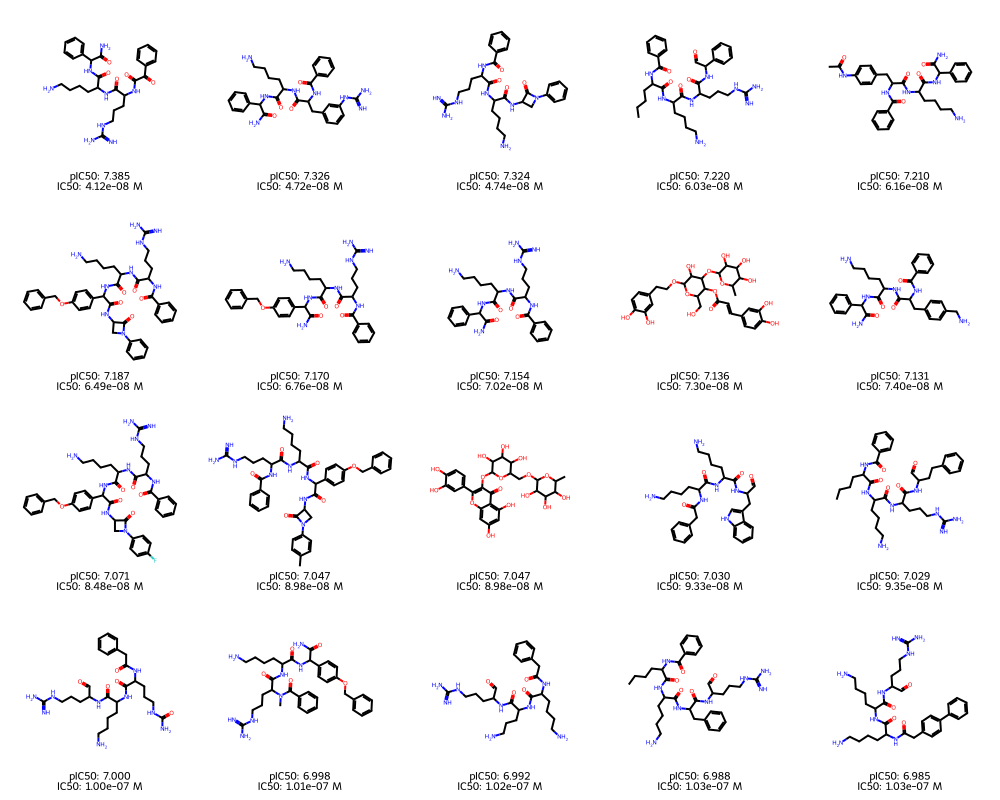

In [291]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image

# Setup paths
output_dir = resultsDir + 'Ebolavirus/'
os.makedirs(output_dir, exist_ok=True)

# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in SMACCAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in SMACCAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = output_dir + 'EbolaVirus_predictedCompounds_noDuplicates_SMACCDataset.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = output_dir + 'EbolaVirus_predictedCompounds_noDuplicates_SMACCDataset.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

### Checking drug likeliness of `Remdesivir` and `Molnupiravir`

In [292]:
Remdesivir_SMILES_file = os.path.join(dataDir + "/target_SMILES/Remdesivir_structure.mol")
Molnupiravir_SMILES_file = os.path.join(dataDir + "/target_SMILES/Molnupiravir_structure.mol")

In [293]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd

# SMILES strings
Remdesivir_SMILES = 'CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1'
Molnupiravir_SMILES = 'CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=C\C(NC1=O)=N\O'

# Dictionary of drugs and their SMILES
drugs = {
    'Remdesivir': Remdesivir_SMILES,
    'Molnupiravir': Molnupiravir_SMILES
}

# List to store results
smiles_data = []

# Process each drug
for drug_name, smiles in drugs.items():
    # Convert SMILES to molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        smiles_data.append({
            'Drug_Name': drug_name,
            'SMILES': smiles,
            'Molecular_Formula': rdMolDescriptors.CalcMolFormula(mol),
            'Molecular_Weight': round(Descriptors.MolWt(mol), 2)
        })
        print(f" {drug_name}")
        print(f"  Formula: {rdMolDescriptors.CalcMolFormula(mol)}")
        print(f"  MW: {round(Descriptors.MolWt(mol), 2)} g/mol")
    else:
        print(f" Failed to parse SMILES for {drug_name}")

# Create DataFrame
DTRA_target_SMILES = pd.DataFrame(smiles_data)
DTRA_target_SMILES

 Remdesivir
  Formula: C27H35N6O8P
  MW: 602.59 g/mol
 Molnupiravir
  Formula: C13H19N3O7
  MW: 329.31 g/mol


Drug_Name                                             SMILES  \
0    Remdesivir  CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...   
1  Molnupiravir  CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...   

  Molecular_Formula  Molecular_Weight  
0       C27H35N6O8P           602.590  
1        C13H19N3O7           329.310

In [294]:
# Canonicalize training SMILES and create a set for fast lookup
canonical_train = set()
for smi in smiles_train:
    canonical_smi = canonicalize_smiles(smi)
    if canonical_smi is not None:
        canonical_train.add(canonical_smi)

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to DTRA target data
DTRA_target_SMILES['Canonical_SMILES'] = DTRA_target_SMILES['SMILES'].apply(canonicalize_smiles)

# ADDED: Save original count BEFORE filtering
original_count = DTRA_target_SMILES.shape[0]

# Filter out duplicates - keep only those NOT in training set
mask = ~DTRA_target_SMILES['Canonical_SMILES'].isin(canonical_train)
DTRA_target_SMILES_filtered = DTRA_target_SMILES[mask].copy()

# Remove the helper column if you don't need it
DTRA_target_SMILES = DTRA_target_SMILES_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered DTRA target data shape for validation: {DTRA_target_SMILES.shape}")
print(f"Removed {original_count - DTRA_target_SMILES.shape[0]} duplicate compounds from DTRA target data set")  # FIXED

# Now use the filtered data
smi_lib = DTRA_target_SMILES.SMILES
print(f"Total DTRA target compounds to screen: {len(smi_lib)}")

# Display the filtered data
DTRA_target_SMILES

Number of unique SMILES in training set: 540
Filtered DTRA target data shape for validation: (1, 4)
Removed 1 duplicate compounds from DTRA target data set
Total DTRA target compounds to screen: 1


Drug_Name                                             SMILES  \
1  Molnupiravir  CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...   

  Molecular_Formula  Molecular_Weight  
1        C13H19N3O7           329.310

Generate predictions

In [295]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [296]:
DTRA_target_SMILES_predicted = DTRA_target_SMILES.copy()
DTRA_target_SMILES_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
DTRA_target_SMILES_predicted['pPotency(M)_prediction'] = 10 ** (-DTRA_target_SMILES_predicted['pPotency_prediction'])

DTRA_target_SMILES_predicted = DTRA_target_SMILES_predicted.filter(
    items=["SMILES", "pPotency_prediction",  "pPotency(M)_prediction"]
)
DTRA_target_SMILES_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wDuplicates_DTRAtargets_predicted_all.csv"), index=False)
DTRA_target_SMILES_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wDuplicates_DTRAtargets_predicted_all_SMILES.csv"), index=False)
DTRA_target_SMILES_predicted

SMILES  pPotency_prediction  \
1  CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...                5.808   

   pPotency(M)_prediction  
1               1.556e-06

### Checking efficiency of `Remdesivir` as a antiviral, it present in training data set

In [297]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd

# SMILES strings
Remdesivir_SMILES = 'CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1'

# Dictionary of drugs and their SMILES
drugs = {
    'Remdesivir': Remdesivir_SMILES,
}

# List to store results
smiles_data = []

# Process each drug
for drug_name, smiles in drugs.items():
    # Convert SMILES to molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        smiles_data.append({
            'Drug_Name': drug_name,
            'SMILES': smiles,
            'Molecular_Formula': rdMolDescriptors.CalcMolFormula(mol),
            'Molecular_Weight': round(Descriptors.MolWt(mol), 2)
        })
        print(f" {drug_name}")
        print(f"  Formula: {rdMolDescriptors.CalcMolFormula(mol)}")
        print(f"  MW: {round(Descriptors.MolWt(mol), 2)} g/mol")
    else:
        print(f" Failed to parse SMILES for {drug_name}")

# Create DataFrame
DTRA_target_SMILES = pd.DataFrame(smiles_data)
DTRA_target_SMILES

 Remdesivir
  Formula: C27H35N6O8P
  MW: 602.59 g/mol


Drug_Name                                             SMILES  \
0  Remdesivir  CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...   

  Molecular_Formula  Molecular_Weight  
0       C27H35N6O8P           602.590

Find experimental pPotency value for `Remdesivir`

In [298]:
# Function to canonicalize SMILES
def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        return Chem.MolToSmiles(mol, canonical=True) if mol else None
    except:
        return None

# Create mappings from allVirusData (without modifying it)
canonical_smiles = combinedEbolaVirusData_chEMBL['Smiles'].apply(canonicalize_smiles)
smiles_to_pPotency = dict(zip(canonical_smiles, combinedEbolaVirusData_chEMBL['pPotency']))
smiles_to_virus = dict(zip(canonical_smiles, combinedEbolaVirusData_chEMBL['StrainClassifier']))

# Add columns to DTRA_target_SMILES
DTRA_target_SMILES['pIC50_experimental'] = DTRA_target_SMILES['SMILES'].apply(
    lambda x: smiles_to_pPotency.get(canonicalize_smiles(x), None)
)
DTRA_target_SMILES['StrainClassifier'] = DTRA_target_SMILES['SMILES'].apply(
    lambda x: smiles_to_virus.get(canonicalize_smiles(x), None)
)

# Display
print(f"Compounds with experimental data: {DTRA_target_SMILES['pIC50_experimental'].notna().sum()}")
DTRA_target_SMILES

Compounds with experimental data: 1


Drug_Name                                             SMILES  \
0  Remdesivir  CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...   

  Molecular_Formula  Molecular_Weight  pIC50_experimental StrainClassifier  
0       C27H35N6O8P           602.590               6.495            Ebola

In [299]:
# Now use the filtered data
smi_lib = DTRA_target_SMILES.SMILES
print(f"Total DTRA target compounds to screen: {len(smi_lib)}")

Total DTRA target compounds to screen: 1


Generate predictions

In [300]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [301]:
DTRA_target_SMILES_predicted = DTRA_target_SMILES.copy()
DTRA_target_SMILES_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
DTRA_target_SMILES_predicted['IC50(M)_experimental'] = 10 ** (-DTRA_target_SMILES_predicted['pIC50_experimental'])
DTRA_target_SMILES_predicted['pPotency(M)_prediction'] = 10 ** (-DTRA_target_SMILES_predicted['pPotency_prediction'])

DTRA_target_SMILES_predicted = DTRA_target_SMILES_predicted.filter(
    items=["SMILES", "VirusClassifier", "pIC50_experimental", "pPotency_prediction",  "IC50(M)_experimental", "pPotency(M)_prediction"]
)
DTRA_target_SMILES_predicted

SMILES  pIC50_experimental  \
0  CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...               6.495   

   pPotency_prediction  IC50(M)_experimental  pPotency(M)_prediction  
0                6.954             3.200e-07               1.111e-07

### Check external validation using ART ensemble model results

In [402]:
artResultDir = resultsDir + 'ART_results/Ebola/exportedARTmodels'

In [405]:
from joblib import load

print("Loading pre-trained ART models")
ARTtrainedModelFile = artResultDir + '/surrogate_model.joblib'
MACAWtransformerFile = macaw_save_path

regr_pred = load(ARTtrainedModelFile)
print(f"Loaded: {ARTtrainedModelFile}")
mcw = load(MACAWtransformerFile)
print(f"Loaded: {MACAWtransformerFile}")

Loading pre-trained ART models
Loaded: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/ART_results/Ebola/exportedARTmodels/surrogate_model.joblib
Loaded: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/modelBuildingData/combinedEbolaVirusData_chEMBL_MACAW_transformer.joblib


# Run the same code by removing duplicate SMILES

In [302]:
combinedEbolaVirusData_chEMBL

ID    compound_id                                             Smiles  \
13073    1  CHEMBL3596788                       COc1nc(N)ncc1-c1cn(COCCO)cn1   
13074    2  CHEMBL3753489       Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O   
13075    3  CHEMBL4751715  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...   
13076    4  CHEMBL4792617  CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...   
13077    5  CHEMBL5085366  CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...   
...    ...            ...                                                ...   
1107   857  CHEMBL5398314  O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21   
1108   858  CHEMBL5398314  O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21   
1109   859  CHEMBL5424177   O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1   
1110   860  CHEMBL5424177   O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1   
1111   861  CHEMBL4742939  CC/C(=C(/c1ccc(NC(=O)CN2CCOCC2)cc1)c1ccc(OCCN2...   

       pPotency StrainClassifier pPotency_category  
13073     4.000            Ebola              3-10  
13074     6.495            Ebola              3-10  
13075     5.726            Ebola              3-10  
13076     5.604            Ebola              3-10  
13077     4.301            Ebola              3-10  
...         ...              ...               ...  
1107      6.284       ZaireEbola              3-10  
1108      6.284       ZaireEbola              3-10  
1109      5.721       ZaireEbola              3-10  
1110      5.721       ZaireEbola              3-10  
1111      6.456       ZaireEbola              3-10  

[861 rows x 6 columns]

### Remove duplicate compounds using Compute median potency per (Smiles, Virus) pair

In [303]:
# Print shape before removing duplicates
print("Before removing duplicates:", combinedEbolaVirusData_chEMBL.shape)

# Aggregate duplicates *within the same Virus*
aggDF = (
    combinedEbolaVirusData_chEMBL.groupby(['Smiles', 'StrainClassifier'], as_index=False)
      .agg({'pPotency': 'median'})   # or 'mean' if you prefer
)

# Merge back non-target columns (like MACAW features)
combinedEbolaVirusData_chEMBL_noDuplicates = (aggDF
      .merge(
          aggDF.drop(columns=['pPotency']),
          on=['Smiles', 'StrainClassifier'],
          how='left'
      )
      .drop_duplicates(subset=['Smiles', 'StrainClassifier'])
      .reset_index(drop=True)
)

# Print shape after removing duplicates
print("After removing duplicates:", combinedEbolaVirusData_chEMBL_noDuplicates.shape)

Before removing duplicates: (861, 6)
After removing duplicates: (573, 3)


In [304]:
duplicates = combinedEbolaVirusData_chEMBL_noDuplicates.duplicated(subset=['Smiles', 'StrainClassifier'])
print("Remaining duplicates:", duplicates.sum())

Remaining duplicates: 0


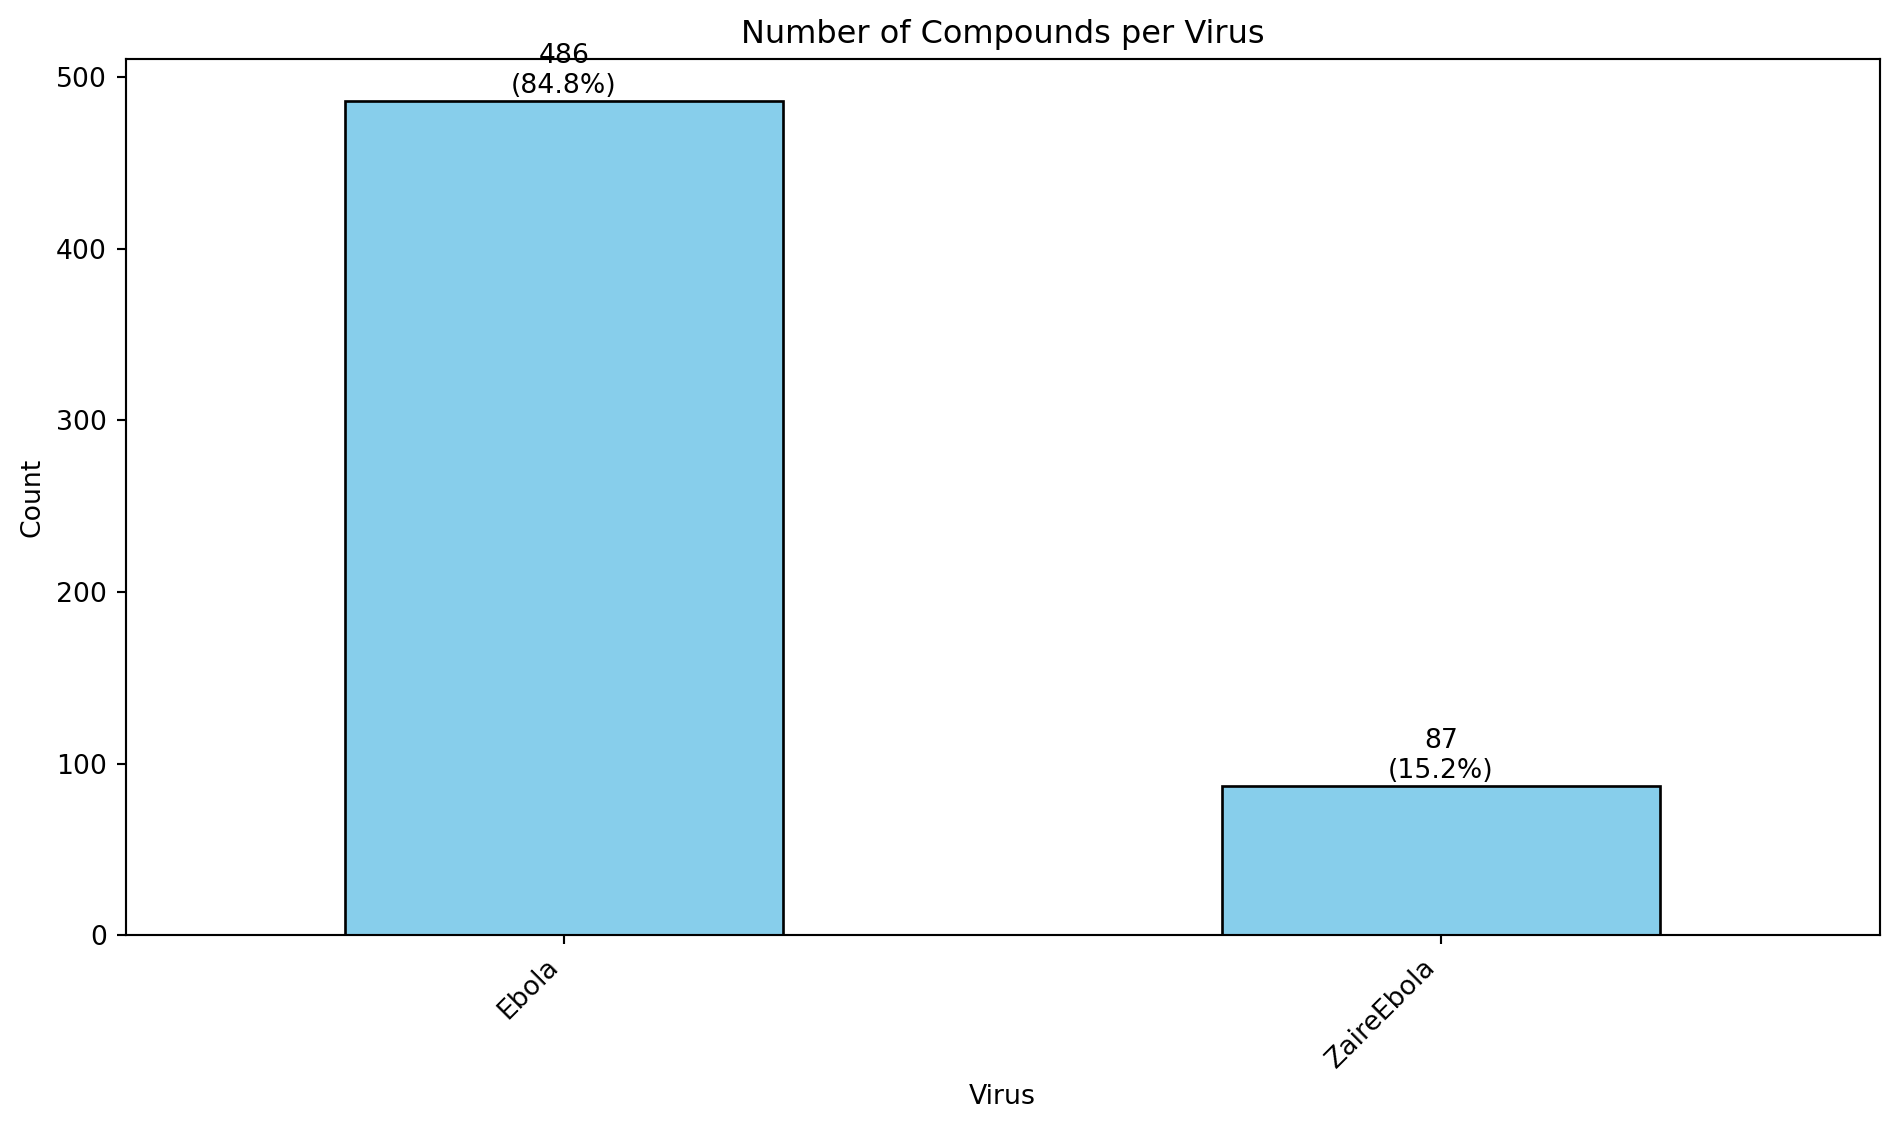

In [305]:
# Get counts and percentages
counts = combinedEbolaVirusData_chEMBL_noDuplicates['StrainClassifier'].value_counts()
percentages = counts / counts.sum() * 100

# Create bar plot
plt.figure(figsize=(10, 6))
bars = counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Compounds per Virus')
plt.xlabel('Virus')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with count and %
for i, (count, pct) in enumerate(zip(counts, percentages)):
    plt.text(
        i, count + 1,                 # position (x, y)
        f'{count}\n({pct:.1f}%)',     # label: count + percentage
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

In [306]:
combinedEbolaVirusData_chEMBL_noDuplicates.to_csv(os.path.join(modelBuildingDataDir, "combinedEbolaVirusData_chEMBL_noDuplicates_MLready.csv"), index=False)

### pPotency value distribution across each Virus

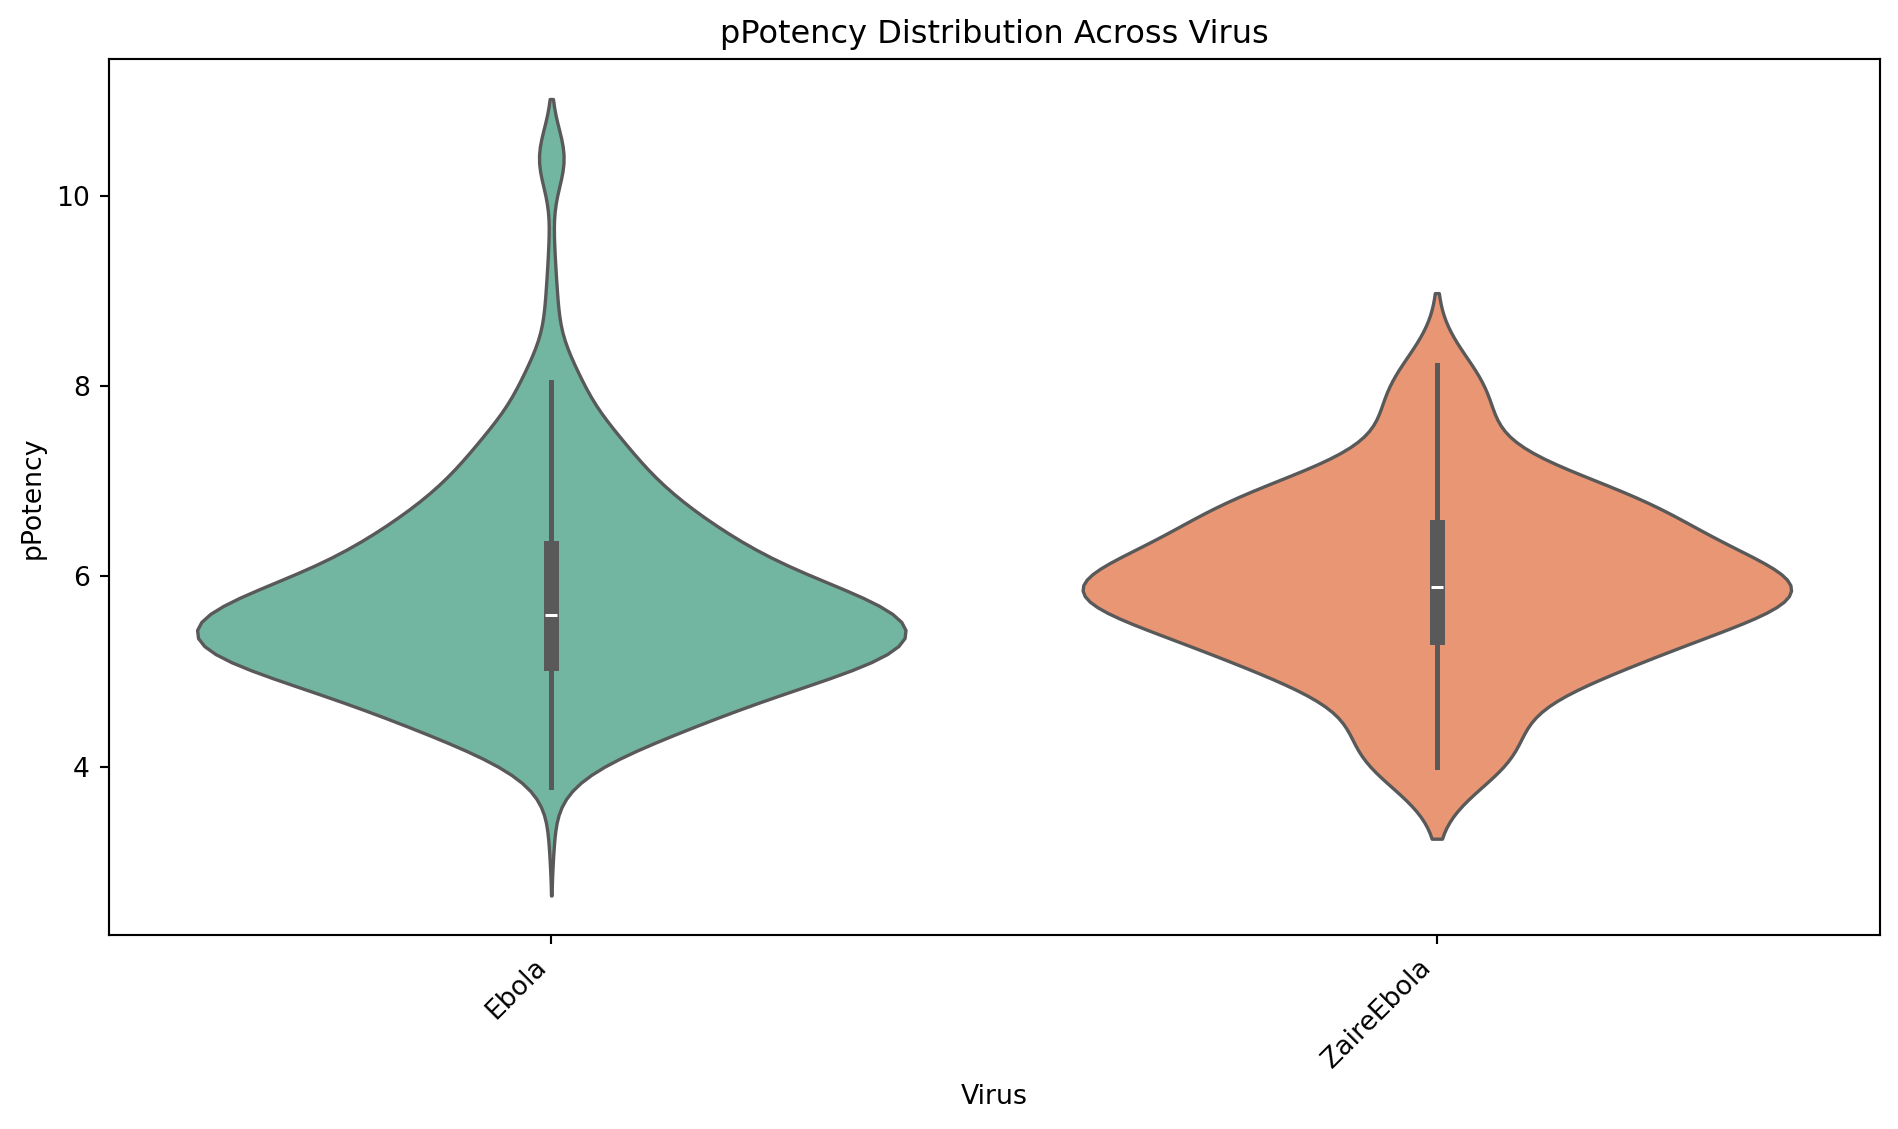

In [307]:
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=combinedEbolaVirusData_chEMBL_noDuplicates,
    x='StrainClassifier',
    y='pPotency',
    palette='Set2',
    inner='box'
)

plt.xticks(rotation=45, ha='right')
plt.title('pPotency Distribution Across Virus')
plt.xlabel('Virus')
plt.ylabel('pPotency')
plt.tight_layout()
plt.show()

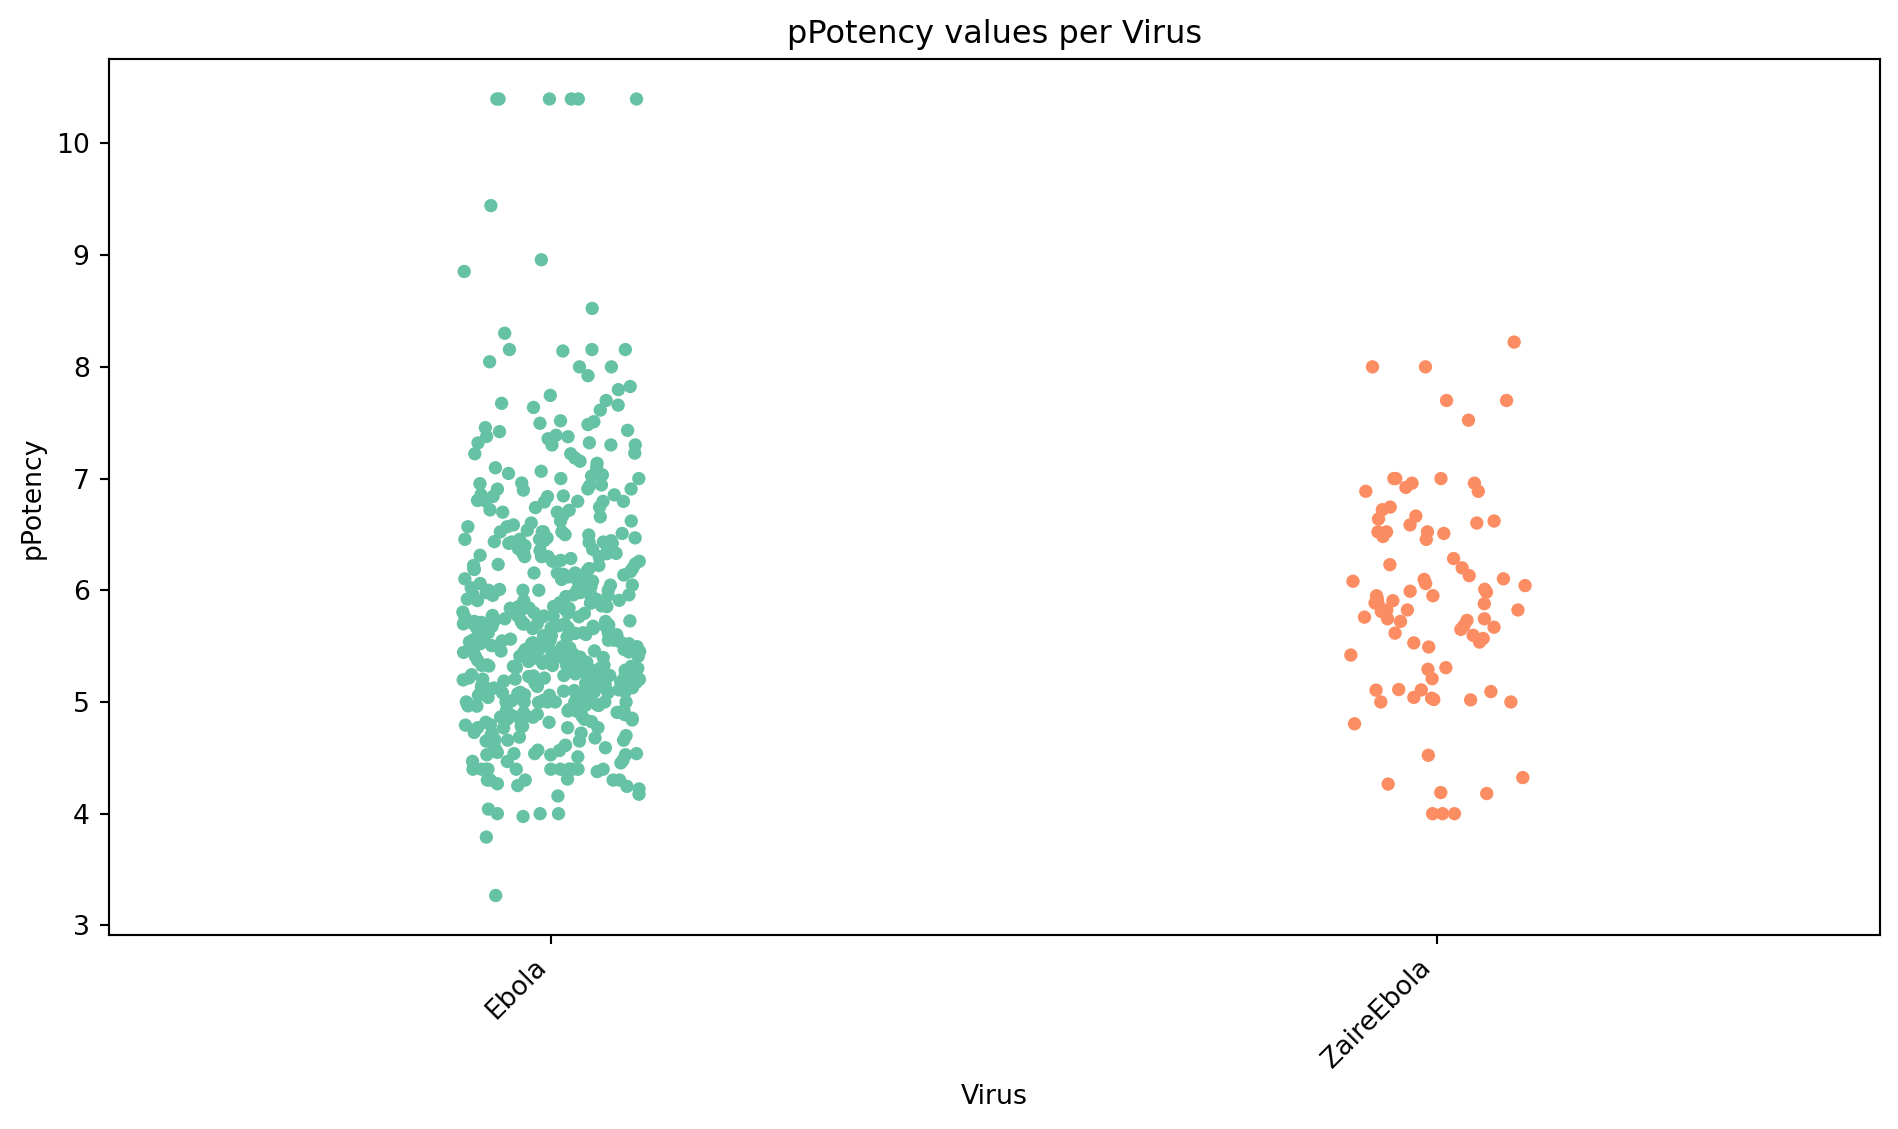

In [308]:
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=combinedEbolaVirusData_chEMBL_noDuplicates,
    x='StrainClassifier',
    y='pPotency',
    jitter=True,          # spreads the dots to avoid overlap
    palette='Set2',
    alpha=1
)
plt.xticks(rotation=45, ha='right')
plt.title('pPotency values per Virus')
plt.xlabel('Virus')
plt.ylabel('pPotency')
plt.tight_layout()
plt.show()

### Clip first 1000 rows from the data set for fast testing

### Train ML Model

In [309]:
# df = combinedEbolaVirusData_chEMBL_noDuplicates
Y = combinedEbolaVirusData_chEMBL_noDuplicates.pPotency
smiles = combinedEbolaVirusData_chEMBL_noDuplicates.Smiles

In [310]:
print(len(smiles))

573


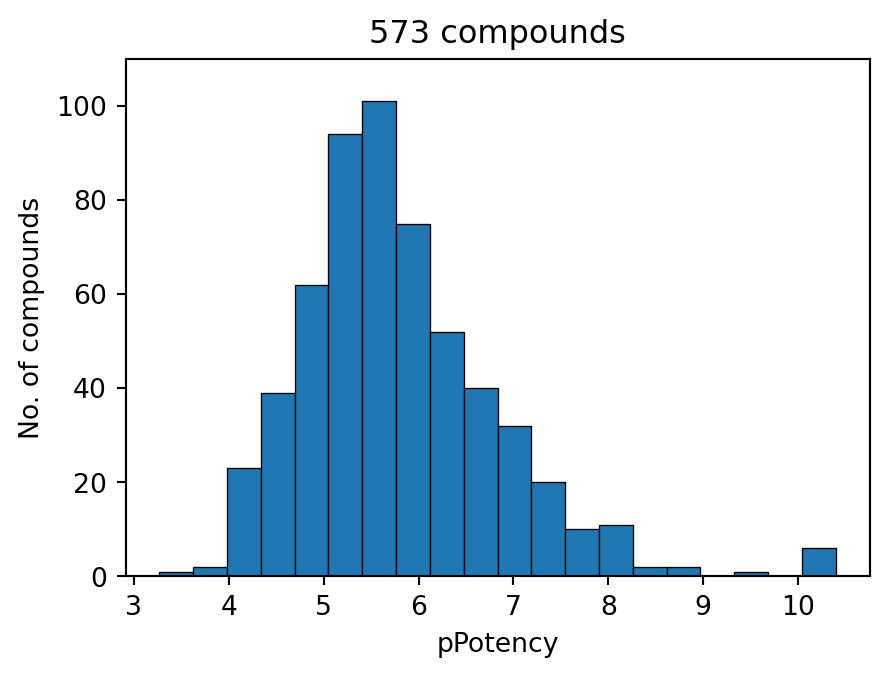

In [311]:
plot_histogram(Y, xlabel="pPotency")

Define the partitions for cross-validation.

In [312]:
num_of_partitions = 10
kf = KFold(n_splits=num_of_partitions, shuffle=True, random_state=42)

Define hyperparameters for SVR:

In [313]:
param_grid = {
    'C': [1, 5, 7, 10, 30, 50, 100, 300, 500], 
    'epsilon': [0.1, 0.3, 1, 3, 5, 10, 20],
    'kernel': ['rbf']
}

Define MACAW embedding:

In [314]:
mcw = MACAW(
    type_fp='atompairs', 
    metric='sokal', 
    n_components=15, 
    n_landmarks=200, 
    random_state=39
)


After cleaning NaN values, reset the indices

In [315]:
valid_mask = Y.notna()
smiles = smiles[valid_mask].reset_index(drop=True)  
Y = Y[valid_mask].reset_index(drop=True)            

print(f"Cleaned data has: {len(smiles)} samples")
print(f"Y index: {Y.index[:10].tolist()}")  

Cleaned data has: 573 samples
Y index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### ML predictions with Train + Test results

In [316]:
%%time
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import Parallel, delayed
from copy import deepcopy

def process_fold(fold_id, train_index, test_index, smiles, Y, mcw, param_grid, num_partitions):
    """Process a single CV fold"""
    print(f"Partition {fold_id}/{num_partitions}")
    
    # Split data
    smi_train = smiles.iloc[train_index]
    smi_test = smiles.iloc[test_index]
    y_train = Y[train_index]
    y_test = Y[test_index]
    
    # Compute MACAW embeddings (clone to avoid conflicts)
    mcw_fold = deepcopy(mcw)
    mcw_fold.fit(smi_train, y_train)
    
    X_train = mcw_fold.transform(smi_train)
    X_test = mcw_fold.transform(smi_test)
    
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    
    best_params = grid.best_params_
    
    # Predict on both train and test
    y_cv_pred_train = grid.predict(X_train)
    y_cv_pred_test = grid.predict(X_test)
    
    # Calculate fold metrics
    train_mae = mean_absolute_error(y_train, y_cv_pred_train)
    test_mae = mean_absolute_error(y_test, y_cv_pred_test)
    print(f"  Fold {fold_id} - Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    
    # Return all predictions and parameters
    return {
        'train_pred': y_cv_pred_train,
        'train_obs': y_train,
        'test_pred': y_cv_pred_test,
        'test_obs': y_test,
        'best_params': best_params
    }

# Parallel execution
results = Parallel(n_jobs=4, verbose=10)(
    delayed(process_fold)(
        fold_id=i+1,
        train_index=train_idx,
        test_index=test_idx,
        smiles=smiles,
        Y=Y,
        mcw=mcw,
        param_grid=param_grid,
        num_partitions=num_of_partitions
    )
    for i, (train_idx, test_idx) in enumerate(kf.split(smiles))
)

# Combine results
Y_cv_pred_train = []
Y_obs_train = []
Y_cv_pred_test = []
Y_obs_test = []
best_params_per_fold = []

for fold_result in results:
    Y_cv_pred_train.extend(fold_result['train_pred'])
    Y_obs_train.extend(fold_result['train_obs'])
    Y_cv_pred_test.extend(fold_result['test_pred'])
    Y_obs_test.extend(fold_result['test_obs'])
    best_params_per_fold.append(fold_result['best_params'])

# Convert to numpy arrays
Y_cv_pred_train = np.array(Y_cv_pred_train)
Y_obs_train = np.array(Y_obs_train)
Y_cv_pred_test = np.array(Y_cv_pred_test)
Y_obs_test = np.array(Y_obs_test)

# ===== OVERALL METRICS =====
print("\n" + "-"*40)
print("Cross Validation Metrics")
print("-"*40)

# Train metrics
train_mae = mean_absolute_error(Y_obs_train, Y_cv_pred_train)
train_rmse = np.sqrt(mean_squared_error(Y_obs_train, Y_cv_pred_train))
train_r2 = r2_score(Y_obs_train, Y_cv_pred_train)

print(f"Train Set:")
print(f"  MAE:  {train_mae:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  R²:   {train_r2:.2f}")

# Test metrics
test_mae = mean_absolute_error(Y_obs_test, Y_cv_pred_test)
test_rmse = np.sqrt(mean_squared_error(Y_obs_test, Y_cv_pred_test))
test_r2 = r2_score(Y_obs_test, Y_cv_pred_test)

print(f"Test Set:")
print(f"  MAE:  {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R²:   {test_r2:.2f}")

print(f"\nBest params (sample): {best_params_per_fold[:3]}")


----------------------------------------
Cross Validation Metrics
----------------------------------------
Train Set:
  MAE:  0.34
  RMSE: 0.50
  R²:   0.78
Test Set:
  MAE:  0.47
  RMSE: 0.63
  R²:   0.64

Best params (sample): [{'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}, {'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}, {'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}]
CPU times: user 207 ms, sys: 105 ms, total: 311 ms
Wall time: 6.61 s


Saved: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_noDuplicates_CV_TrTs.svg
Saved: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_noDuplicates_CV_TrTs.png


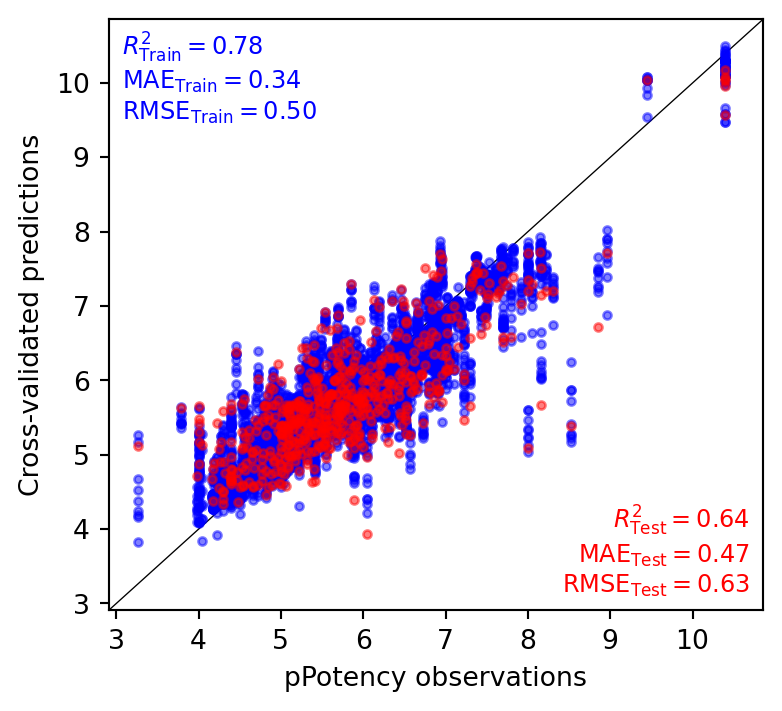

In [317]:
parity_plot(x=Y_obs_train, 
            y=Y_cv_pred_train, 
            x_test=Y_obs_test, 
            y_test=Y_cv_pred_test, 
            xlabel="pPotency observations", 
            ylabel="Cross-validated predictions",
            savetitle=resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_noDuplicates_CV_TrTs.svg',
            save_formats=['svg', 'png'])

Generate a model trained on the whole data set, to be used for prediction tasks

In [318]:
mcw = MACAW(
    type_fp='atompairs', 
    metric='sokal', 
    n_components=15, 
    n_landmarks=200, 
    random_state=39
)
mcw.fit(smiles, Y)

In [319]:
X_all = mcw.transform(smiles)
X_all.shape

(573, 15)

Training samples: 458
Test samples: 115
Feature dimensions: 15

Running GridSearchCV with 4 parallel jobs...

------------------------------------------------------------
Best Hyperparameters:
------------------------------------------------------------
  C: 5
  epsilon: 0.1
  kernel: rbf

Best CV MAE (on training folds): 0.47

------------------------------------------------------------
PERFORMANCE COMPARISON:
------------------------------------------------------------
Metric     Training        Test            Difference     
------------------------------------------------------------
R²         0.79            0.72            0.06           
MAE        0.32            0.45            0.13           
RMSE       0.48            0.59            0.11           
------------------------------------------------------------

 Good generalization performance!

Saved: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_noDuplicate

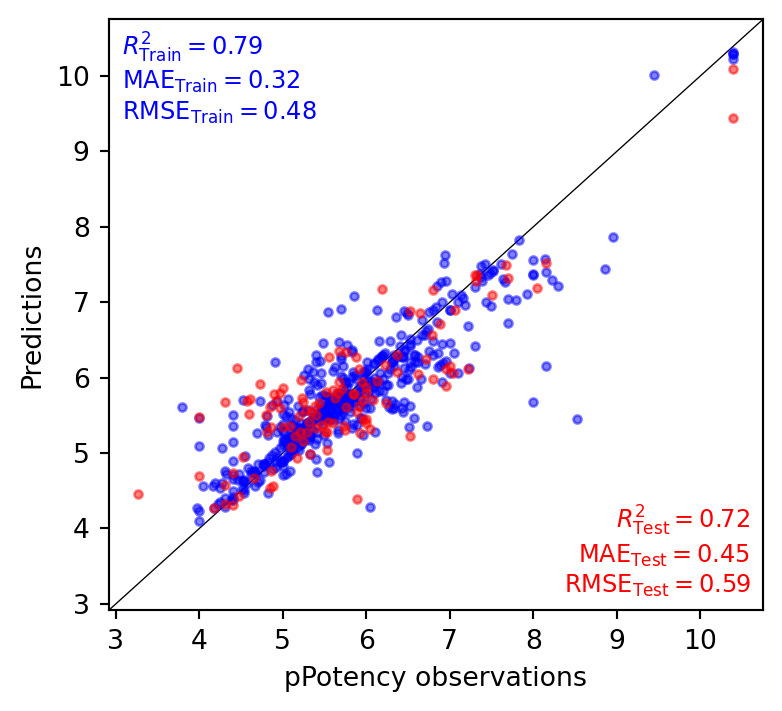

CPU times: user 1.27 s, sys: 84.5 ms, total: 1.35 s
Wall time: 1.67 s


In [320]:
%%time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ---------------------------
# 1. TRAIN-TEST SPLIT
# ---------------------------
# Since you're working with only one virus group, use regular train_test_split
X_train_smi, X_test_smi, Y_train, Y_test = train_test_split(
    smiles, Y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"Training samples: {len(X_train_smi)}")
print(f"Test samples: {len(X_test_smi)}")

# ---------------------------
# 2. FIT MACAW ON TRAINING DATA ONLY
# ---------------------------
mcw = MACAW(
    type_fp='atompairs', 
    metric='sokal', 
    n_components=15, 
    n_landmarks=200, 
    random_state=39
)
mcw.fit(X_train_smi, Y_train)

# Transform both train and test
X_train = mcw.transform(X_train_smi)
X_test = mcw.transform(X_test_smi)

print(f"Feature dimensions: {X_train.shape[1]}")

# ---------------------------
# 3. GRID SEARCH ON TRAINING DATA ONLY
# ---------------------------
n_jobs = 4

regr_pred = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=5,
    refit=True,
    n_jobs=n_jobs,
    verbose=0,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    pre_dispatch='2*n_jobs'
)

print(f"\nRunning GridSearchCV with {n_jobs} parallel jobs...")
regr_pred.fit(X_train, Y_train)

# ---------------------------
# 4. DISPLAY BEST HYPERPARAMETERS
# ---------------------------
print("\n" + "-"*60)
print("Best Hyperparameters:")
print("-"*60)
for param, value in regr_pred.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV MAE (on training folds): {-regr_pred.best_score_:.2f}")

# ---------------------------
# 5. PREDICTIONS AND METRICS
# ---------------------------
# Training predictions (in-sample)
y_train_pred = regr_pred.predict(X_train)

# Test predictions (held-out)
y_test_pred = regr_pred.predict(X_test)

# Calculate metrics for TRAIN
train_r2 = r2_score(Y_train, y_train_pred)
train_mae = mean_absolute_error(Y_train, y_train_pred)
train_rmse = np.sqrt(np.mean((Y_train - y_train_pred)**2))

# Calculate metrics for TEST
test_r2 = r2_score(Y_test, y_test_pred)
test_mae = mean_absolute_error(Y_test, y_test_pred)
test_rmse = np.sqrt(np.mean((Y_test - y_test_pred)**2))

# ---------------------------
# 6. DISPLAY RESULTS
# ---------------------------
print("\n" + "-"*60)
print("PERFORMANCE COMPARISON:")
print("-"*60)
print(f"{'Metric':<10} {'Training':<15} {'Test':<15} {'Difference':<15}")
print("-"*60)
print(f"{'R²':<10} {train_r2:<15.2f} {test_r2:<15.2f} {abs(train_r2-test_r2):<15.2f}")
print(f"{'MAE':<10} {train_mae:<15.2f} {test_mae:<15.2f} {abs(train_mae-test_mae):<15.2f}")
print(f"{'RMSE':<10} {train_rmse:<15.2f} {test_rmse:<15.2f} {abs(train_rmse-test_rmse):<15.2f}")
print("-"*60)

# Check for overfitting
overfit_gap = train_r2 - test_r2
if overfit_gap > 0.1:
    print("\n  WARNING: Possible overfitting detected (R² gap > 0.1)")
elif test_r2 >= 0.7:
    print("\n Good generalization performance!")

print("\n" + "="*60)

# ---------------------------
# 7. GENERATE PARITY PLOT
# ---------------------------
parity_plot(
    x=Y_train,                      # observed train
    y=y_train_pred,                 # predicted train (in-sample)
    x_test=Y_test,                  # observed test
    y_test=y_test_pred,             # predicted test (held-out)
    xlabel="pPotency observations",
    ylabel="Predictions",
    savetitle=resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_noDuplicates_fullData_TrTs.svg',
    save_formats=['svg', 'png']
)

### Compare performance of different ML model

- SVR
- Random Forest
- XGBoost
- LightGBM
- CatBoost
- Neural Network

Import all necessary libraries

## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [321]:
EnamineAntiviralsData = pd.read_csv(dataDir + "Enamine/Enamine_Antiviral_Library_plated_3200cmpds_20251019.csv",
                                    sep=",", comment=None, skipinitialspace=True, engine="python", encoding="utf-8",          
                                    skiprows=1, skip_blank_lines=True)
print(f"Original Enamine data shape: {EnamineAntiviralsData.shape}")

smiles_train = combinedEbolaVirusData_chEMBL_noDuplicates.Smiles

# Function to canonicalize SMILES using RDKit
def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            return Chem.MolToSmiles(mol, canonical=True)
        else:
            return None
    except:
        return None

# Canonicalize training SMILES and create a set for fast lookup
canonical_train = set()
for smi in smiles_train:
    canonical_smi = canonicalize_smiles(smi)
    if canonical_smi is not None:
        canonical_train.add(canonical_smi)

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to Enamine data
EnamineAntiviralsData['Canonical_SMILES'] = EnamineAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~EnamineAntiviralsData['Canonical_SMILES'].isin(canonical_train)
EnamineAntiviralsData_filtered = EnamineAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
EnamineAntiviralsData = EnamineAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered Enamine data shape for validation: {EnamineAntiviralsData.shape}")
print(f"Removed {EnamineAntiviralsData.shape[0] - EnamineAntiviralsData_filtered.shape[0]} duplicate compounds from Enamine data set")

# Now use the filtered data
smi_lib = EnamineAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
EnamineAntiviralsData.head()

Original Enamine data shape: (3200, 11)
Number of unique SMILES in training set: 540
Filtered Enamine data shape for validation: (3200, 11)
Removed 0 duplicate compounds from Enamine data set
Total compounds to screen: 3200


SMILES  Catalog ID      MW  MW (desalted)  \
0        COCC(C)NC(=O)NC1=NN=C(S1)C2CC2  Z410227912 256.326        256.326   
1       CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O  Z383167688 237.256        237.256   
2    CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2  Z235579208 306.404        306.404   
3     CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2  Z403694008 279.379        279.379   
4  CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2  Z384461492 307.389        307.389   

   ClogP   logS  HBD  HBA   TPSA  RotBonds  \
0  1.231 -2.190    2    4 76.140         5   
1 -0.042 -0.692    1    3 69.720         5   
2  1.583 -2.082    1    5 57.700         7   
3  1.156 -0.660    1    3 58.370         7   
4  1.084 -1.180    1    4 61.880         7   

                                     AnalogsFromREAL  
0  https://real.enamine.net/public-enum-files/Z41...  
1  https://real.enamine.net/public-enum-files/Z38...  
2                                                NaN  
3  https://real.enamine.net/public-enum-files/Z40...  
4  https://real.enamine.net/public-enum-files/Z38...

Generate predictions for the H1 receptor:

In [322]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [323]:
EnamineAntiviralsData_predicted = EnamineAntiviralsData.copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
EnamineAntiviralsData_predicted['pPotency(M)_prediction'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_prediction'])

EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction",  "pPotency(M)_prediction"]
)
EnamineAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_EnamineDatasets_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_EnamineDatasets_predicted_all_SMILES.csv"), index=False)
EnamineAntiviralsData_predicted

SMILES  pPotency_prediction  \
0               COCC(C)NC(=O)NC1=NN=C(S1)C2CC2                4.644   
1              CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O                4.861   
2           CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2                4.637   
3            CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2                4.930   
4         CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2                5.105   
...                                        ...                  ...   
3195        CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23                5.171   
3196   CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C                5.164   
3197        CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O                5.162   
3198   CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C                5.453   
3199  CCC1(C)CN(CCO1)C(=O)NCC(C)(C)C=2C=CN=CC2                5.272   

      pPotency(M)_prediction  
0                  2.268e-05  
1                  1.379e-05  
2                  2.309e-05  
3                  1.174e-05  
4                  7.850e-06  
...                      ...  
3195               6.743e-06  
3196               6.861e-06  
3197               6.882e-06  
3198               3.520e-06  
3199               5.346e-06  

[3200 rows x 3 columns]

Let us represent the predictions of both models:

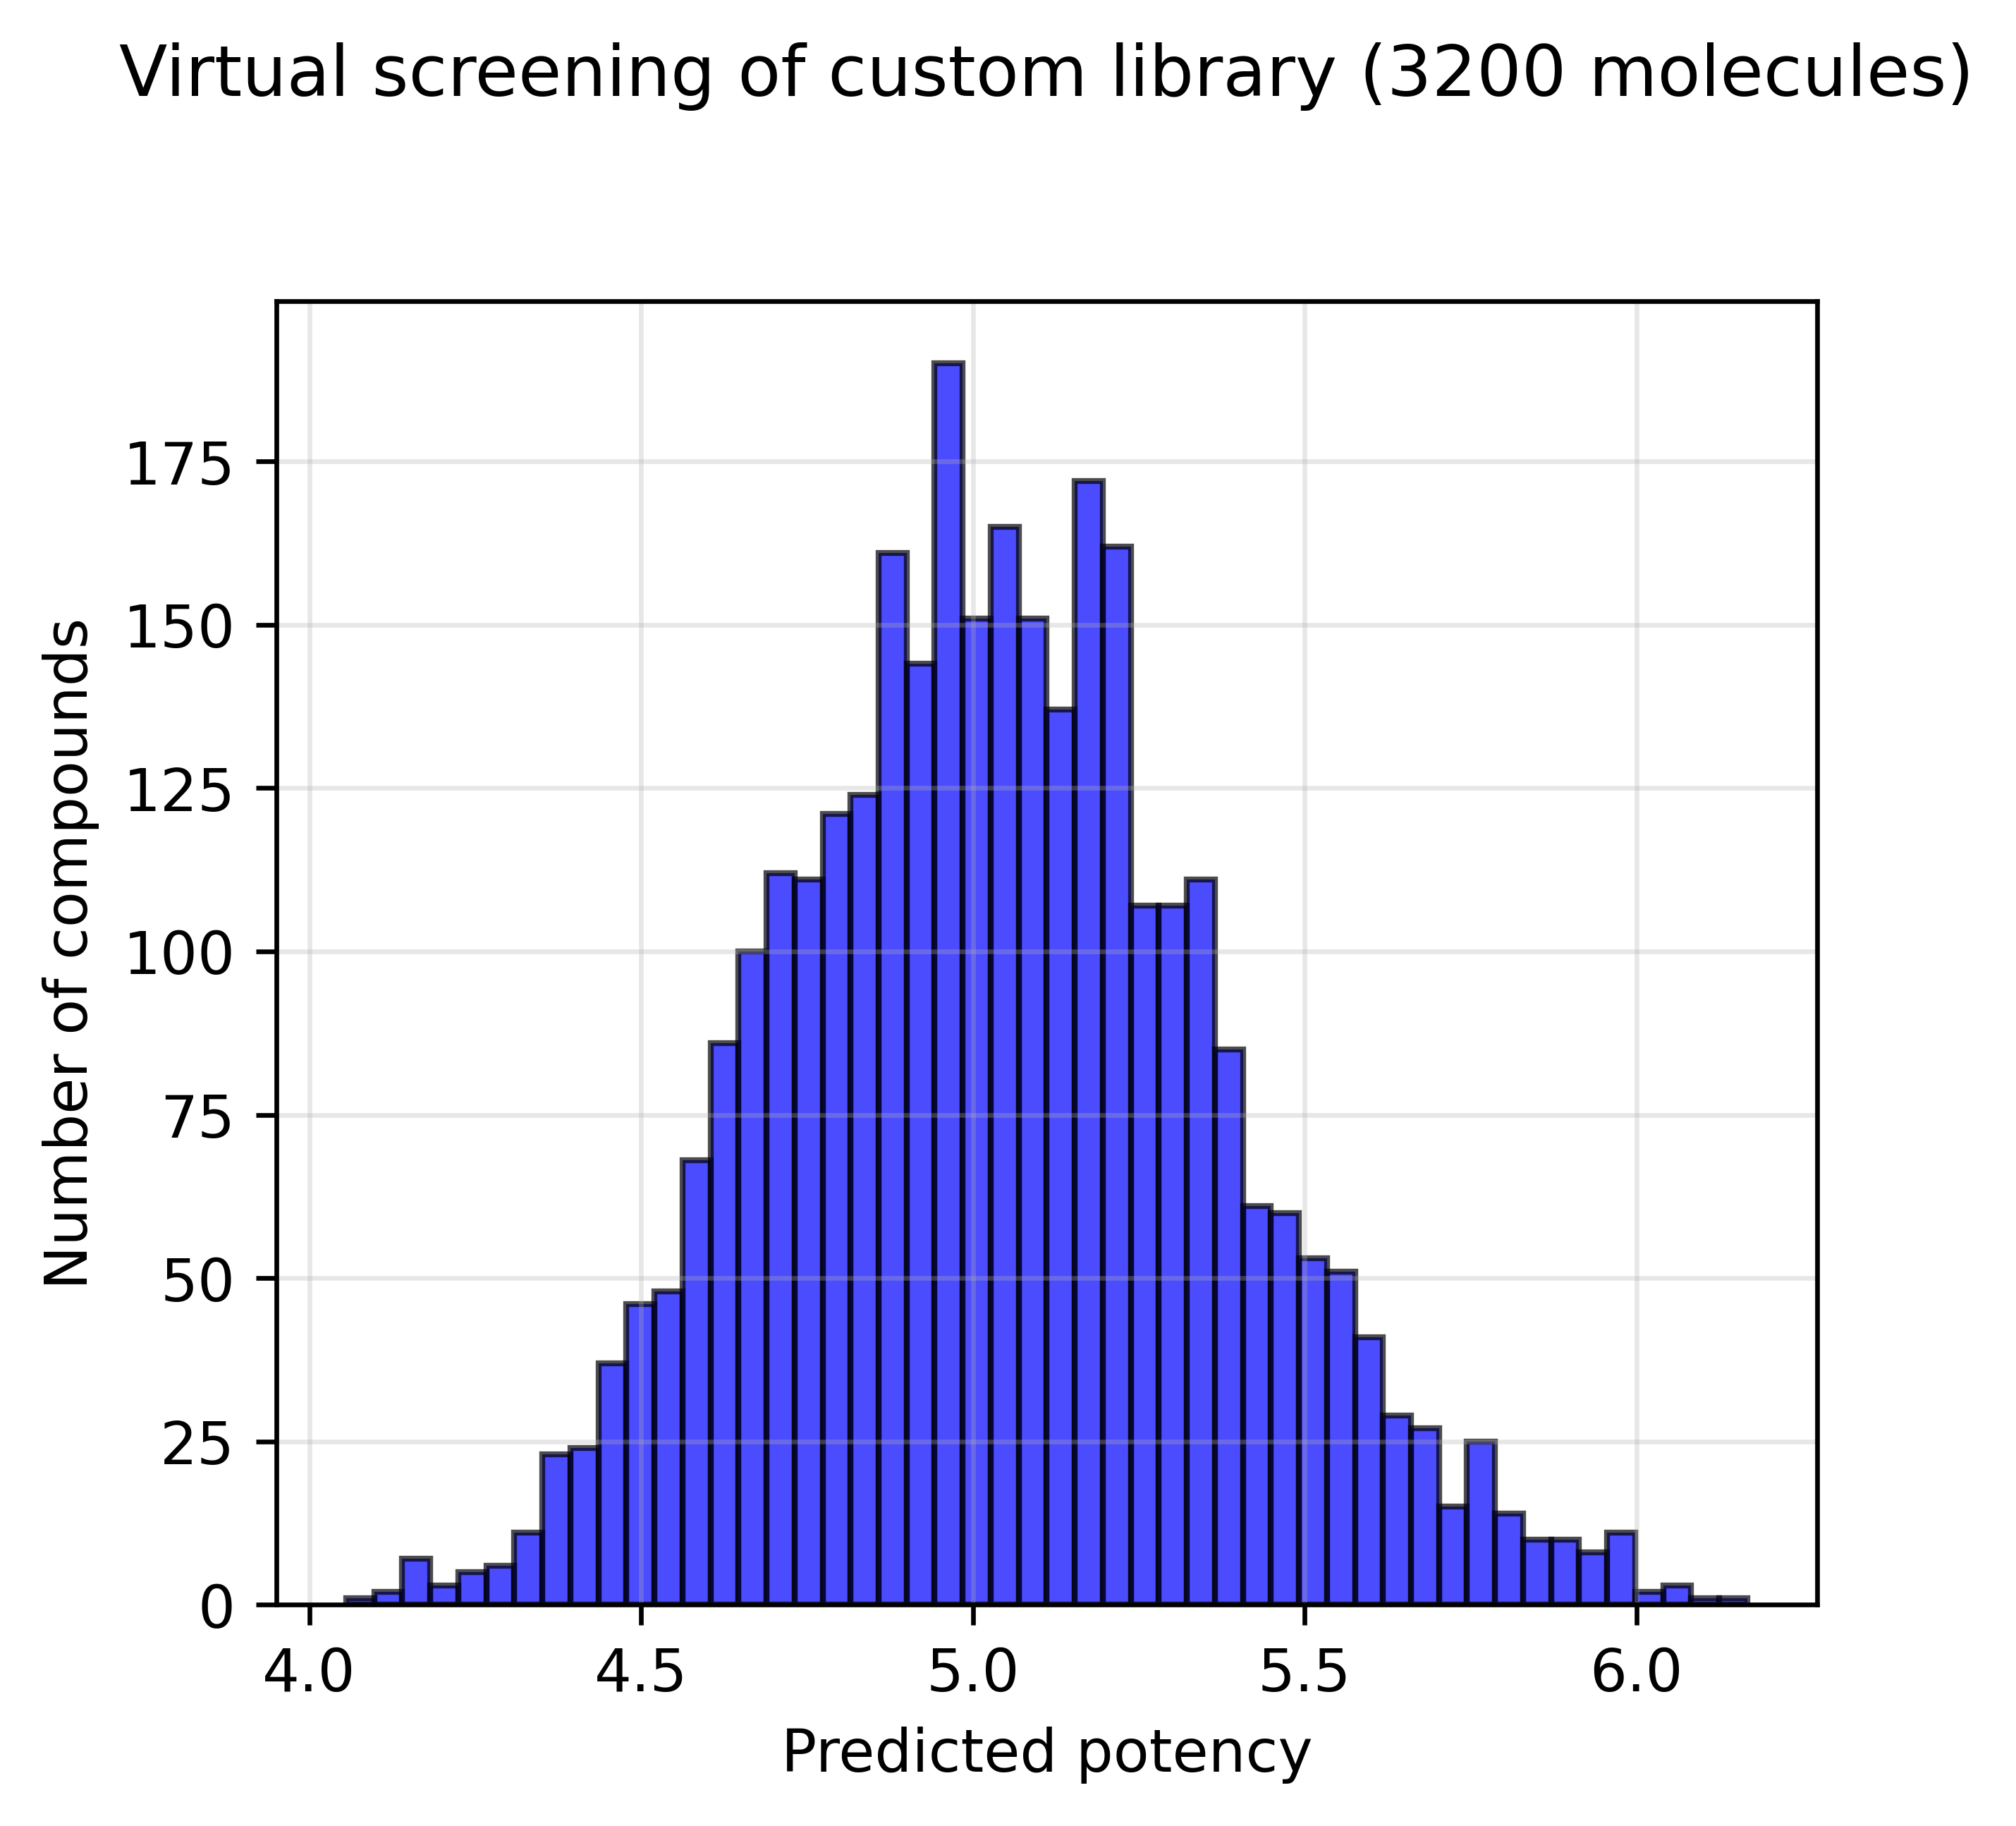

In [324]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
plt.title(f"Virtual screening of custom library ({len(smi_lib)} molecules)", pad=35)
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2, label='pPotency = 5.0 (minimum)') 
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2, label='pPotency = 6.0 (good)')
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2, label='pPotency = 7.0 (excellent)')

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_noDuplicates_validation.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_noDuplicates_validation.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [325]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 0 compounds
Medium priority (6 ≤ pPotency < 7.0): 7 compounds
Low priority (5 ≤ pPotency < 6): 1696 compounds


In [326]:
EnamineAntiviralsData_final = EnamineAntiviralsData.iloc[idx].copy()
EnamineAntiviralsData_final['pPotency_prediction'] = Y1_lib_pred[idx]

EnamineAntiviralsData_final

Empty DataFrame
Columns: [SMILES, Catalog ID, MW, MW (desalted), ClogP, logS, HBD, HBA, TPSA, RotBonds, AnalogsFromREAL, pPotency_prediction]
Index: []

### Top 20 compounds with higher PpPotency

In [327]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

Top 20 compounds cutoff pPotency: 5.94
Highest predicted pPotency: 6.17
Range of top 20: 5.94 - 6.17


In [328]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
EnamineAntiviralsData_top20 = EnamineAntiviralsData.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
EnamineAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
EnamineAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
EnamineAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
EnamineAntiviralsData_top20 = EnamineAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
EnamineAntiviralsData_top20

----------------------------------------------------------------------
Top 20 Compounds with Highest Predicted pPotency
----------------------------------------------------------------------

Cutoff Values (20th ranked compound):
  pPotency:    5.939
  IC50:        1.150e-06 M  (1150.41 nM)

Best Values (1st ranked compound):
  pPotency:    6.167
  IC50:        6.807e-07 M  (680.69 nM)
Range for Top 20 Compounds:
pPotency Range:  5.939 - 6.167

IC50 Range (M):  1.150e-06 - 6.807e-07


Rank                                         SMILES  \
564      1         O=C(CN1C=CC=NC1=O)NC2CCN(CC3CCCCC3)CC2   
2027     2      OCC1=NC=2C=CC=CC2N1CC(O)C=3C=C(Cl)C=CC3Cl   
2029     3        OCC1=NC=2C=CC=CC2N1CC(O)C=3C=CC(F)=CC3F   
836      4        OCC1=NC=2C=CC=CC2N1CC(O)C=3C=C(F)C=CC3F   
2595     5    CCN1CCOC(CNCC(O)CN2C=NC=3C=C(C)C(C)=CC32)C1   
2813     6  OCC1=NC=2C=CC=CC2N1CC(O)C=3C=CC=C(C3)C(F)(F)F   
2691     7  CC1=CC(=NC(C)=C1)NC(=O)NC2CCN(CC2)C3CCN(C)CC3   
1656     8     CC=1C=NC=C(C1)NC(=O)NC2CCN(CC2)C3CCN(C)CC3   
2964     9      OCCCC1=NC=2C=CC=CC2N1CC(O)C=3C=C(F)C=CC3F   
1235    10          OCC1=NC=2C=CC=CC2N1CC(O)C=3C=CC=CC3Cl   
22      11         OCC1=NC=2C=CC=CC2N1CC(O)C=3C=CC=C(F)C3   
1046    12           OCC1=NC=2C=CC=CC2N1CC(O)C=3C=CC=CC3F   
699     13     CC=1C=CC(=CN1)NC(=O)NC2CCN(CC2)C3CCN(C)CC3   
1956    14    CC=1C=C2N=CN(CC(O)CN3CCN(CC(C)O)CC3)C2=CC1C   
528     15        OCC1=NC=2C=CC=CC2N1CC(O)C=3C=CC(Cl)=CC3   
608     16         OCC1=NC=2C=CC=CC2N1CC(O)C=3C=CC(F)=CC3   
2912    17       CC1CCN(CC(O)CN2C=NC=3C=C(F)C(F)=CC32)CC1   
1486    18     CC=1C=CC=C(N1)NC(=O)NC2CCN(CC2)C3CCN(C)CC3   
2174    19       OCCCC1=NC=2C=CC=CC2N1CC(O)C=3C=CC(F)=CC3   
1758    20        CC1CCCN(CCCNC(=O)CN2C=CC(=O)N(C)C2=O)C1   

      pPotency_prediction  IC50 (M)  
564                 6.167 6.807e-07  
2027                6.088 8.174e-07  
2029                6.061 8.690e-07  
836                 6.060 8.716e-07  
2595                6.057 8.766e-07  
2813                6.009 9.805e-07  
2691                6.005 9.884e-07  
1656                5.998 1.005e-06  
2964                5.994 1.014e-06  
1235                5.989 1.026e-06  
22                  5.980 1.046e-06  
1046                5.975 1.059e-06  
699                 5.971 1.068e-06  
1956                5.971 1.070e-06  
528                 5.965 1.085e-06  
608                 5.964 1.087e-06  
2912                5.963 1.088e-06  
1486                5.960 1.096e-06  
2174                5.943 1.139e-06  
1758                5.939 1.150e-06

In [329]:
EnamineAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_EnamineAntiviralsData_top20.csv"), index=False)
EnamineAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_EnamineAntiviralsData_top20_SMILES.csv"), index=False)

 Saved PNG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_noDuplicates_enamine_predictedCompounds.png
 Saved SVG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_noDuplicates_enamine_predictedCompounds.svg


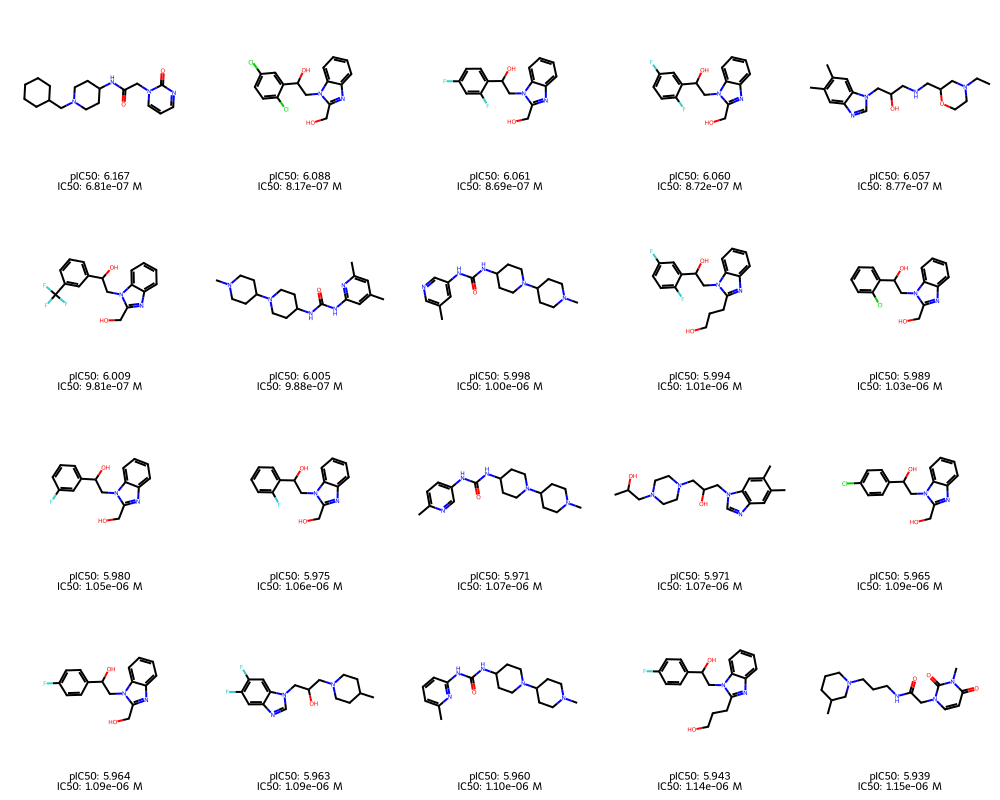

In [330]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image

# Setup paths
output_dir = resultsDir + 'combinedEbolaVirus/'
os.makedirs(output_dir, exist_ok=True)

# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in EnamineAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in EnamineAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = output_dir + 'combinedEbolaVirus_noDuplicates_enamine_predictedCompounds.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = output_dir + 'combinedEbolaVirus_noDuplicates_enamine_predictedCompounds.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

## 2.2 Discovery of new hits specific to all viruses (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [331]:
# Read all molecules from SDF
supplier = Chem.SDMolSupplier(dataDir + "LifeChemicals/LC_Merged_Antiviral_Screening_Superset.sdf")
mols = [mol for mol in supplier if mol is not None]

# Extract properties into DataFrame
records = []
for mol in mols:
    props = mol.GetPropsAsDict()
    props["SMILES"] = Chem.MolToSmiles(mol)
    records.append(props)

LCAntiviralsData_superset = pd.DataFrame(records)
print(f"Original LifeChemicals data shape: {LCAntiviralsData_superset.shape}")

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to LifeChemicals data (reusing canonical_train from code-1)
LCAntiviralsData_superset['Canonical_SMILES'] = LCAntiviralsData_superset['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~LCAntiviralsData_superset['Canonical_SMILES'].isin(canonical_train)
LCAntiviralsData_superset_filtered = LCAntiviralsData_superset[mask].copy()

# Remove the helper column if you don't need it
LCAntiviralsData_superset = LCAntiviralsData_superset_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered LifeChemicals data shape for validation: {LCAntiviralsData_superset.shape}")
print(f"Removed {LCAntiviralsData_superset_filtered.shape[0] - LCAntiviralsData_superset.shape[0]} duplicate compounds from LifeChemicals data set")

# Now use the filtered data
smi_lib = LCAntiviralsData_superset.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
LCAntiviralsData_superset.head()

Original LifeChemicals data shape: (45573, 17)
Number of unique SMILES in training set: 540
Filtered LifeChemicals data shape for validation: (45573, 17)
Removed 0 duplicate compounds from LifeChemicals data set
Total compounds to screen: 45573


IDNUMBER                                      Chemical_Name  \
0  F6544-0534  11-(oxan-4-yl)-7,11-diazatricyclo[7.3.1.0²,⁷]t...   
1  F6559-5304  6-[4-(trifluoromethyl)pyrimidin-2-yl]-6-azaspi...   
2  F6610-6619    1-methyl-4-[(pyridin-4-yl)methyl]-1,4-diazepane   
3  F6559-5274  6-(4,6-dimethylpyrimidin-2-yl)-6-azaspiro[3.4]...   
4  F1912-1536  N-cyclopropyl-N-(piperidin-4-yl)pyrimidin-4-amine   

            CAS  PriceCoeff      MW Description  FSP3  clogP   TPSA Acceptor  \
0  2034607-75-3       1.500 274.360       solid 0.690 -0.120 32.780        2   
1  2034225-11-9       1.500 301.260       solid 0.620  2.030 66.320        4   
2  2320860-02-2       1.000 205.300         oil 0.580  0.890 19.370        3   
3  2034225-08-4       1.500 261.320         oil 0.640  2.090 66.320        4   
4  1781768-10-2       1.500 218.290       solid 0.670  0.790 41.050        2   

  Donor  RotBonds    HAC Collection  \
0     1         1 20.000   Advanced   
1     1         2 21.000   Advanced   
2     3         2 15.000    General   
3     1         2 19.000   Advanced   
4     2         3 16.000   Advanced   

                                             Library PPDS  \
0              Anti-Hepatitis_A_B_ Screening_Library        
1           2019-nCoV_Main_Protease_Targeted_Library    +   
2                           Anti-HIV_Focused_Library        
3  Antiviral_Screening_Compound_Library_2D_Simila...        
4  Antiviral_Screening_Compound_Library_2D_Simila...        

                                   SMILES  
0      Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1  
1  O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2  
2                   CN1CCCN(Cc2ccncc2)CC1  
3    Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1  
4              c1cc(N(C2CCNCC2)C2CC2)ncn1

Generate predictions for the H1 receptor:

In [332]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [333]:
LCAntiviralsData_predicted = LCAntiviralsData_superset.copy()
LCAntiviralsData_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
LCAntiviralsData_predicted['pPotency(M)_prediction'] = 10 ** (-LCAntiviralsData_predicted['pPotency_prediction'])

LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction",  "pPotency(M)_prediction"]
)
LCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_LCDatasets_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_LCDatasets_predicted_all_SMILES.csv"), index=False)
LCAntiviralsData_predicted

SMILES  pPotency_prediction  \
0                     Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1                5.270   
1                 O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2                5.530   
2                                  CN1CCCN(Cc2ccncc2)CC1                4.759   
3                   Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1                5.059   
4                             c1cc(N(C2CCNCC2)C2CC2)ncn1                4.930   
...                                                  ...                  ...   
45568  CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...                5.819   
45569  CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....                5.557   
45570    COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl                5.312   
45571  CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...                6.029   
45572  CCN1/C(=C/C2=CC3=C/C(=C/c4sc5ccc(SC)cc5[n+]4CC...                6.097   

       pPotency(M)_prediction  
0                   5.372e-06  
1                   2.953e-06  
2                   1.740e-05  
3                   8.722e-06  
4                   1.174e-05  
...                       ...  
45568               1.517e-06  
45569               2.771e-06  
45570               4.879e-06  
45571               9.356e-07  
45572               7.997e-07  

[45573 rows x 3 columns]

Let us represent the predictions of both models:

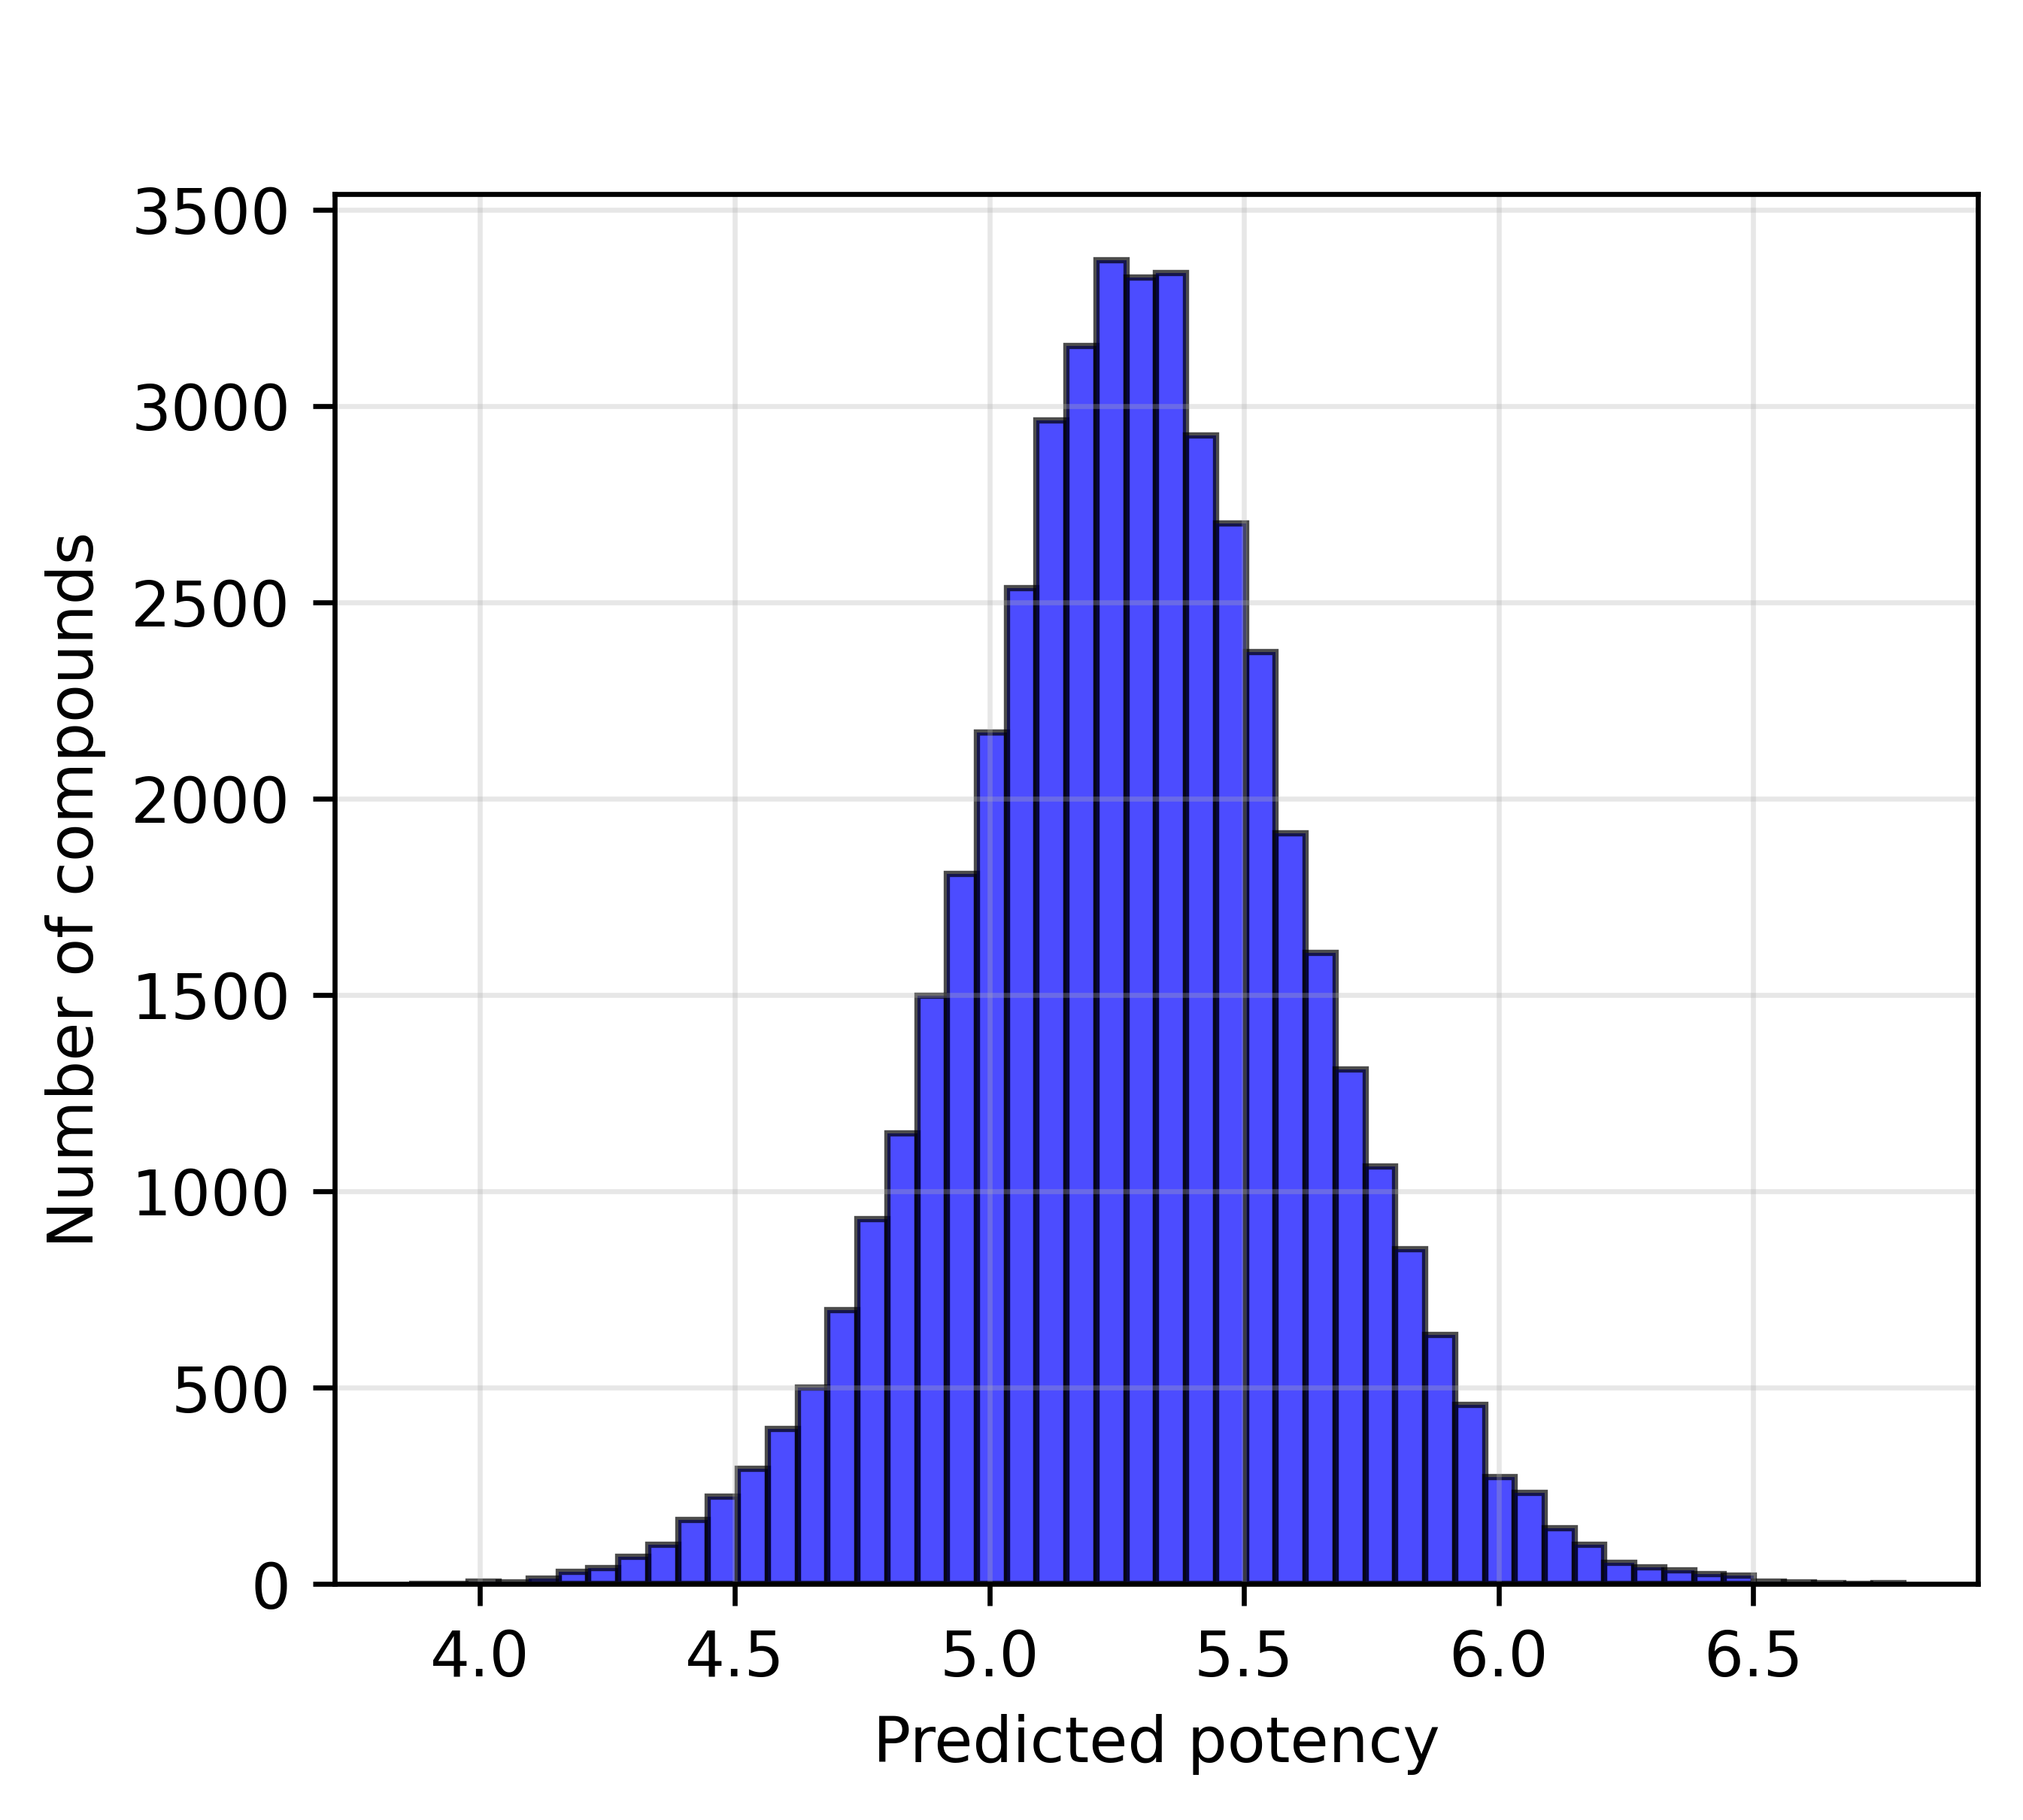

In [334]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_noDuplicates_validation_LCDatasets.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_noDuplicates_validation_LCDatasets.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [335]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 0 compounds
Medium priority (6 ≤ pPotency < 7.0): 804 compounds
Low priority (5 ≤ pPotency < 6): 35983 compounds


In [336]:
LCAntiviralsData_superset_final = LCAntiviralsData_superset.iloc[idx].copy()
LCAntiviralsData_superset_final['pPotency_prediction'] = Y1_lib_pred[idx]
LCAntiviralsData_superset_final = LCAntiviralsData_superset_final.filter(
    items=["SMILES", "pPotency_prediction", "clogP"]
)
LCAntiviralsData_superset_final

Empty DataFrame
Columns: [SMILES, pPotency_prediction, clogP]
Index: []

### Top 20 compounds with higher PpPotency

In [337]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

Top 20 compounds cutoff pPotency: 6.49
Highest predicted pPotency: 6.79
Range of top 20: 6.49 - 6.79


In [338]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
LCAntiviralsData_top20 = LCAntiviralsData_superset.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
LCAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
LCAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
LCAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
LCAntiviralsData_top20 = LCAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
LCAntiviralsData_top20

----------------------------------------------------------------------
Top 20 Compounds with Highest Predicted pPotency
----------------------------------------------------------------------

Cutoff Values (20th ranked compound):
  pPotency:    6.493
  IC50:        3.213e-07 M  (321.26 nM)

Best Values (1st ranked compound):
  pPotency:    6.795
  IC50:        1.605e-07 M  (160.49 nM)
Range for Top 20 Compounds:
pPotency Range:  6.493 - 6.795

IC50 Range (M):  3.213e-07 - 1.605e-07


Rank                                             SMILES  \
39062     1  CCOC(=O)c1c(C)n(-c2ccc(C)cc2)c2ccc(OCC(O)CN3CC...   
44367     2  CCOC(=O)c1c(C)n(-c2ccc(C)cc2)c2ccc(OCC(O)CN3CC...   
38256     3  CCOC(=O)c1c(C)n(-c2ccc(C)cc2)c2ccc(OCC(O)CN3CC...   
25908     4  COc1cc2c(=O)n(Cc3ccc(C(=O)N4CCCC4)cc3)c(=O)n(C...   
43899     5  Cc1ccc(S(=O)(=O)NCCCN(CCN(CCCNS(=O)(=O)c2ccc(C...   
12432     6  COc1ccc(-c2c(C)oc3cc(OCCN4CCN(C)CC4)ccc3c2=O)c...   
33545     7  COc1cc(OC)c(OC)cc1/C=C1\Oc2c(ccc(O)c2CN2CCC(C)...   
33546     8  COc1cc(OC)c(OC)cc1/C=C1\Oc2c(ccc(O)c2CN2CCCC(C...   
33681     9  COc1cc(OC)c(OC)cc1/C=C1\Oc2c(ccc(O)c2CN2CCCCCC...   
27386    10  COCCCNC(=O)c1ccc(Cn2c(=O)c3cc(OC)c(OC)cc3n(CC(...   
33174    11  COc1ccc(/C=C2\Oc3c(ccc(O)c3CN3CCC(C)CC3)C2=O)c...   
33350    12  COc1cc(OC)c(OC)cc1/C=C1\Oc2c(ccc(O)c2CN2CCCCC2...   
33253    13  COc1ccc(/C=C2\Oc3c(ccc(O)c3CN3CCCC(C)C3)C2=O)c...   
25862    14  CCC(C)NC(=O)Cn1c(=O)n(Cc2ccc(C(=O)N3CCCCC3)cc2...   
32450    15  COc1cc(/C=C2\Oc3c(ccc(O)c3CN3CCCC(C)C3)C2=O)cc...   
33351    16  COc1ccc(/C=C2\Oc3c(ccc(O)c3CN3CCCCCC3)C2=O)c(O...   
34621    17  CCCCN(C)Cc1c(O)ccc2c1O/C(=C\c1cc(OC)c(OC)cc1OC...   
32879    18  COc1cc(OC)c(OC)cc1/C=C1\Oc2c(ccc(O)c2CN2CCCCC2...   
35338    19  CCCN(CCC)Cc1c(O)ccc2c1O/C(=C\c1cc(OC)c(OC)c(OC...   
33173    20  COc1ccc(/C=C2\Oc3c(ccc(O)c3CN3CCCCC3C)C2=O)c(O...   

       pPotency_prediction  IC50 (M)  
39062                6.795 1.605e-07  
44367                6.771 1.693e-07  
38256                6.757 1.750e-07  
25908                6.664 2.166e-07  
43899                6.647 2.252e-07  
12432                6.603 2.497e-07  
33545                6.602 2.499e-07  
33546                6.587 2.586e-07  
33681                6.573 2.671e-07  
27386                6.569 2.699e-07  
33174                6.549 2.828e-07  
33350                6.546 2.846e-07  
33253                6.546 2.847e-07  
25862                6.532 2.935e-07  
32450                6.518 3.032e-07  
33351                6.517 3.043e-07  
34621                6.507 3.109e-07  
32879                6.500 3.165e-07  
35338                6.499 3.167e-07  
33173                6.493 3.213e-07

In [339]:
LCAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_LCAntiviralsData_top20.csv"), index=False)
LCAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_LCAntiviralsData_top20_SMILES.csv"), index=False)

 Saved PNG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_noDuplicates_predictedCompounds_LCDataset.png
 Saved SVG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_noDuplicates_predictedCompounds_LCDataset.svg


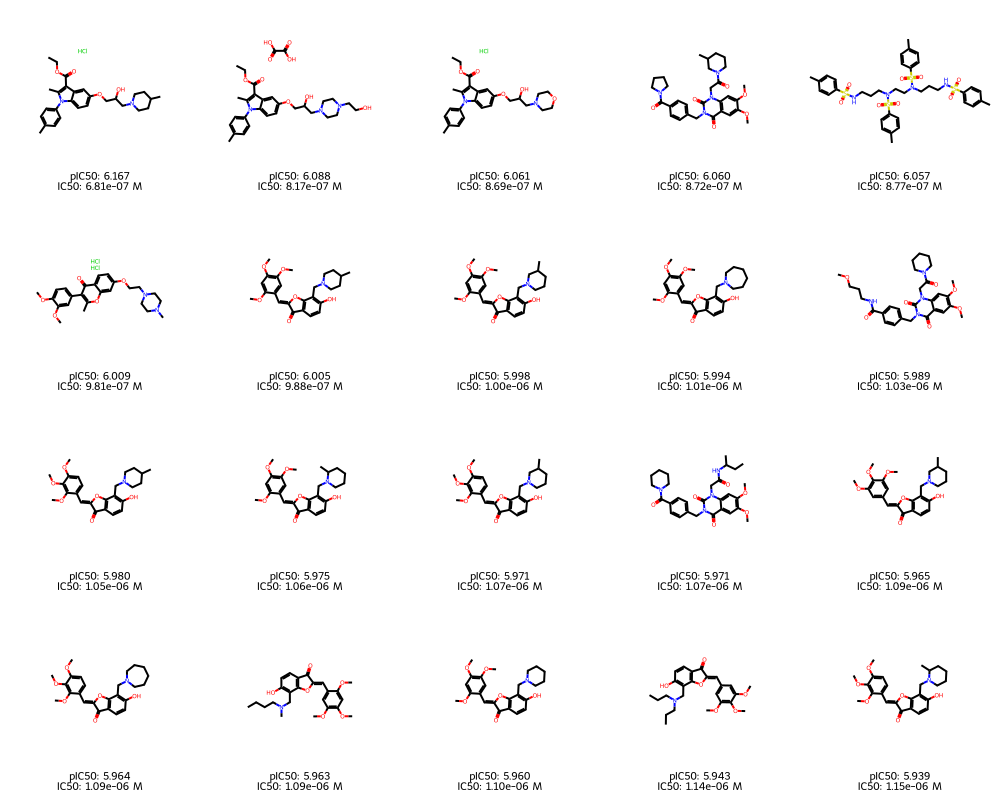

In [340]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image

# Setup paths
output_dir = resultsDir + 'combinedEbolaVirus/'
os.makedirs(output_dir, exist_ok=True)

# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in LCAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in EnamineAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = output_dir + 'combinedEbolaVirus_noDuplicates_predictedCompounds_LCDataset.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = output_dir + 'combinedEbolaVirus_noDuplicates_predictedCompounds_LCDataset.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

# 2.3 Discovery of new hits specific to all viruses (data source chemDiv data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [341]:
# Read all molecules from SDF
supplier = Chem.SDMolSupplier(dataDir + "ChemDiv/ChemDiv_Antiviral-Library-64958.sdf")
mols = [mol for mol in supplier if mol is not None]

# Extract properties into DataFrame
records = []
for mol in mols:
    props = mol.GetPropsAsDict()
    props["SMILES"] = Chem.MolToSmiles(mol)
    records.append(props)

ChemDivAntiviralsData = pd.DataFrame(records)
print(f"Original ChemDiv data shape: {ChemDivAntiviralsData.shape}")

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to ChemDiv data (reusing canonical_train from previous code)
ChemDivAntiviralsData['Canonical_SMILES'] = ChemDivAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~ChemDivAntiviralsData['Canonical_SMILES'].isin(canonical_train)
ChemDivAntiviralsData_filtered = ChemDivAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
ChemDivAntiviralsData = ChemDivAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered ChemDiv data shape for validation: {ChemDivAntiviralsData.shape}")
print(f"Removed {ChemDivAntiviralsData_filtered.shape[0] - ChemDivAntiviralsData.shape[0]} duplicate compounds from ChemDiv data set")

# Now use the filtered data
smi_lib = ChemDivAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
ChemDivAntiviralsData

Original ChemDiv data shape: (64958, 28)
Number of unique SMILES in training set: 540
Filtered ChemDiv data shape for validation: (64957, 28)
Removed 0 duplicate compounds from ChemDiv data set
Total compounds to screen: 64957


IDNUMBER  available  H_acceptor  H_donor  B_rotN   N_O  logP  logD  \
0      E676-1193         55           6        0      10 6.000 4.584 3.825   
1      E676-4289          2           8        0       9 7.000 2.084 1.279   
2      E676-2516         15           7        0       7 7.000 4.274 3.444   
3      F735-0482         21           7        2       9 7.000 3.231 3.225   
4      G211-0195        304           5        1       5 5.000 5.054 5.054   
...          ...        ...         ...      ...     ...   ...   ...   ...   
64953  8010-2606         54           8        1       9 8.000 6.685 3.100   
64954  2774-1508          1           7        1       8 7.000 6.551 3.884   
64955  K061-0539        124           7        1       7 7.000 6.014 2.429   
64956  K061-0894        165           6        1       7 7.000 6.905 6.387   
64957  K061-0799         89          10        1       9 9.000 5.628 3.159   

       logSw    PSA  ...                    InChI Key  PERCENTSP3  \
0     -4.736 44.193  ...  CADSCKHSUSMLDE-UHFFFAOYSA-N      33.300   
1     -2.867 59.381  ...  GBCBRISSOXAFMF-UHFFFAOYSA-N      47.400   
2     -4.355 53.078  ...  LSLRIDUYGBBIBR-SFHVURJKSA-N      36.400   
3     -3.423 79.491  ...  NBFDETMKPOQYSJ-UHFFFAOYSA-N      22.200   
4     -5.469 49.877  ...  DRPXIGZHBISZAU-UHFFFAOYSA-N      32.000   
...      ...    ...  ...                          ...         ...   
64953 -6.678 70.818  ...  ZQXAXHNEVALOJP-UHFFFAOYSA-N      30.800   
64954 -5.738 62.323  ...  KDXCUTJRVPCZKK-UHFFFAOYSA-N      25.000   
64955 -5.464 64.713  ...  XEIANUQFWJNADZ-UHFFFAOYSA-N      27.300   
64956 -6.761 57.369  ...  IBXAKUXFQPUZBE-UHFFFAOYSA-N      13.600   
64957 -5.617 83.631  ...  BNXSKLFCGOGJLZ-UHFFFAOYSA-N      17.400   

                                                    Link CLNUMBER Saltdata  \
0      https://www.chemdiv.com/catalog/screening-comp...  CL4971B      HCl   
1      https://www.chemdiv.com/catalog/screening-comp...  CL4971B      HCl   
2      https://www.chemdiv.com/catalog/screening-comp...  CL4971B      HCl   
3      https://www.chemdiv.com/catalog/screening-comp...   CL8286      NaN   
4      https://www.chemdiv.com/catalog/screening-comp...   CL6036      NaN   
...                                                  ...      ...      ...   
64953  https://www.chemdiv.com/catalog/screening-comp...   CL1650      NaN   
64954  https://www.chemdiv.com/catalog/screening-comp...   CL1652      NaN   
64955  https://www.chemdiv.com/catalog/screening-comp...   CL1647      NaN   
64956  https://www.chemdiv.com/catalog/screening-comp...   CL1650      NaN   
64957  https://www.chemdiv.com/catalog/screening-comp...   CL1652      NaN   

      Saltdata_MW           STEREO  State  \
0          36.461          ACHIRAL  Solid   
1          36.461          ACHIRAL  Solid   
2          36.461  RACEMIC MIXTURE  Solid   
3             NaN          ACHIRAL  Solid   
4             NaN          ACHIRAL  Solid   
...           ...              ...    ...   
64953         NaN          ACHIRAL  Solid   
64954         NaN          ACHIRAL  Solid   
64955         NaN          ACHIRAL  Solid   
64956         NaN          ACHIRAL  Solid   
64957         NaN          ACHIRAL  Solid   

                                                  SMILES  CAS  
0        CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12  NaN  
1       CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1  NaN  
2      COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12  NaN  
3             CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1  NaN  
4      O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...  NaN  
...                                                  ...  ...  
64953  CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...  NaN  
64954  CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...  NaN  
64955  COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...  NaN  
64956  COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...  NaN  
64957  COC(=O)c1sc(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...  Na

In [342]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

50000


In [343]:
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData.copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
ChemDivAntiviralsData_predicted['pPotency(M)_prediction'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_prediction'])

ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction",  "pPotency(M)_prediction"]
)
ChemDivAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_ChemDivDatasets_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_ChemDivDatasets_predicted_all_SMILES.csv"), index=False)
ChemDivAntiviralsData_predicted

SMILES  pPotency_prediction  \
0        CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12                5.487   
1       CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1                5.445   
2      COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12                5.438   
3             CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1                5.314   
4      O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...                5.557   
...                                                  ...                  ...   
64953  CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...                5.846   
64954  CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...                5.673   
64955  COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...                5.672   
64956  COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...                5.698   
64957  COC(=O)c1sc(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...                5.526   

       pPotency(M)_prediction  
0                   3.262e-06  
1                   3.586e-06  
2                   3.649e-06  
3                   4.850e-06  
4                   2.776e-06  
...                       ...  
64953               1.427e-06  
64954               2.124e-06  
64955               2.127e-06  
64956               2.004e-06  
64957               2.978e-06  

[64957 rows x 3 columns]

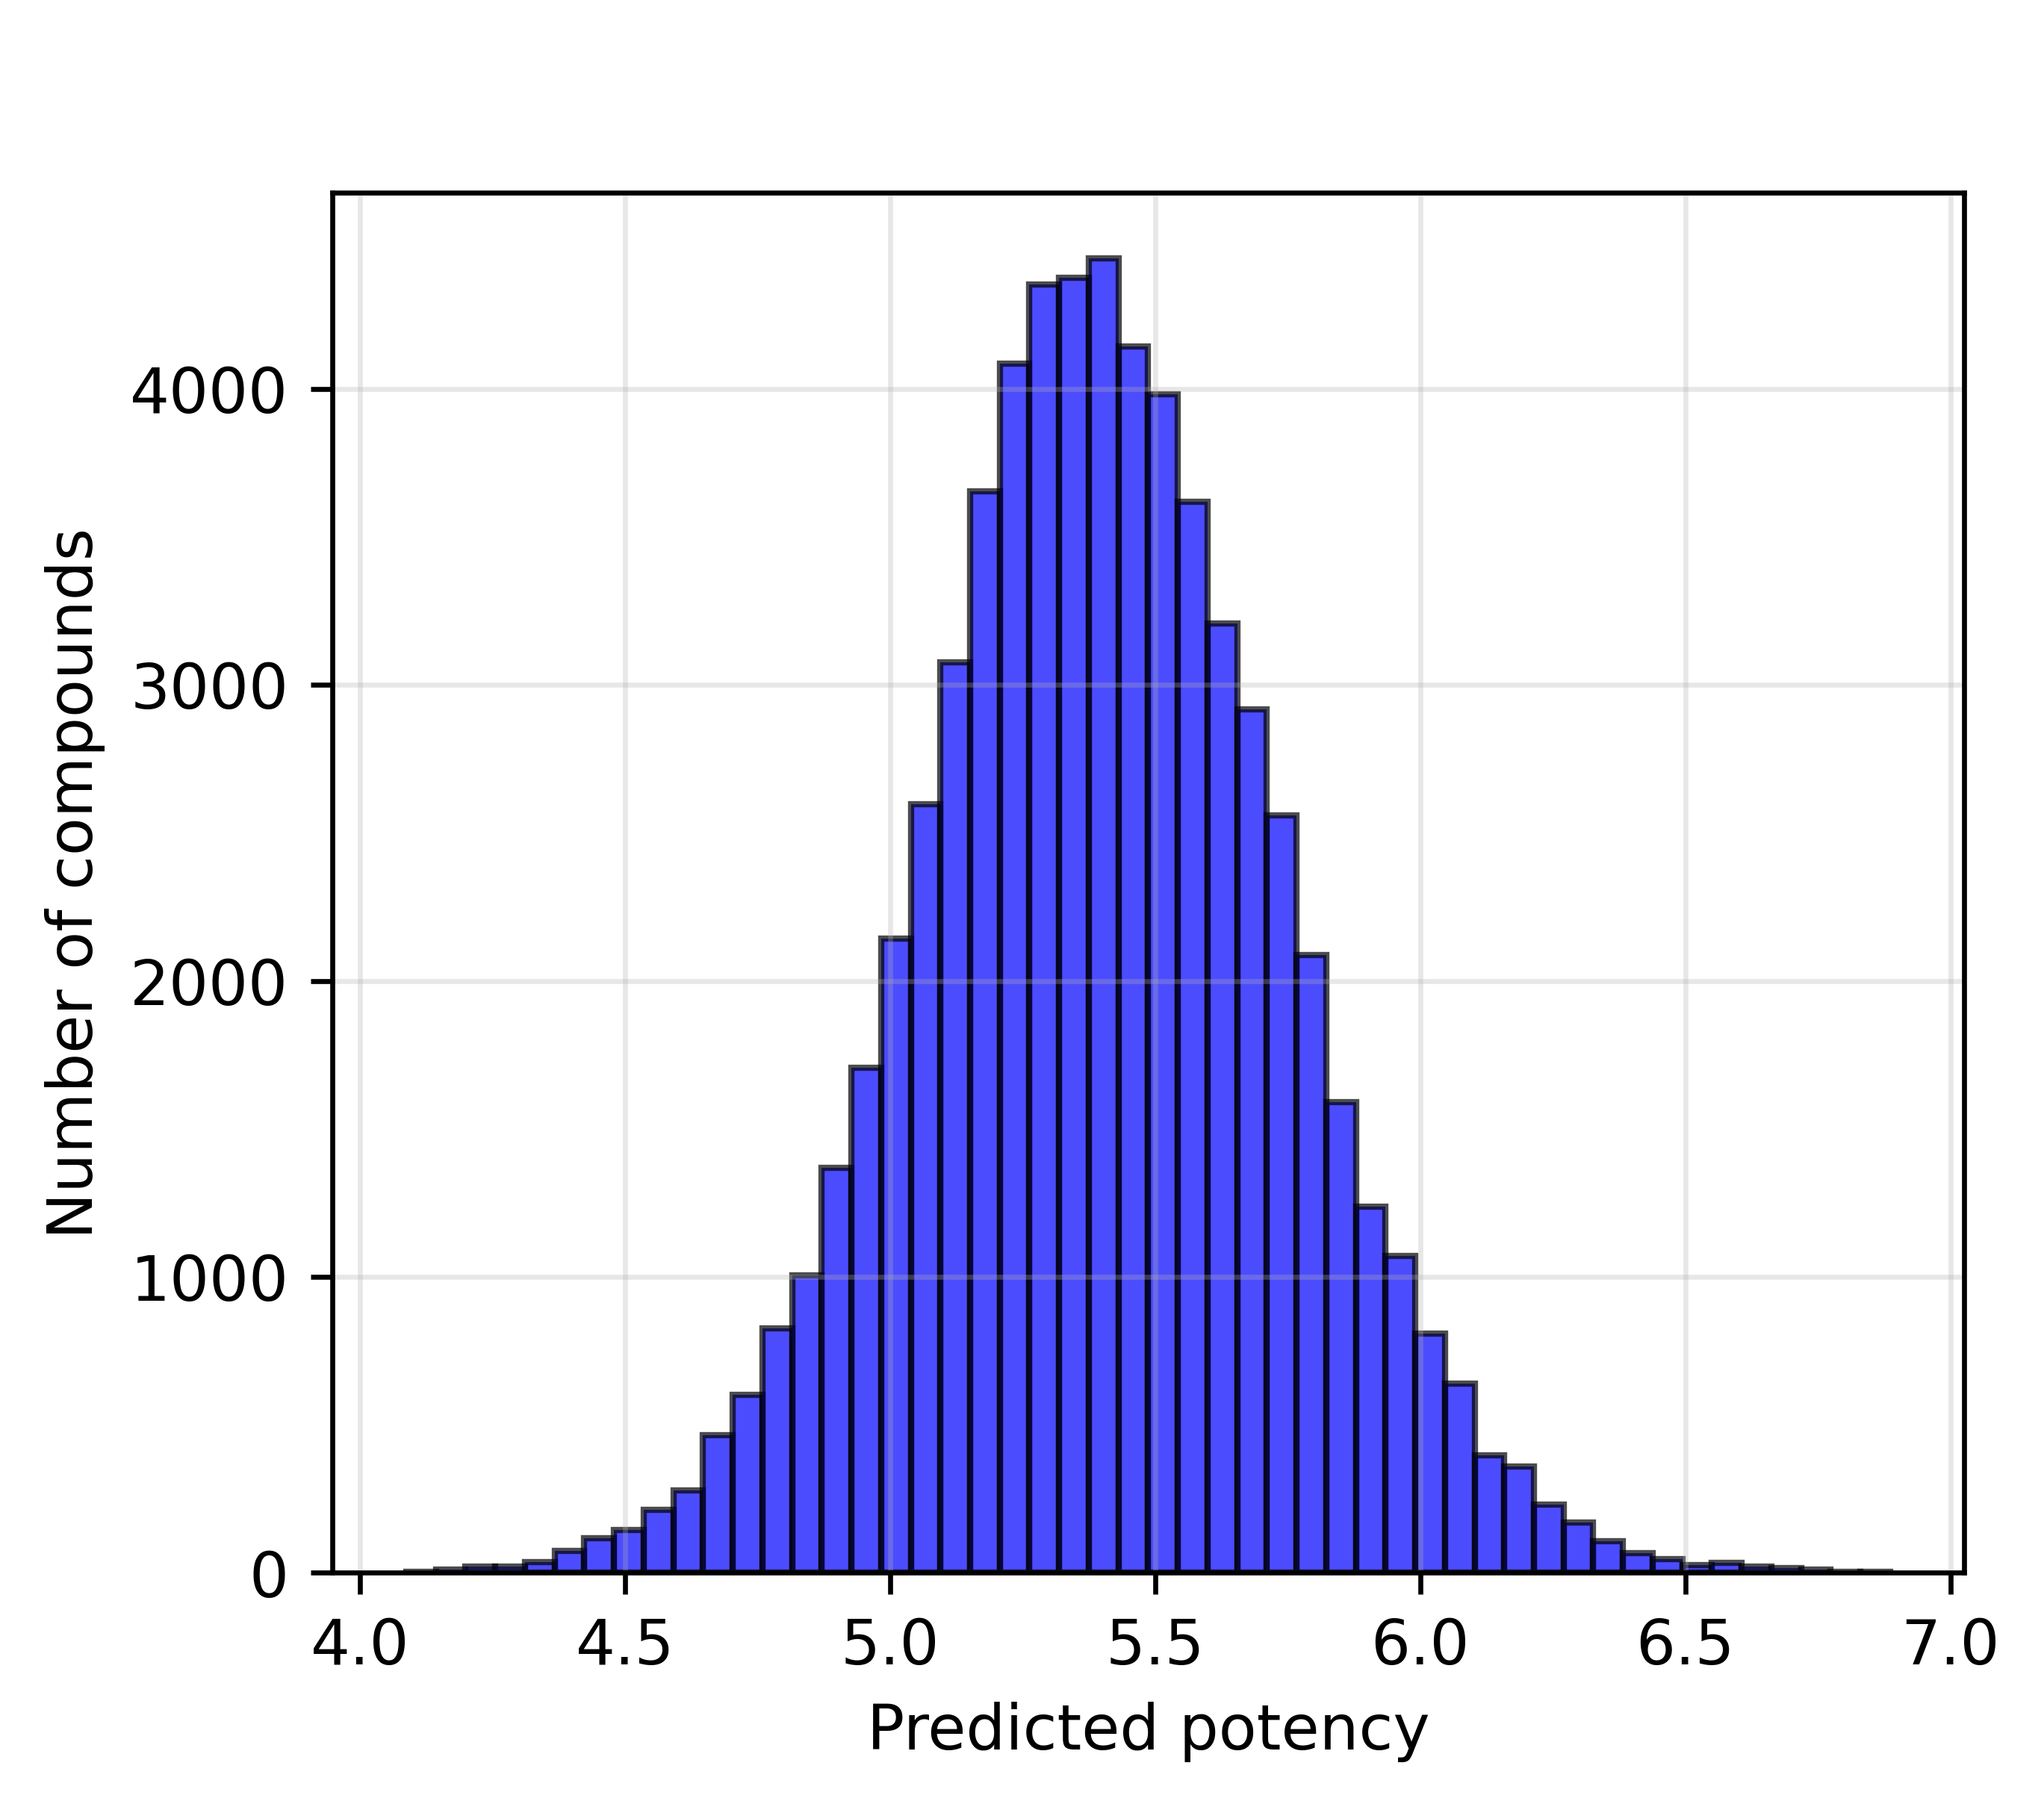

In [344]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_ChemDivDatasets.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_ChemDivDatasets.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [345]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 0 compounds
Medium priority (6 ≤ pPotency < 7.0): 2769 compounds
Low priority (5 ≤ pPotency < 6): 54733 compounds


In [346]:
ChemDivAntiviralsData_final = ChemDivAntiviralsData.iloc[idx].copy()
ChemDivAntiviralsData_final['pPotency_prediction'] = Y1_lib_pred[idx]
ChemDivAntiviralsData_final = ChemDivAntiviralsData_final.filter(
    items=["SMILES", "pPotency_prediction", "clogP"]
)
ChemDivAntiviralsData_final

Empty DataFrame
Columns: [SMILES, pPotency_prediction]
Index: []

### Top 20 compounds with higher pPotency

In [347]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

Top 20 compounds cutoff pPotency: 6.72
Highest predicted pPotency: 6.89
Range of top 20: 6.72 - 6.89


In [348]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
ChemDivAntiviralsData_top20 = ChemDivAntiviralsData.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
ChemDivAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
ChemDivAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
ChemDivAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
ChemDivAntiviralsData_top20 = ChemDivAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
ChemDivAntiviralsData_top20

----------------------------------------------------------------------
Top 20 Compounds with Highest Predicted pPotency
----------------------------------------------------------------------

Cutoff Values (20th ranked compound):
  pPotency:    6.718
  IC50:        1.914e-07 M  (191.39 nM)

Best Values (1st ranked compound):
  pPotency:    6.886
  IC50:        1.300e-07 M  (129.99 nM)
Range for Top 20 Compounds:
pPotency Range:  6.718 - 6.886

IC50 Range (M):  1.914e-07 - 1.300e-07


Rank                                             SMILES  \
34948     1  CCN(C)CCN(CC)C(=O)CCc1cc2c(n1-c1ccc(C)cc1OC)-c...   
34963     2  CCN(C)CCN(CC)C(=O)CCc1cc2c(n1-c1ccc(OC)cc1)-c1...   
50221     3  CCOC(=O)c1c(C)n(-c2ccc(C)cc2)c2ccc(OCC(O)CN3CC...   
42925     4  CCCCN(C)CCN1C(=O)[C@H]2C(C(=O)Nc3cccc(OC)c3)[C...   
50222     5  CCOC(=O)c1c(C)n(-c2ccc(C)cc2)c2ccc(OCC(O)CN3CC...   
44279     6  CC(=O)c1cc(-c2ccccc2)n(CC(=O)N2CCC(N(C)CC3CCCO...   
50043     7  CCN(CC)CCN1C(=O)C(O)=C(C(=O)c2ccc(S(=O)(=O)N3C...   
45588     8  COc1cccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3C...   
9595      9  CCN(CC)CCN1C(=O)C(O)=C(C(=O)c2ccc(S(=O)(=O)N3C...   
50229    10  CCOC(=O)c1c(C)n(-c2ccc(C)cc2)c2ccc(OCC(O)CN3CC...   
49976    11  COc1ccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC3...   
10244    12  CCCCN(C)CCCN1C(=O)[C@H]2C(C(=O)Nc3cccc(Cl)c3)[...   
11017    13  CC(C)c1ccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC...   
49982    14  CCCCN(C)CCCN1C(=O)[C@@H]2C(C(=O)Nc3cccc(SC)c3)...   
34800    15  CCN(C)CCN(CC)C(=O)CCc1ccc(-c2ccc(OC)cc2)n1-c1c...   
34126    16  CCN1CCN(S(=O)(=O)c2cc(NC(=O)C3CC3)ccc2Oc2c(C)c...   
25898    17  CCN(CCN(C)C)C(=O)c1ccc(N2CCNCC2)c(NS(=O)(=O)c2...   
25       18  COc1cccc(NC(=O)C2[C@@H]3C=C[C@@]4(O3)C(C(=O)NC...   
41340    19  CSc1cccc(NC(=O)C2[C@H]3C=C[C@]4(O3)C(C(=O)NC3C...   
50846    20  C=CCN1C(=O)NC(c2cccc(OCc3ccccc3)c2)C2=C1CN(CCN...   

       pPotency_prediction  IC50 (M)  
34948                6.886 1.300e-07  
34963                6.885 1.302e-07  
50221                6.838 1.452e-07  
42925                6.810 1.549e-07  
50222                6.795 1.605e-07  
44279                6.786 1.638e-07  
50043                6.778 1.666e-07  
45588                6.768 1.707e-07  
9595                 6.766 1.712e-07  
50229                6.758 1.746e-07  
49976                6.750 1.777e-07  
10244                6.745 1.800e-07  
11017                6.739 1.823e-07  
49982                6.738 1.829e-07  
34800                6.732 1.852e-07  
34126                6.725 1.883e-07  
25898                6.724 1.890e-07  
25                   6.723 1.892e-07  
41340                6.720 1.906e-07  
50846                6.718 1.914e-07

In [349]:
ChemDivAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_ChemDivAntiviralsData_top20.csv"), index=False)
ChemDivAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_ChemDivAntiviralsData_top20_SMILES.csv"), index=False)

 Saved PNG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/Ebolavirus/EbolaVirus_predictedCompounds_noDuplicates_ChemDivDataset.png
 Saved SVG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/Ebolavirus/EbolaVirus_predictedCompounds_noDuplicates_ChemDivDataset.svg


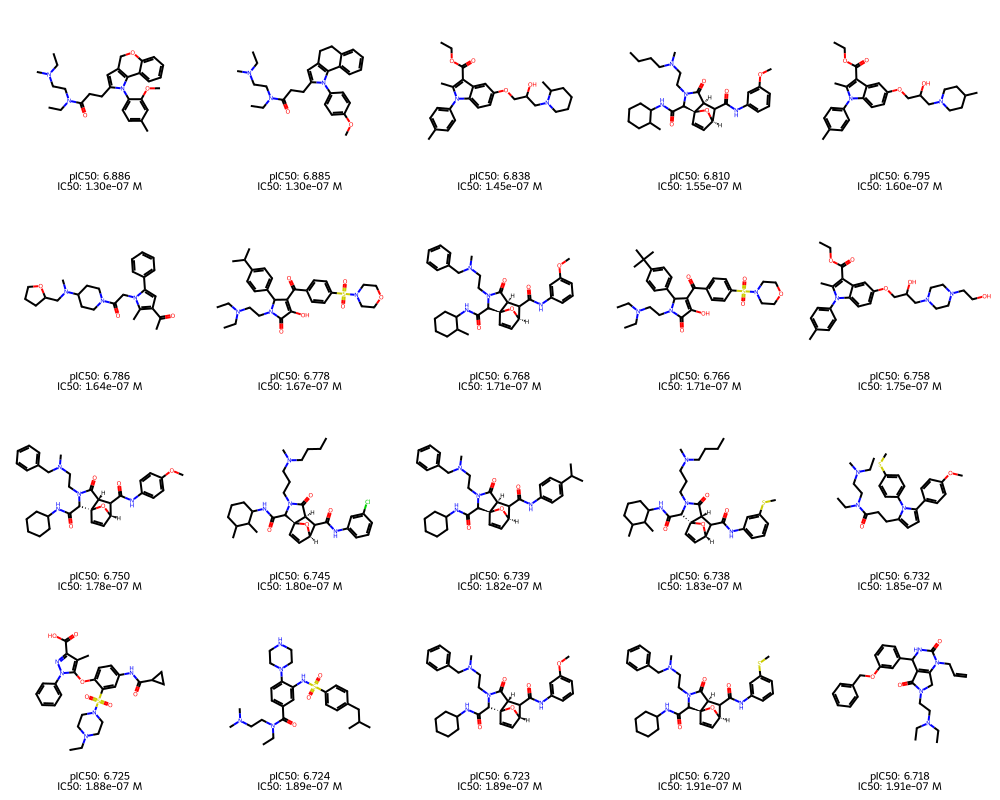

In [350]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image

# Setup paths
output_dir = resultsDir + 'Ebolavirus/'
os.makedirs(output_dir, exist_ok=True)

# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in ChemDivAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in ChemDivAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = output_dir + 'EbolaVirus_predictedCompounds_noDuplicates_ChemDivDataset.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = output_dir + 'EbolaVirus_predictedCompounds_noDuplicates_ChemDivDataset.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

### 2.4 Discovery of new hits specific to all viruses (data source SMACC Antivirals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. In particular, we are interested in molecules with high predicted pPotency.

In [351]:
SMACCAntiviralsData = pd.read_csv(modelBuildingDataDir + "SMACCAntiviralsData_clean.csv")

# Check for duplicates
dup_check = SMACCAntiviralsData.groupby('SMILES')['pIC50'].agg(['count', 'median', 'std'])
duplicates = dup_check[dup_check['count'] > 1]
print(f"Original SMACC data shape: {SMACCAntiviralsData.shape}, with Duplicate SMILES: {len(duplicates)}")

# Take median pIC50 for duplicates
SMACCAntiviralsData = SMACCAntiviralsData.groupby('SMILES').agg({
    'Molecule ChEMBL ID': 'first',
    'pIC50': 'median',  # Use median instead of mean
    'Virus': 'first'
}).reset_index()

print(f"After removing internal duplicates: {SMACCAntiviralsData.shape}")

print(f"Number of unique SMILES in training set: {len(canonical_train)}")
# Add canonical SMILES column to SMACC data (reusing canonical_train from previous code)
SMACCAntiviralsData['Canonical_SMILES'] = SMACCAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~SMACCAntiviralsData['Canonical_SMILES'].isin(canonical_train)
SMACCAntiviralsData_filtered = SMACCAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
SMACCAntiviralsData = SMACCAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered SMACC data shape for validation: {SMACCAntiviralsData.shape}")
print(f"Removed {SMACCAntiviralsData_filtered.shape[0] - SMACCAntiviralsData.shape[0]} duplicate compounds from SMACC data set")
SMACCAntiviralsData = SMACCAntiviralsData.rename(columns={'pIC50': 'pIC50_experimental'})

smi_lib = SMACCAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
SMACCAntiviralsData.head()

Original SMACC data shape: (1923, 5), with Duplicate SMILES: 197
After removing internal duplicates: (1612, 4)
Number of unique SMILES in training set: 540
Filtered SMACC data shape for validation: (1612, 4)
Removed 0 duplicate compounds from SMACC data set
Total compounds to screen: 1612


SMILES Molecule ChEMBL ID  \
0                  Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1       CHEMBL243652   
1  Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...      CHEMBL4284511   
2  Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...      CHEMBL1402117   
3                          Brc1ccc2C(=O)C(=O)C=Cc2c1      CHEMBL4303595   
4  Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...      CHEMBL1361582   

   pIC50_experimental       Virus  
0               5.690  SARS-CoV-2  
1               5.328      Dengue  
2               4.132      Dengue  
3               7.097  SARS-CoV-2  
4               4.627      Dengue

Generate predictions

In [352]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [353]:
SMACCAntiviralsData_predicted = SMACCAntiviralsData.copy()
SMACCAntiviralsData_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
SMACCAntiviralsData_predicted['IC50(M)_experimental'] = 10 ** (-SMACCAntiviralsData_predicted['pIC50_experimental'])
SMACCAntiviralsData_predicted['pPotency(M)_prediction'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_prediction'])

SMACCAntiviralsData_predicted = SMACCAntiviralsData_predicted.filter(
    items=["SMILES", "Virus", "pIC50_experimental", "pPotency_prediction",  "IC50(M)_experimental", "pPotency(M)_prediction"]
)
SMACCAntiviralsData_predicted

SMILES       Virus  \
0                     Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1  SARS-CoV-2   
1     Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...      Dengue   
2     Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...      Dengue   
3                             Brc1ccc2C(=O)C(=O)C=Cc2c1  SARS-CoV-2   
4     Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...      Dengue   
...                                                 ...         ...   
1607                              S=C1NN=C(Nc2ccccc2)S1  SARS-CoV-2   
1608                                    S=C1Nc2ccccc2S1  SARS-CoV-2   
1609                                      SC(=S)N1CCCC1  SARS-CoV-2   
1610                   c1coc(c1)-c1nc2ccccc2nc1-c1ccco1      Dengue   
1611              c1coc(c1)-c1nc2nc3ccccc3n2nc1-c1ccco1      Dengue   

      pIC50_experimental  pPotency_prediction  IC50(M)_experimental  \
0                  5.690                4.947             2.040e-06   
1                  5.328                5.100             4.700e-06   
2                  4.132                4.910             7.371e-05   
3                  7.097                4.346             8.000e-08   
4                  4.627                5.042             2.359e-05   
...                  ...                  ...                   ...   
1607               6.409                4.649             3.900e-07   
1608               5.759                4.578             1.740e-06   
1609               6.678                4.751             2.100e-07   
1610               4.000                5.238             1.000e-04   
1611               4.003                5.756             9.930e-05   

      pPotency(M)_prediction  
0                  1.131e-05  
1                  7.947e-06  
2                  1.229e-05  
3                  4.512e-05  
4                  9.079e-06  
...                      ...  
1607               2.246e-05  
1608               2.640e-05  
1609               1.776e-05  
1610               5.787e-06  
1611               1.755e-06  

[1612 rows x 6 columns]

In [354]:
SMACCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_SMACCAntiviralsData_predicted_all.csv"), index=False)
SMACCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_SMACCAntiviralsData_predicted_all_SMILES.csv"), index=False)

### Plot the error between `experimental_pPotency` and `predicted_pPotency`

Mean Residual: 0.533
Std Dev of Residuals: 1.061
Min Residual: -4.520
Max Residual: 3.264


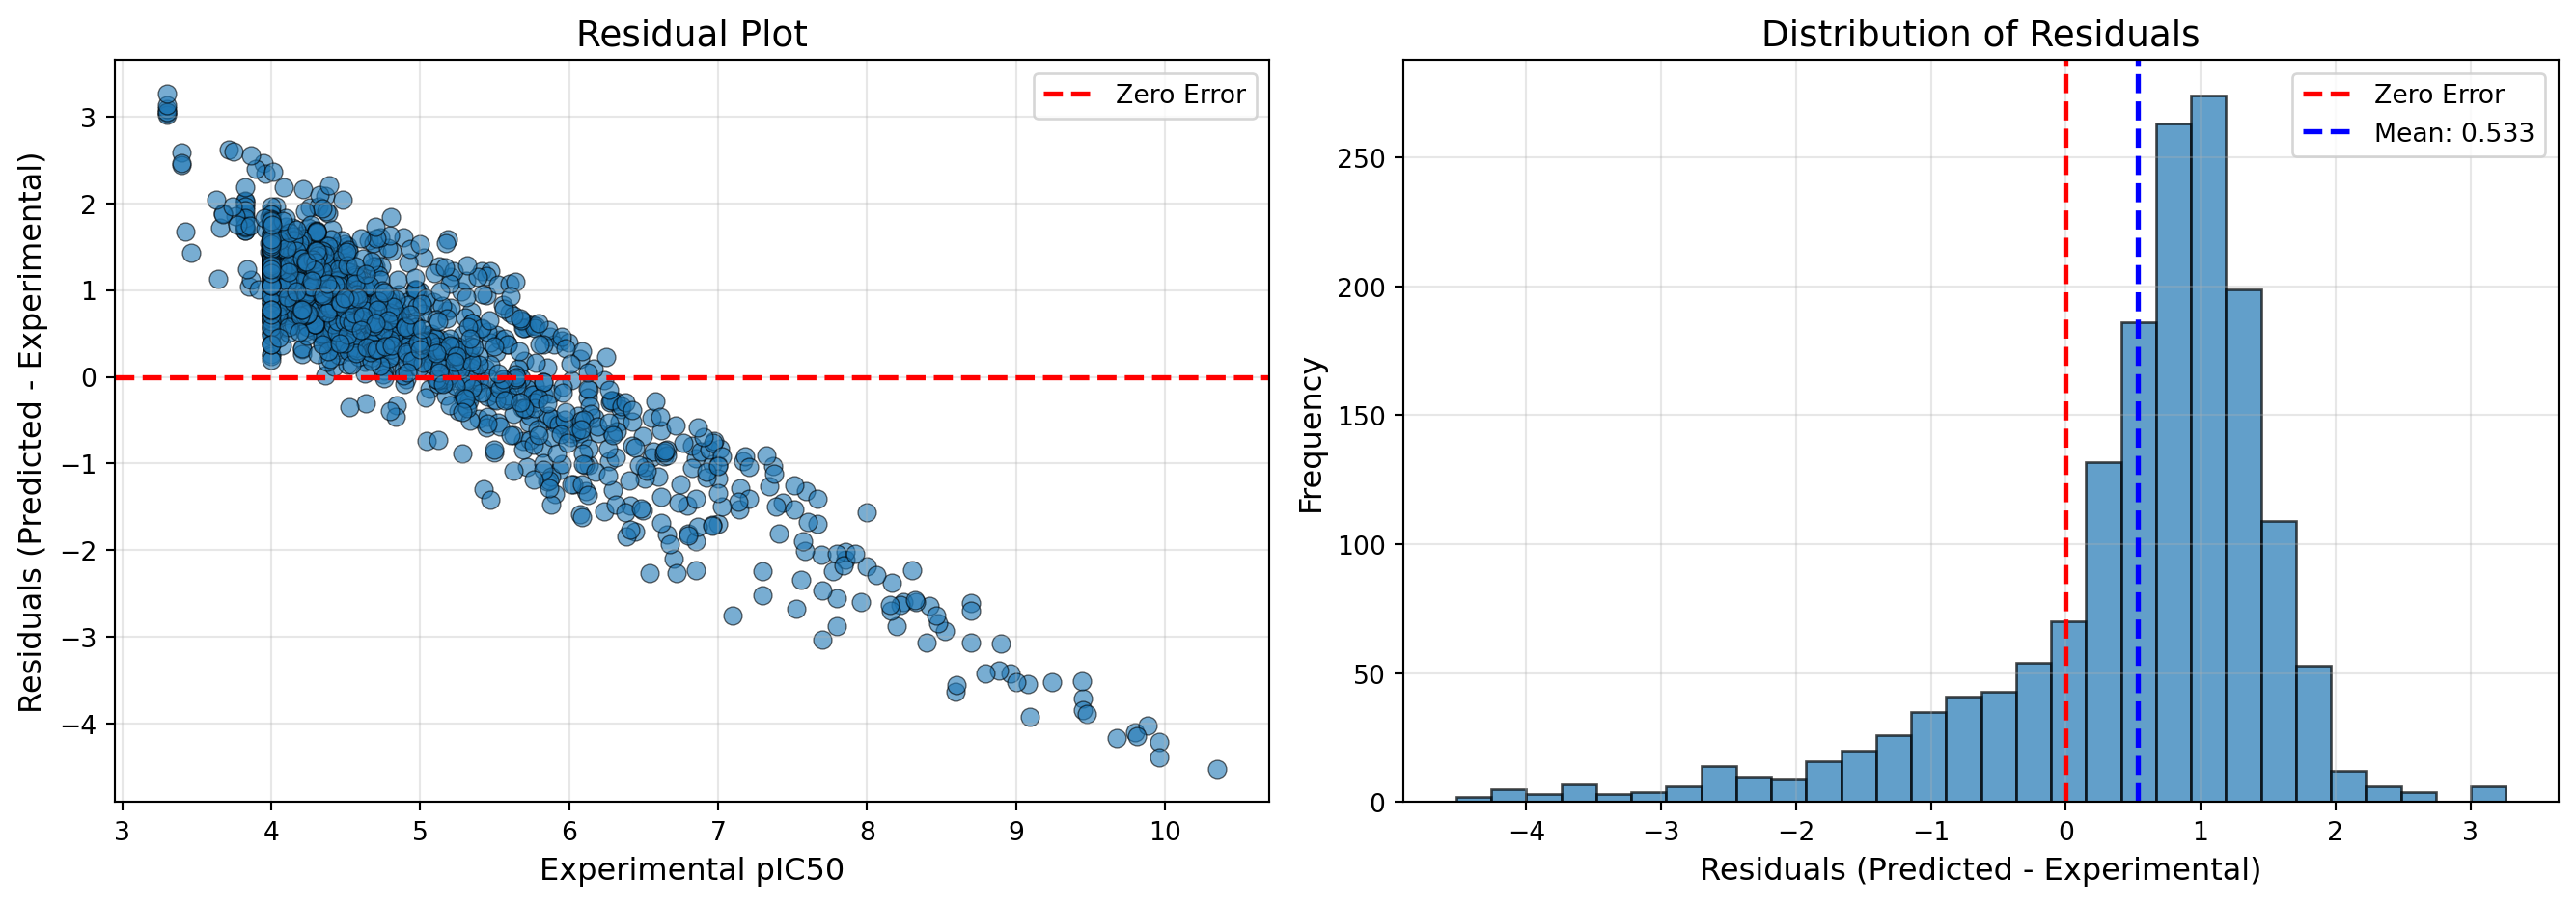

In [355]:
# Calculate residuals (difference)
SMACCAntiviralsData_predicted['residuals'] = (
    SMACCAntiviralsData_predicted['pPotency_prediction'] - 
    SMACCAntiviralsData_predicted['pIC50_experimental']
)

# Print statistics
print(f"Mean Residual: {SMACCAntiviralsData_predicted['residuals'].mean():.3f}")
print(f"Std Dev of Residuals: {SMACCAntiviralsData_predicted['residuals'].std():.3f}")
print(f"Min Residual: {SMACCAntiviralsData_predicted['residuals'].min():.3f}")
print(f"Max Residual: {SMACCAntiviralsData_predicted['residuals'].max():.3f}")

# Create residual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Residuals vs Experimental values
axes[0].scatter(SMACCAntiviralsData_predicted['pIC50_experimental'], 
                SMACCAntiviralsData_predicted['residuals'], 
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Experimental pIC50', fontsize=12)
axes[0].set_ylabel('Residuals (Predicted - Experimental)', fontsize=12)
axes[0].set_title('Residual Plot', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of residuals
axes[1].hist(SMACCAntiviralsData_predicted['residuals'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].axvline(x=SMACCAntiviralsData_predicted['residuals'].mean(), 
                color='blue', linestyle='--', linewidth=2, 
                label=f'Mean: {SMACCAntiviralsData_predicted["residuals"].mean():.3f}')
axes[1].set_xlabel('Residuals (Predicted - Experimental)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Residual Plot Analysis

In [356]:
print(f"Mean residual: {SMACCAntiviralsData_predicted['residuals'].mean():.3f} (Close to 0 indicates no systematic bias)")
print(f"Std deviation: {SMACCAntiviralsData_predicted['residuals'].std():.3f} (typical prediction error)")
print(f"95% of predictions are within ±{1.96 * SMACCAntiviralsData_predicted['residuals'].std():.3f} pIC50 units")

Mean residual: 0.533 (Close to 0 indicates no systematic bias)
Std deviation: 1.061 (typical prediction error)
95% of predictions are within ±2.080 pIC50 units


Let us have a look at the compounds:

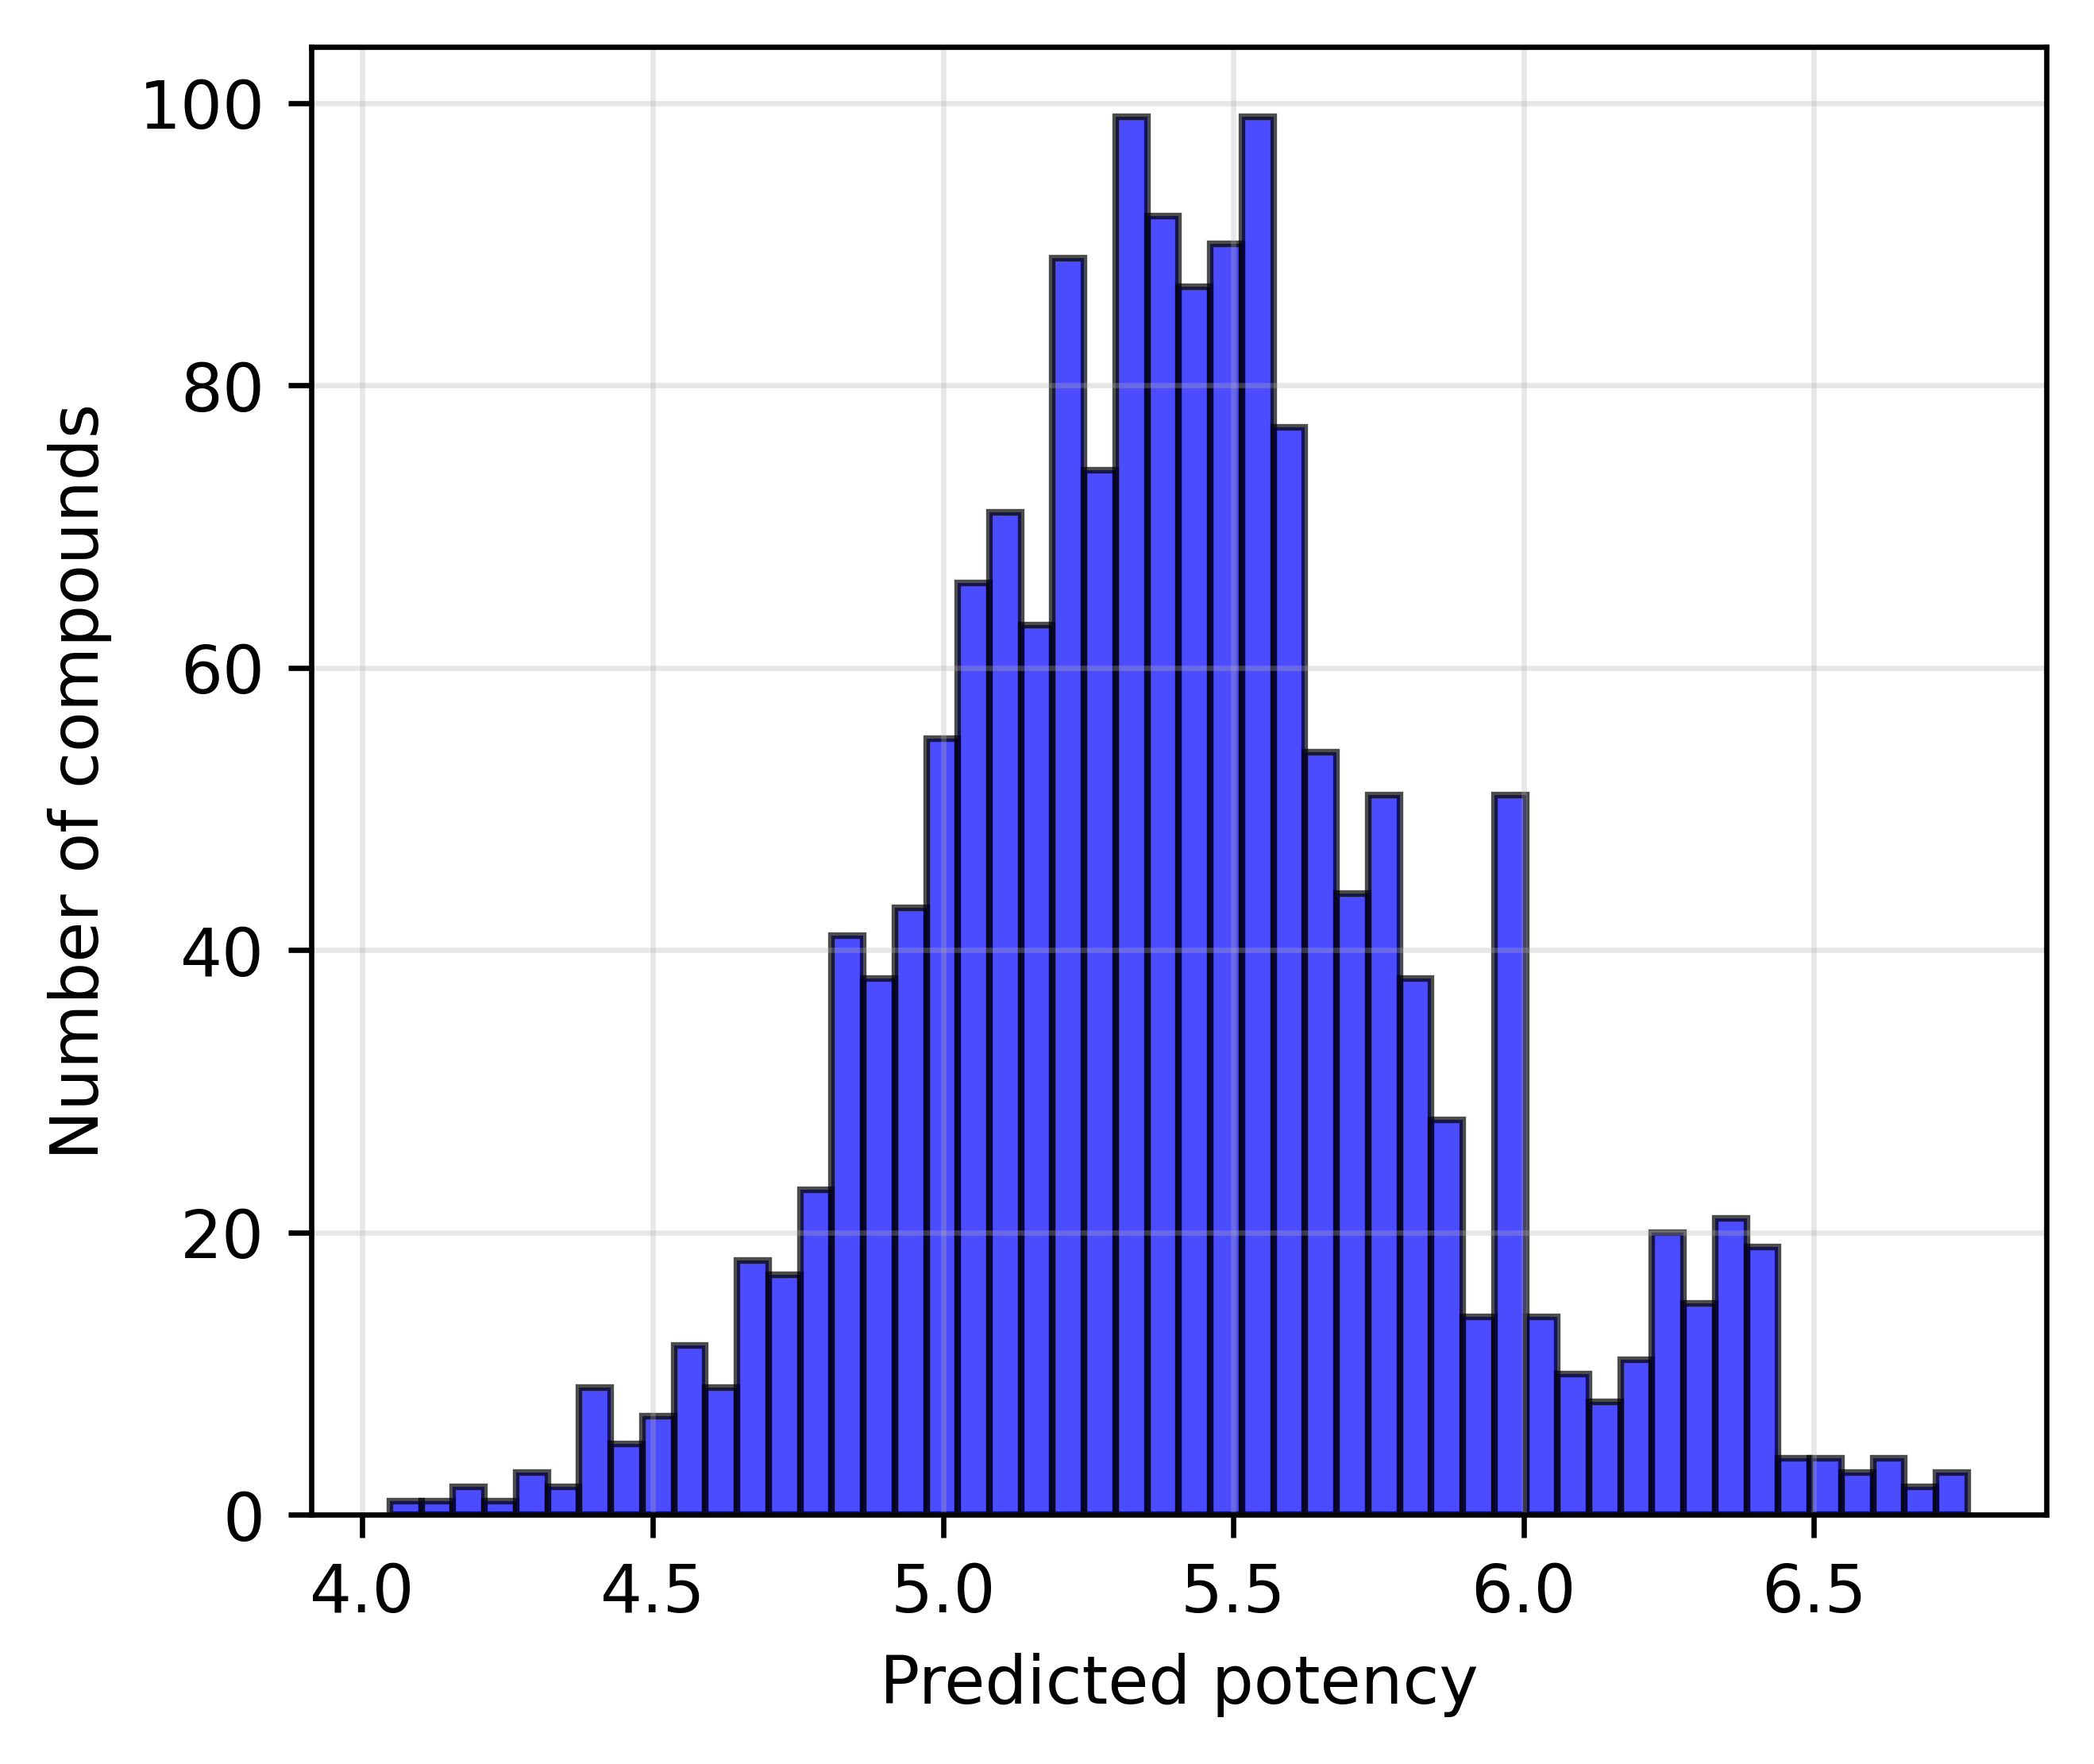

In [357]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.title(f"Virtual screening of custom library ({len(smi_lib)} molecules)", pad=35)
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_noDuplicates_validation_noDuplicates_SMACCDatasets.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_noDuplicates_validation_noDuplicates_SMACCDatasets.png', bbox_inches='tight', dpi=300)
plt.show()

In [358]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 0 compounds
Medium priority (6 ≤ pPotency < 7.0): 141 compounds
Low priority (5 ≤ pPotency < 6): 1204 compounds


### Top 20 compounds with higher pPotency

In [359]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

Top 20 compounds cutoff pPotency: 6.45
Highest predicted pPotency: 6.76
Range of top 20: 6.45 - 6.76


In [360]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
SMACCAntiviralsData_top20 = SMACCAntiviralsData_predicted.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
SMACCAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
SMACCAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
SMACCAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'


SMACCAntiviralsData_top20

----------------------------------------------------------------------
Top 20 Compounds with Highest Predicted pPotency
----------------------------------------------------------------------

Cutoff Values (20th ranked compound):
  pPotency:    6.446
  IC50:        3.583e-07 M  (358.30 nM)

Best Values (1st ranked compound):
  pPotency:    6.765
  IC50:        1.719e-07 M  (171.89 nM)
Range for Top 20 Compounds:
pPotency Range:  6.446 - 6.765

IC50 Range (M):  3.583e-07 - 1.719e-07


Rank                                             SMILES      Virus  \
900      1  Cc1ccc(cc1)N1CC(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C(...     Dengue   
1141     2  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)c1ccccc1)C(=O)...     Dengue   
978      3  Cc1cccc(c1)N1CC(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C(...     Dengue   
452      4  CN(C(CCCNC(N)=N)C(=O)NC(CCCCN)C(=O)NC(C(N)=O)c...     Dengue   
1139     5  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)c1ccccc1)C(=O)...     Dengue   
301      6  CCCCC(NC(=O)c1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)NC...     Dengue   
47       7  CC(=O)Nc1ccc(CC(NC(=O)c2ccccc2)C(=O)NC(CCCCN)C...  West_Nile   
453      8  CN(C(CCCNC(N)=N)C(=O)NC(CCCCN)C(=O)NC(C(N)=O)c...     Dengue   
300      9  CCCCC(NC(=O)c1ccccc1)C(=O)NC(CCCCN)C(=O)NC(Cc1...     Dengue   
1140    10  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)c1ccccc1)C(=O)...     Dengue   
454     11  CN(C(CCCNC(N)=N)C(=O)NC(CCCCN)C(=O)NC(C)(C(N)=...     Dengue   
292     12  CCCCC(NC(=O)c1ccccc1)C(=O)NC(CCCCN)C(=O)NC(CCC...     Dengue   
1126    13  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)C(=O)c1ccccc1)...     Dengue   
367     14  CCOC(=O)C=CC(CC1CCNC1=O)NC(=O)C(Cc1ccc(F)cc1)N...       229E   
1148    15  NCCCCC(NC(=O)C(Cc1cccc(NC(N)=N)c1)NC(=O)c1cccc...  West_Nile   
281     16  CCCCC(NC(=O)c1ccccc1)C(=O)NC(CCCCN)C(=O)NC(CCC...     Dengue   
84      17  CC(C)CC1N2C(=O)C(NC(=O)C3CN(C)C4Cc5c(Br)[nH]c6...       Zika   
1142    18  NCCCCC(NC(=O)C(CCCNC(N)=N)NC(=O)c1ccccc1)C(=O)...     Dengue   
264     19  CCCCC(N(C)C(=O)c1ccccc1)C(=O)NC(CCCCN)C(=O)NC(...     Dengue   
294     20  CCCCC(NC(=O)c1ccccc1)C(=O)NC(CCCCN)C(=O)NC(CCC...     Dengue   

      pIC50_experimental  pPotency_prediction  IC50(M)_experimental  \
900                5.184                6.765             6.552e-06   
1141               5.638                6.731             2.300e-06   
978                5.169                6.715             6.776e-06   
452                5.472                6.692             3.370e-06   
1139               5.602                6.673             2.500e-06   
301                4.801                6.648             1.580e-05   
47                 5.415                6.635             3.850e-06   
453                5.444                6.612             3.600e-06   
300                4.390                6.605             4.070e-05   
1140               5.314                6.595             4.854e-06   
454                5.523                6.588             3.000e-06   
292                3.301                6.565             5.000e-04   
1126               5.387                6.539             4.100e-06   
367                5.000                6.535             1.000e-05   
1148               5.606                6.532             2.480e-06   
281                4.481                6.526             3.300e-05   
84                 4.885                6.490             1.304e-05   
1142               6.247                6.479             5.657e-07   
264                4.360                6.448             4.370e-05   
294                5.222                6.446             6.000e-06   

      pPotency(M)_prediction  residuals  IC50 (M)  
900                1.719e-07      1.581 1.719e-07  
1141               1.857e-07      1.093 1.857e-07  
978                1.929e-07      1.546 1.929e-07  
452                2.033e-07      1.220 2.033e-07  
1139               2.123e-07      1.071 2.123e-07  
301                2.247e-07      1.847 2.247e-07  
47                 2.315e-07      1.221 2.315e-07  
453                2.446e-07      1.168 2.446e-07  
300                2.483e-07      2.215 2.483e-07  
1140               2.539e-07      1.281 2.539e-07  
454                2.584e-07      1.065 2.584e-07  
292                2.725e-07      3.264 2.725e-07  
1126               2.893e-07      1.151 2.893e-07  
367                2.920e-07      1.535 2.920e-07  
1148               2.940e-07      0.926 2.940e-07  
281                2.976e-07      2.045 2.976e-07  
84                 3.234e-07     

In [361]:
SMACCAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_SMACCAntiviralsData_top20.csv"), index=False)
SMACCAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_SMACCAntiviralsData_top20_SMILES.csv"), index=False)

 Saved PNG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_predictedCompounds_noDuplicates_SMACCDataset.png
 Saved SVG: /mnt/data.ese/nfs/users/sghosh6/DTRA_project/MACAW/DrugDesignData/Results/combinedEbolaVirus/combinedEbolaVirus_predictedCompounds_noDuplicates_SMACCDataset.svg


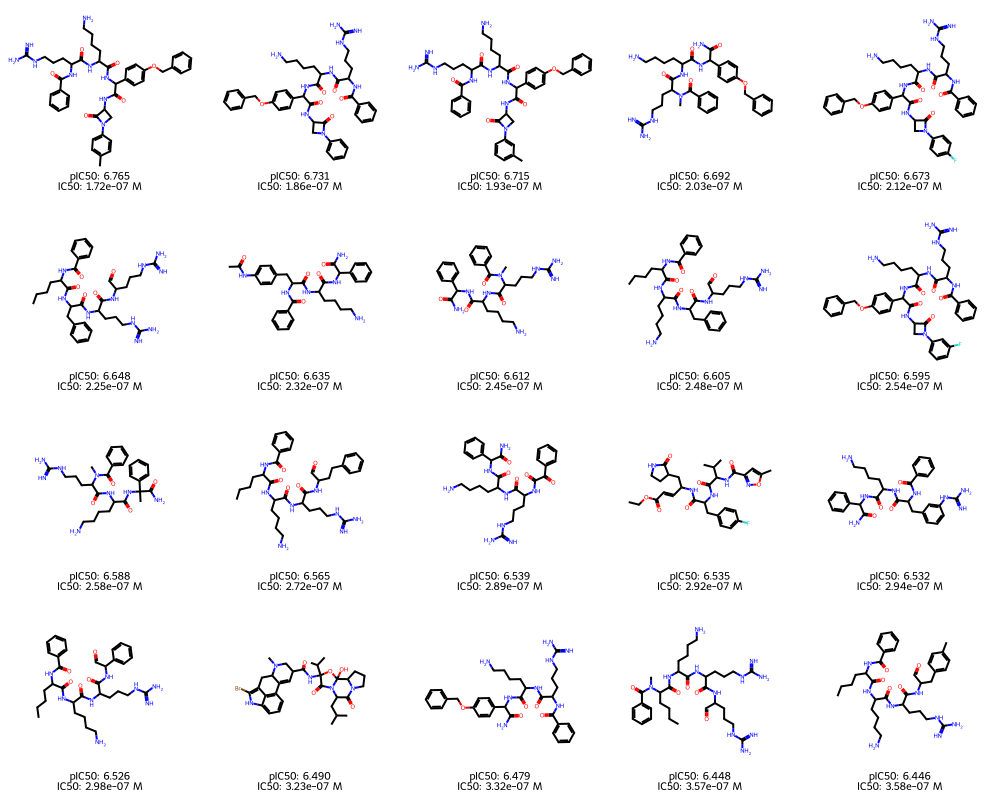

In [362]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image

# Setup paths
output_dir = resultsDir + 'combinedEbolaVirus/'
os.makedirs(output_dir, exist_ok=True)

# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in SMACCAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in SMACCAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = output_dir + 'combinedEbolaVirus_predictedCompounds_noDuplicates_SMACCDataset.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = output_dir + 'combinedEbolaVirus_predictedCompounds_noDuplicates_SMACCDataset.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

### Checking drug likeliness of `Remdesivir` and `Molnupiravir`

In [363]:
Remdesivir_SMILES_file = os.path.join(dataDir + "/target_SMILES/Remdesivir_structure.mol")
Molnupiravir_SMILES_file = os.path.join(dataDir + "/target_SMILES/Molnupiravir_structure.mol")

In [364]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd

# SMILES strings
Remdesivir_SMILES = 'CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1'
Molnupiravir_SMILES = 'CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=C\C(NC1=O)=N\O'

# Dictionary of drugs and their SMILES
drugs = {
    'Remdesivir': Remdesivir_SMILES,
    'Molnupiravir': Molnupiravir_SMILES
}

# List to store results
smiles_data = []

# Process each drug
for drug_name, smiles in drugs.items():
    # Convert SMILES to molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        smiles_data.append({
            'Drug_Name': drug_name,
            'SMILES': smiles,
            'Molecular_Formula': rdMolDescriptors.CalcMolFormula(mol),
            'Molecular_Weight': round(Descriptors.MolWt(mol), 2)
        })
        print(f" {drug_name}")
        print(f"  Formula: {rdMolDescriptors.CalcMolFormula(mol)}")
        print(f"  MW: {round(Descriptors.MolWt(mol), 2)} g/mol")
    else:
        print(f" Failed to parse SMILES for {drug_name}")

# Create DataFrame
DTRA_target_SMILES = pd.DataFrame(smiles_data)
DTRA_target_SMILES

 Remdesivir
  Formula: C27H35N6O8P
  MW: 602.59 g/mol
 Molnupiravir
  Formula: C13H19N3O7
  MW: 329.31 g/mol


Drug_Name                                             SMILES  \
0    Remdesivir  CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...   
1  Molnupiravir  CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...   

  Molecular_Formula  Molecular_Weight  
0       C27H35N6O8P           602.590  
1        C13H19N3O7           329.310

In [365]:
# Canonicalize training SMILES and create a set for fast lookup
canonical_train = set()
for smi in smiles_train:
    canonical_smi = canonicalize_smiles(smi)
    if canonical_smi is not None:
        canonical_train.add(canonical_smi)

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to DTRA target data
DTRA_target_SMILES['Canonical_SMILES'] = DTRA_target_SMILES['SMILES'].apply(canonicalize_smiles)

# ADDED: Save original count BEFORE filtering
original_count = DTRA_target_SMILES.shape[0]

# Filter out duplicates - keep only those NOT in training set
mask = ~DTRA_target_SMILES['Canonical_SMILES'].isin(canonical_train)
DTRA_target_SMILES_filtered = DTRA_target_SMILES[mask].copy()

# Remove the helper column if you don't need it
DTRA_target_SMILES = DTRA_target_SMILES_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered DTRA target data shape for validation: {DTRA_target_SMILES.shape}")
print(f"Removed {original_count - DTRA_target_SMILES.shape[0]} duplicate compounds from DTRA target data set")  # FIXED

# Now use the filtered data
smi_lib = DTRA_target_SMILES.SMILES
print(f"Total DTRA target compounds to screen: {len(smi_lib)}")

# Display the filtered data
DTRA_target_SMILES

Number of unique SMILES in training set: 540
Filtered DTRA target data shape for validation: (1, 4)
Removed 1 duplicate compounds from DTRA target data set
Total DTRA target compounds to screen: 1


Drug_Name                                             SMILES  \
1  Molnupiravir  CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...   

  Molecular_Formula  Molecular_Weight  
1        C13H19N3O7           329.310

Generate predictions

In [366]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [367]:
DTRA_target_SMILES_predicted = DTRA_target_SMILES.copy()
DTRA_target_SMILES_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
DTRA_target_SMILES_predicted['pPotency(M)_prediction'] = 10 ** (-DTRA_target_SMILES_predicted['pPotency_prediction'])

DTRA_target_SMILES_predicted = DTRA_target_SMILES_predicted.filter(
    items=["SMILES", "pPotency_prediction",  "pPotency(M)_prediction"]
)
DTRA_target_SMILES_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_DTRAtargets_predicted_all.csv"), index=False)
DTRA_target_SMILES_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_noDuplicates_DTRAtargets_predicted_all_SMILES.csv"), index=False)
DTRA_target_SMILES_predicted

SMILES  pPotency_prediction  \
1  CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...                5.080   

   pPotency(M)_prediction  
1               8.327e-06

### Checking efficiency of `Remdesivir` as a antiviral, it present in training data set

In [368]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd

# SMILES strings
Remdesivir_SMILES = 'CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1'

# Dictionary of drugs and their SMILES
drugs = {
    'Remdesivir': Remdesivir_SMILES,
}

# List to store results
smiles_data = []

# Process each drug
for drug_name, smiles in drugs.items():
    # Convert SMILES to molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        smiles_data.append({
            'Drug_Name': drug_name,
            'SMILES': smiles,
            'Molecular_Formula': rdMolDescriptors.CalcMolFormula(mol),
            'Molecular_Weight': round(Descriptors.MolWt(mol), 2)
        })
        print(f" {drug_name}")
        print(f"  Formula: {rdMolDescriptors.CalcMolFormula(mol)}")
        print(f"  MW: {round(Descriptors.MolWt(mol), 2)} g/mol")
    else:
        print(f" Failed to parse SMILES for {drug_name}")

# Create DataFrame
DTRA_target_SMILES = pd.DataFrame(smiles_data)
DTRA_target_SMILES

 Remdesivir
  Formula: C27H35N6O8P
  MW: 602.59 g/mol


Drug_Name                                             SMILES  \
0  Remdesivir  CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...   

  Molecular_Formula  Molecular_Weight  
0       C27H35N6O8P           602.590

Find experimental pPotency value for `Remdesivir`

In [369]:
# Function to canonicalize SMILES
def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        return Chem.MolToSmiles(mol, canonical=True) if mol else None
    except:
        return None

# Create mappings from allVirusData (without modifying it)
canonical_smiles = combinedEbolaVirusData_chEMBL_noDuplicates['Smiles'].apply(canonicalize_smiles)
smiles_to_pPotency = dict(zip(canonical_smiles, combinedEbolaVirusData_chEMBL_noDuplicates['pPotency']))
smiles_to_virus = dict(zip(canonical_smiles, combinedEbolaVirusData_chEMBL_noDuplicates['StrainClassifier']))

# Add columns to DTRA_target_SMILES
DTRA_target_SMILES['pIC50_experimental'] = DTRA_target_SMILES['SMILES'].apply(
    lambda x: smiles_to_pPotency.get(canonicalize_smiles(x), None)
)
DTRA_target_SMILES['StrainClassifier'] = DTRA_target_SMILES['SMILES'].apply(
    lambda x: smiles_to_virus.get(canonicalize_smiles(x), None)
)

# Display
print(f"Compounds with experimental data: {DTRA_target_SMILES['pIC50_experimental'].notna().sum()}")
DTRA_target_SMILES

Compounds with experimental data: 1


Drug_Name                                             SMILES  \
0  Remdesivir  CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...   

  Molecular_Formula  Molecular_Weight  pIC50_experimental StrainClassifier  
0       C27H35N6O8P           602.590               7.033            Ebola

In [370]:
# Now use the filtered data
smi_lib = DTRA_target_SMILES.SMILES
print(f"Total DTRA target compounds to screen: {len(smi_lib)}")

Total DTRA target compounds to screen: 1


Generate predictions

In [371]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

In [372]:
DTRA_target_SMILES_predicted = DTRA_target_SMILES.copy()
DTRA_target_SMILES_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
DTRA_target_SMILES_predicted['IC50(M)_experimental'] = 10 ** (-DTRA_target_SMILES_predicted['pIC50_experimental'])
DTRA_target_SMILES_predicted['pPotency(M)_prediction'] = 10 ** (-DTRA_target_SMILES_predicted['pPotency_prediction'])

DTRA_target_SMILES_predicted = DTRA_target_SMILES_predicted.filter(
    items=["SMILES", "VirusClassifier", "pIC50_experimental", "pPotency_prediction",  "IC50(M)_experimental", "pPotency(M)_prediction"]
)
DTRA_target_SMILES_predicted

SMILES  pIC50_experimental  \
0  CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...               7.033   

   pPotency_prediction  IC50(M)_experimental  pPotency(M)_prediction  
0                6.065             9.274e-08               8.616e-07

Partition 1/10
  Fold 1 - Train MAE: 0.41, Test MAE: 0.43
Partition 6/10
  Fold 6 - Train MAE: 0.38, Test MAE: 0.47
Partition 10/10
  Fold 10 - Train MAE: 0.41, Test MAE: 0.48
Partition 2/10
  Fold 2 - Train MAE: 0.32, Test MAE: 0.43
Partition 7/10
  Fold 7 - Train MAE: 0.39, Test MAE: 0.46
Partition 2/10
  Fold 2 - Train MAE: 0.41, Test MAE: 0.52
Partition 8/10
  Fold 8 - Train MAE: 0.41, Test MAE: 0.55
Partition 4/10
  Fold 4 - Train MAE: 0.35, Test MAE: 0.50
Partition 5/10
  Fold 5 - Train MAE: 0.37, Test MAE: 0.45
Partition 9/10
  Fold 9 - Train MAE: 0.35, Test MAE: 0.51
Partition 3/10
  Fold 3 - Train MAE: 0.46, Test MAE: 0.49
Partition 7/10
  Fold 7 - Train MAE: 0.42, Test MAE: 0.50
Partition 1/10
  Fold 1 - Train MAE: 0.32, Test MAE: 0.49
Partition 6/10
  Fold 6 - Train MAE: 0.38, Test MAE: 0.52
Partition 10/10
  Fold 10 - Train MAE: 0.32, Test MAE: 0.45
Partition 4/10
  Fold 4 - Train MAE: 0.41, Test MAE: 0.43
Partition 5/10
  Fold 5 - Train MAE: 0.41, Test MAE: 0.50
Partition 